# Imports and preparation

In [1]:
import os

In [2]:
import torch

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
from tqdm import tqdm

In [6]:
import time, gc

In [7]:
import importlib

In [8]:
from itertools import product


In [9]:
from util import util_elastic

OpenAI tiktoken module is not available for Python < 3.8,Linux ARM64 and AARCH64. Falling back to GPT2TokenizerFast.


In [10]:
from util import util_pipeline_v2 as util_pipeline

In [11]:
from util import util_experiment_juris_tcu as util_experiment

In [12]:
# Para ter repetibilidade nos resultados
random_state = 1

# Tratar valores infinitos (+ e -) como np.NaN
pd.options.mode.use_inf_as_na = True

# IMPORTANTE para tornar figuras interativas
# %matplotlib notebook

# Tamanho padrão das figuras
figsize=(10,6)

pd.set_option('display.max_row', 1000)

pd.set_option('display.max_columns', 50)

pd.set_option('display.column_space', 100)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.width', 200)


In [13]:
DATASET_NAME = 'juris_tcu'

In [14]:

PATH_QREL =  f'../data/{DATASET_NAME}/qrel.csv'

In [15]:
EXPANSOR_CRITERIA = 'join_30_ptt5_base' # 'join_30_ptt5_indir' #  'join_30_ptt5_base' #'join_30_ptt5_indir'

In [16]:
consider_query_expanded = True

if consider_query_expanded:
    PATH_QUERY =  f'../data/juris_tcu_expanded_query/query_10_expansion_{EXPANSOR_CRITERIA}.csv' 
else:
    PATH_QUERY = f'../data/{DATASET_NAME}/query.csv'

# Data load

## Query data load

In [17]:
df_query = pd.read_csv(PATH_QUERY)

In [18]:
df_query.shape

(150, 13)

In [19]:
df_query.head()

,ID,TEXT,SOURCE,1,2,3,4,5,6,7,8,9,10
0,1,técnica e preço,search log,técnica e preço - Licitação de técnica e preço,"técnica e preço - Licitação de técnica e preço, Proposta técnica","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica, Proposta de preço","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica, Proposta de preço, Preço médio","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica, Proposta de preço, Preço médio, Eficiência de custos","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica, Proposta de preço, Preço médio, Eficiência de custos, Índice de preços","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica, Proposta de preço, Preço médio, Eficiência de custos, Índice de preços"
1,2,restos a pagar,search log,restos a pagar - Cota-parte,"restos a pagar - Cota-parte, Recolhimento","restos a pagar - Cota-parte, Recolhimento, Quitação","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante, Despesas de exercícios anteriores","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante, Despesas de exercícios anteriores, Ativo compensado","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante, Despesas de exercícios anteriores, Ativo compensado, Dívida","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante, Despesas de exercícios anteriores, Ativo compensado, Dívida, Despesa empenhada","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante, Despesas de exercícios anteriores, Ativo compensado, Dívida, Despesa empenhada"
2,3,aditivo a contrato,search log,aditivo a contrato - Termo aditivo,"aditivo a contrato - Termo aditivo, Aditivo qualitativo","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação)","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação), Alteração contratual","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação), Alteração contratual, Ajuste","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação), Alteração contratual, Ajuste, Jogo de planilhas","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação), Alteração contratual, Ajuste, Jogo de planilhas, Acréscimo","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação), Alteração contratual, Ajuste, Jogo de planilhas, Acréscimo, Apostilamento","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação), Alteração contratual, Ajuste, Jogo de planilhas, Acréscimo, Apostilamento"
3,4,adesão a ata de registro de preços,search log,adesão a ata de registro de preços - Sistema de Registro de Preços,"adesão a ata de registro de preços - Sistema de Registro de Preços, Princípio da vinculação ao instrumento convocatório","adesão a ata de registro de preços - Sistema de Registro de Pr

In [20]:
df_query = df_query.reset_index(drop=True)

## Qrel data load

In [21]:
df_qrel = pd.read_csv(PATH_QREL)

In [22]:
df_qrel.shape

(2250, 5)

In [23]:
df_qrel.head(15)

,QUERY_ID,DOC_ID,SCORE,ENGINE,RANK
0,1,21064,3,(BM25|STS)+Reranker+LLM,1
1,1,42166,3,(BM25|STS)+Reranker+LLM,2
2,1,13702,3,(BM25|STS)+Reranker+LLM,3
3,1,20592,3,(BM25|STS)+Reranker+LLM,4
4,1,15740,3,(BM25|STS)+Reranker+LLM,5
5,1,53641,3,(BM25|STS)+Reranker+LLM,6
6,1,31601,3,(BM25|STS)+Reranker+LLM,7
7,1,54765,3,(BM25|STS)+Reranker+LLM,8
8,1,20506,3,(BM25|STS)+Reranker+LLM,9
9,1,47161,3,(BM25|STS)+Reranker+LLM,10


In [24]:
df_qrel.shape[0]

2250

In [25]:
df_search_data = df_query.merge(df_qrel, how='left', left_on='ID', right_on='QUERY_ID').drop('QUERY_ID', axis=1)

In [26]:
df_search_data.shape


(2250, 17)

In [27]:
# Agrupar os dados pelo ID e criar a coluna 'RELEVANCE_LIST' com a lista de tuplas
# df_new = df_search_data.groupby('ID').apply(lambda x: list(zip(x['DOC_ID'], x['TYPE']))).reset_index(name='RELEVANCE_LIST')
# df_new['RELEVANCE_LIST'] = df_new['RELEVANCE_LIST'].apply(lambda x: sorted(x, key=lambda tup: ('AREA', 'TEMA', 'SUBTEMA', 'INDEXACAO_EXTRA').index(tup[1])))
df_new = df_search_data.groupby('ID').apply(lambda x: dict(zip(x['DOC_ID'], x['SCORE']))).reset_index(name='RELEVANCE_DICT')


In [28]:
df_new.head()

,ID,RELEVANCE_DICT
0,1,"{21064: 3, 42166: 3, 13702: 3, 20592: 3, 15740: 3, 53641: 3, 31601: 3, 54765: 3, 20506: 3, 47161: 3, 161: 1, 11595: 1, 40647: 1, 22155: 1, 18435: 1}"
1,2,"{31437: 3, 19340: 3, 77959: 3, 17289: 2, 18452: 2, 18105: 1, 19636: 1, 31274: 0, 17258: 0, 32865: 0, 19738: 0, 104484: 0, 90647: 0, 21876: 0, 33096: 0}"
2,3,"{18380: 3, 31102: 3, 17240: 3, 20511: 3, 32589: 3, 20510: 3, 17816: 3, 18058: 2, 17225: 2, 57354: 2, 18003: 2, 3881: 2, 31096: 1, 20901: 1, 11621: 1}"
3,4,"{16895: 3, 45015: 3, 14526: 3, 62306: 3, 6237: 3, 50537: 3, 16981: 3, 21201: 3, 77927: 3, 84935: 3, 22098: 1, 18410: 1, 8858: 1, 60811: 0, 42906: 0}"
4,5,"{21172: 3, 17816: 3, 4066: 3, 53003: 3, 94290: 3, 114656: 3, 50616: 3, 144170: 3, 16277: 3, 59226: 3, 18047: 2, 31612: 1, 18036: 1, 42583: 0, 29387: 0}"


In [29]:
# Unir o resultado com as demais colunas únicas
df_new = pd.merge(df_new, df_search_data.drop_duplicates('ID'), on='ID', how='left')

In [30]:
df_new.columns

Index(['ID', 'RELEVANCE_DICT', 'TEXT', 'SOURCE', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'DOC_ID', 'SCORE', 'ENGINE', 'RANK'], dtype='object')

In [31]:
df_search_data = df_new.drop(['DOC_ID', 'SCORE', 'ENGINE', 'RANK'], axis=1)

In [32]:
df_search_data.shape

(150, 14)

In [33]:
df_search_data.head()

,ID,RELEVANCE_DICT,TEXT,SOURCE,1,2,3,4,5,6,7,8,9,10
0,1,"{21064: 3, 42166: 3, 13702: 3, 20592: 3, 15740: 3, 53641: 3, 31601: 3, 54765: 3, 20506: 3, 47161: 3, 161: 1, 11595: 1, 40647: 1, 22155: 1, 18435: 1}",técnica e preço,search log,técnica e preço - Licitação de técnica e preço,"técnica e preço - Licitação de técnica e preço, Proposta técnica","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica, Proposta de preço","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica, Proposta de preço, Preço médio","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica, Proposta de preço, Preço médio, Eficiência de custos","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica, Proposta de preço, Preço médio, Eficiência de custos, Índice de preços","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica, Proposta de preço, Preço médio, Eficiência de custos, Índice de preços"
1,2,"{31437: 3, 19340: 3, 77959: 3, 17289: 2, 18452: 2, 18105: 1, 19636: 1, 31274: 0, 17258: 0, 32865: 0, 19738: 0, 104484: 0, 90647: 0, 21876: 0, 33096: 0}",restos a pagar,search log,restos a pagar - Cota-parte,"restos a pagar - Cota-parte, Recolhimento","restos a pagar - Cota-parte, Recolhimento, Quitação","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante, Despesas de exercícios anteriores","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante, Despesas de exercícios anteriores, Ativo compensado","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante, Despesas de exercícios anteriores, Ativo compensado, Dívida","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante, Despesas de exercícios anteriores, Ativo compensado, Dívida, Despesa empenhada","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante, Despesas de exercícios anteriores, Ativo compensado, Dívida, Despesa empenhada"
2,3,"{18380: 3, 31102: 3, 17240: 3, 20511: 3, 32589: 3, 20510: 3, 17816: 3, 18058: 2, 17225: 2, 57354: 2, 18003: 2, 3881: 2, 31096: 1, 20901: 1, 11621: 1}",aditivo a contrato,search log,aditivo a contrato - Termo aditivo,"aditivo a contrato - Termo aditivo, Aditivo qualitativo","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação)","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação), Alteração contratual","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação), Alteração contratual, Ajuste","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação), Alteração contratual, Ajuste, Jogo de planilhas","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação), Alteração contratual, Ajuste, Jogo de planilhas, Acréscimo","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação), Alteração contratual, Ajuste, Jogo de planilhas, Acréscimo, Apostilamento","aditiv

In [34]:
del df_new

# Create reference to index (elastic search)

Documentation https://docs.haystack.deepset.ai/docs
https://haystack.deepset.ai/tutorials/09_dpr_training 


In [35]:
index_dict = util_elastic.return_indexes('indir', parm_print=True)

Index: indir_juris_tcu
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu', 'uuid': 'RD_aAWppQH6vjNxKUdL_0w', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'docs.deleted': '16045', 'store.size': '334.9mb', 'pri.store.size': '334.9mb'}

Index: indir_juris_tcu_term
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu_term', 'uuid': 'S5WlNGiqSXC-79WaqfsddA', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'docs.deleted': '16045', 'store.size': '337.5mb', 'pri.store.size': '337.5mb'}

Index: indir_juris_tcu_related_term
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu_related_term', 'uuid': 'i9nzlBQrREyEC7MGT79GBQ', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'docs.deleted': '3651', 'store.size': '346.3mb', 'pri.store.size': '346.3mb'}

Index: indir_juris_tcu_synonym_related_term
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu_synonym_related_term', 'uuid': 'OJIJ0P2XQo-s4NRuaT4W_w', 'pri': '1', 'rep': '1', 'docs.count': '16045',

In [36]:
index_dict

{'indir_juris_tcu': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu',
  'uuid': 'RD_aAWppQH6vjNxKUdL_0w',
  'pri': '1',
  'rep': '1',
  'docs.count': '16045',
  'docs.deleted': '16045',
  'store.size': '334.9mb',
  'pri.store.size': '334.9mb'},
 'indir_juris_tcu_term': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu_term',
  'uuid': 'S5WlNGiqSXC-79WaqfsddA',
  'pri': '1',
  'rep': '1',
  'docs.count': '16045',
  'docs.deleted': '16045',
  'store.size': '337.5mb',
  'pri.store.size': '337.5mb'},
 'indir_juris_tcu_related_term': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu_related_term',
  'uuid': 'i9nzlBQrREyEC7MGT79GBQ',
  'pri': '1',
  'rep': '1',
  'docs.count': '16045',
  'docs.deleted': '3651',
  'store.size': '346.3mb',
  'pri.store.size': '346.3mb'},
 'indir_juris_tcu_synonym_related_term': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu_synonym_related_term',
  'uuid': 'OJIJ0P2XQo-s4NRuaT4W_w'

In [37]:
list_name_index = ['indir_juris_tcu', 'indir_juris_tcu_term', 'indir_juris_tcu_synonym', 'indir_juris_tcu_related_term', 'indir_juris_tcu_synonym_related_term' ]

In [38]:
reference_data_index = {}

In [39]:
%%time
for index_name in list_name_index:
    reference_data_index[index_name] = util_elastic.return_index(parm_index_name=index_name, parm_embedding_dim=1024)


Qtd de documentos 16045

Qtd de embeddings 16045

Documento.id=5: <Document: id=5, content='SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial com fu...'>

Qtd de documentos 16045

Qtd de embeddings 16045

Documento.id=5: <Document: id=5, content='SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial com fu...'>

Qtd de documentos 16045

Qtd de embeddings 16045

Documento.id=5: <Document: id=5, content='SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial com fu...'>

Qtd de documentos 16045

Qtd de embeddings 16045

Documento.id=5: <Document: id=5, content='SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial com fu...'>

Qtd de documentos 16045

Qtd de embeddings 16045

Documento.id=5: <Document: id=5, content='SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial com fu...'>
CPU t

# Pipelines creation

In [40]:
# Test query
# parm_query = "trata-se de uma denúncia contra o prefeito de Manhuaçu por não haver pago os funcionários da área de limpeza urbana"
parm_query = "despesa sem cobertura contratual"

In [41]:
pipes = {}
for index_name in list_name_index:
    pipes[index_name] = []


In [42]:
ranker_type = 'PTT5_BASE' # 'PTT5_INDIR_83' # 'MT5_3B' # 'MT5_TRAINED_LIM50_800' # 'MINILM_TRAINED_19000'

In [43]:
limit_query_size_expanded = 100

In [44]:
raise Exception("Stop here")

Exception: Stop here

In [ ]:
torch.cuda.empty_cache()

In [46]:
ranker_type, EXPANSOR_CRITERIA, pipes

('PTT5_BASE',
 'join_30_ptt5_base',
 {'indir_juris_tcu': [],
  'indir_juris_tcu_term': [],
  'indir_juris_tcu_synonym': [],
  'indir_juris_tcu_related_term': [],
  'indir_juris_tcu_synonym_related_term': []})

## Only retrievers

### bm25

In [ ]:
%%time
for index_name in list_name_index:
    pipe = {}
    pipe['PIPE_OBJECT'] = util_pipeline.return_pipeline_bm25(reference_data_index[index_name])
    pipe['RETRIEVER_TYPE'] = 'bm25'
    pipe['RANKER_TYPE'] = 'none'
    pipe['RETRIEVER_MODEL_NAME'] = ''
    pipes[index_name].append(pipe)


CPU times: user 683 µs, sys: 546 µs, total: 1.23 ms
Wall time: 1.23 ms


In [ ]:
%%time
for index_name in pipes:
    print(f"\nindex_name {index_name}")
    for pipe in pipes[index_name]:
        print(f"*** retriever:{pipe['RETRIEVER_TYPE']} / ranker:{pipe['RANKER_TYPE']}")
        doctos_retornados_ranker =  pipe['PIPE_OBJECT'].run(query=parm_query, 
        params={"Retriever": {"top_k": 100}})
        print(f'\nIndex: {index_name}')
        util_pipeline.detail_document_found(doctos_retornados_ranker,5)


index_name indir_juris_tcu
*** retriever:bm25 / ranker:none

Index: indir_juris_tcu
Parâmetros usados: {'Retriever': {'top_k': 100}}
Consulta: despesa sem cobertura contratual
Qtd documentos retornados: 100
Seguem os nomes dos termos recuperados em ordem de score
0 : [0.9497785738073338, '18384', 'A realização de pagamentos em data anterior à celebração do contrato caracteriza despesa sem cobertura contratual.']
1 : [0.9172683438466377, '17993', 'O pagamento pela realização de serviços novos, não contidos no projeto originalmente licitado, utilizando-se para faturamento serviços constantes na planilha de preços original, sem a respectiva execução, é despesa sem cobertura contratual, a justificar aplicação de multa aos responsáveis envolvidos.']
2 : [0.8962556736040861, '18905', 'A execução de serviços sem cobertura contratual, mas autorizados pela Administração, gera o dever de indenizar.']
3 : [0.889172123906067, '18950', 'A realização de pagamentos previamente à assinatura dos respe

## With rankers

In [ ]:
importlib.reload(util_pipeline)

<module 'util.util_pipeline_v2' from '/home/borela/fontes/ind-ir/code/util/util_pipeline_v2.py'>

In [ ]:
raise Exception('Padrão é usar BM25')

Exception: Padrão é usar BM25

### First stage = BM25

In [47]:
%%time
for index_name in list_name_index:
    pipe = {}
    pipe['PIPE_OBJECT'] = util_pipeline.return_pipeline_bm25_reranker(reference_data_index[index_name], ranker_type, 
                                parm_limit_query_size=limit_query_size_expanded)
    pipe['RETRIEVER_TYPE'] = 'bm25'
    pipe['RANKER_TYPE'] = ranker_type
    pipe['RETRIEVER_MODEL_NAME'] = ''
    pipes[index_name].append(pipe)


Loading PTT5_BASE with limit_query_size=100
CPU times: user 4.75 s, sys: 1.38 s, total: 6.13 s
Wall time: 5.53 s


In [48]:

%%time
for index_name in pipes:
    print(f"\nindex_name {index_name}")
    for pipe in pipes[index_name]:
        print(f"*** retriever:{pipe['RETRIEVER_TYPE']} / ranker:{pipe['RANKER_TYPE']}")
        doctos_retornados_ranker =  pipe['PIPE_OBJECT'].run(query=parm_query, 
        params={"Retriever": {"top_k": 100}})
        print(f'\nIndex: {index_name}')
        util_pipeline.detail_document_found(doctos_retornados_ranker,5)
        torch.cuda.empty_cache()


index_name indir_juris_tcu
*** retriever:bm25 / ranker:PTT5_BASE

Index: indir_juris_tcu
Parâmetros usados: {'Retriever': {'top_k': 100}}
Consulta: despesa sem cobertura contratual
Qtd documentos retornados: 100
Seguem os nomes dos termos recuperados em ordem de score
0 : [-0.006676154211163521, '18950', 'A realização de pagamentos previamente à assinatura dos respectivos instrumentos contratuais configura a realização de despesas sem cobertura contratual.']
1 : [-0.008143909275531769, '19451', 'A realização de despesas sem cobertura contratual é irregularidade grave, que justifica a aplicação de multa aos responsáveis, bem como julgamento pela irregularidade de suas contas']
2 : [-0.009357050061225891, '18384', 'A realização de pagamentos em data anterior à celebração do contrato caracteriza despesa sem cobertura contratual.']
3 : [-0.01179011631757021, '17993', 'O pagamento pela realização de serviços novos, não contidos no projeto originalmente licitado, utilizando-se para faturame

### First stage = join

In [ ]:
limit_query_size_expanded

100

In [ ]:
%%time
for index_name in list_name_index:
    pipe = {}
    pipe['PIPE_OBJECT'] = util_pipeline.return_pipeline_join_bm25_sts_reranker(reference_data_index[index_name], ranker_type, 
                                parm_limit_query_size=limit_query_size_expanded)
    pipe['RETRIEVER_TYPE'] = 'join'
    pipe['RANKER_TYPE'] = ranker_type
    pipe['RETRIEVER_MODEL_NAME'] = ''
    pipes[index_name].append(pipe)


Loading PTT5_BASE with limit_query_size=100
CPU times: user 20.1 s, sys: 3.58 s, total: 23.6 s
Wall time: 15.1 s


In [ ]:

%%time
for index_name in pipes:
    print(f"\nindex_name {index_name}")
    for pipe in pipes[index_name]:
        if  pipe['RETRIEVER_TYPE'] == 'join':
            print(f"*** retriever:{pipe['RETRIEVER_TYPE']} / ranker:{pipe['RANKER_TYPE']}")
            doctos_retornados_ranker =  pipe['PIPE_OBJECT'].run(query=parm_query, 
            params={
            "Bm25Retriever":{"top_k": 100},
            "StsRetriever": {"top_k": 100}
            })
            print(f'\nIndex: {index_name}')
            util_pipeline.detail_document_found(doctos_retornados_ranker,5)
            torch.cuda.empty_cache()


index_name indir_juris_tcu
*** retriever:join / ranker:PTT5_BASE

Index: indir_juris_tcu
Parâmetros usados: {'Bm25Retriever': {'top_k': 100}, 'StsRetriever': {'top_k': 100}}
Consulta: despesa sem cobertura contratual
Qtd documentos retornados: 188
Seguem os nomes dos termos recuperados em ordem de score
0 : [-0.006675917189568281, '18950', 'A realização de pagamentos previamente à assinatura dos respectivos instrumentos contratuais configura a realização de despesas sem cobertura contratual.']
1 : [-0.00814509205520153, '19451', 'A realização de despesas sem cobertura contratual é irregularidade grave, que justifica a aplicação de multa aos responsáveis, bem como julgamento pela irregularidade de suas contas']
2 : [-0.009357640519738197, '18384', 'A realização de pagamentos em data anterior à celebração do contrato caracteriza despesa sem cobertura contratual.']
3 : [-0.011789292097091675, '17993', 'O pagamento pela realização de serviços novos, não contidos no projeto originalmente l

### First stage = Sentence Similarity

In [ ]:
%%time
for index_name in list_name_index:
    pipe = {}
    pipe['PIPE_OBJECT'] = util_pipeline.return_pipeline_sts_reranker(reference_data_index[index_name], ranker_type, 
                                parm_limit_query_size=limit_query_size_expanded)
    pipe['RETRIEVER_TYPE'] = 'sts'
    pipe['RANKER_TYPE'] = ranker_type
    pipe['RETRIEVER_MODEL_NAME'] = ''
    pipes[index_name].append(pipe)


CPU times: user 14.9 s, sys: 2.05 s, total: 16.9 s
Wall time: 9.21 s


In [ ]:

%%time
for index_name in pipes:
    print(f"\nindex_name {index_name}")
    for pipe in pipes[index_name]:
        print(f"*** retriever:{pipe['RETRIEVER_TYPE']} / ranker:{pipe['RANKER_TYPE']}")
        doctos_retornados_ranker =  pipe['PIPE_OBJECT'].run(query=parm_query, 
        params={"Retriever": {"top_k": 100}})
        print(f'\nIndex: {index_name}')
        util_pipeline.detail_document_found(doctos_retornados_ranker,5)
        torch.cuda.empty_cache()


index_name indir_juris_tcu
*** retriever:bm25 / ranker:none

Index: indir_juris_tcu
Parâmetros usados: {'Retriever': {'top_k': 100}}
Consulta: despesa sem cobertura contratual
Qtd documentos retornados: 100
Seguem os nomes dos termos recuperados em ordem de score
0 : [0.9497785738073338, '18384', 'A realização de pagamentos em data anterior à celebração do contrato caracteriza despesa sem cobertura contratual.']
1 : [0.9172683438466377, '17993', 'O pagamento pela realização de serviços novos, não contidos no projeto originalmente licitado, utilizando-se para faturamento serviços constantes na planilha de preços original, sem a respectiva execução, é despesa sem cobertura contratual, a justificar aplicação de multa aos responsáveis envolvidos.']
2 : [0.8962556736040861, '18905', 'A execução de serviços sem cobertura contratual, mas autorizados pela Administração, gera o dever de indenizar.']
3 : [0.889172123906067, '18950', 'A realização de pagamentos previamente à assinatura dos respe

## Impressão de pipe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


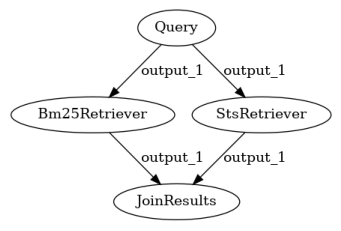

In [ ]:
util_pipeline.imprime_pipe(pipe_join_sts_multihop_bm25)

# Experiments

In [49]:
pipes

{'indir_juris_tcu': [{'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7f376ae80b50>,
   'RETRIEVER_TYPE': 'bm25',
   'RANKER_TYPE': 'PTT5_BASE',
   'RETRIEVER_MODEL_NAME': ''}],
 'indir_juris_tcu_term': [{'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7f37611d9450>,
   'RETRIEVER_TYPE': 'bm25',
   'RANKER_TYPE': 'PTT5_BASE',
   'RETRIEVER_MODEL_NAME': ''}],
 'indir_juris_tcu_synonym': [{'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7f376b1c6c10>,
   'RETRIEVER_TYPE': 'bm25',
   'RANKER_TYPE': 'PTT5_BASE',
   'RETRIEVER_MODEL_NAME': ''}],
 'indir_juris_tcu_related_term': [{'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7f37607f1710>,
   'RETRIEVER_TYPE': 'bm25',
   'RANKER_TYPE': 'PTT5_BASE',
   'RETRIEVER_MODEL_NAME': ''}],
 'indir_juris_tcu_synonym_related_term': [{'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7f37607f18d0>,
   'RETRIEVER_TYPE': 'bm25',
   'RANKER_TYPE': 'PTT5_BASE',
   'RETRIEVER_MODEL_NAME': ''}]}

In [50]:
grid_experiment = { 
             'TOPK_RETRIEVER' : [300],
             'TOPK_RANKER' : [0],
}

In [51]:
list_experiment = [dict(zip(grid_experiment.keys(), values)) for values in product(*grid_experiment.values())]


In [52]:
print(len(list_experiment))
gc.collect()

1


84

In [53]:
len(pipes['indir_juris_tcu'])

1

In [54]:
df_search_data.head()

,ID,RELEVANCE_DICT,TEXT,SOURCE,1,2,3,4,5,6,7,8,9,10
0,1,"{21064: 3, 42166: 3, 13702: 3, 20592: 3, 15740: 3, 53641: 3, 31601: 3, 54765: 3, 20506: 3, 47161: 3, 161: 1, 11595: 1, 40647: 1, 22155: 1, 18435: 1}",técnica e preço,search log,técnica e preço - Licitação de técnica e preço,"técnica e preço - Licitação de técnica e preço, Proposta técnica","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica, Proposta de preço","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica, Proposta de preço, Preço médio","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica, Proposta de preço, Preço médio, Eficiência de custos","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica, Proposta de preço, Preço médio, Eficiência de custos, Índice de preços","técnica e preço - Licitação de técnica e preço, Proposta técnica, Tipo de licitação, Proposta, Licitação de melhor técnica, Proposta de preço, Preço médio, Eficiência de custos, Índice de preços"
1,2,"{31437: 3, 19340: 3, 77959: 3, 17289: 2, 18452: 2, 18105: 1, 19636: 1, 31274: 0, 17258: 0, 32865: 0, 19738: 0, 104484: 0, 90647: 0, 21876: 0, 33096: 0}",restos a pagar,search log,restos a pagar - Cota-parte,"restos a pagar - Cota-parte, Recolhimento","restos a pagar - Cota-parte, Recolhimento, Quitação","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante, Despesas de exercícios anteriores","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante, Despesas de exercícios anteriores, Ativo compensado","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante, Despesas de exercícios anteriores, Ativo compensado, Dívida","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante, Despesas de exercícios anteriores, Ativo compensado, Dívida, Despesa empenhada","restos a pagar - Cota-parte, Recolhimento, Quitação, Passivo compensado, Passivo circulante, Despesas de exercícios anteriores, Ativo compensado, Dívida, Despesa empenhada"
2,3,"{18380: 3, 31102: 3, 17240: 3, 20511: 3, 32589: 3, 20510: 3, 17816: 3, 18058: 2, 17225: 2, 57354: 2, 18003: 2, 3881: 2, 31096: 1, 20901: 1, 11621: 1}",aditivo a contrato,search log,aditivo a contrato - Termo aditivo,"aditivo a contrato - Termo aditivo, Aditivo qualitativo","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação)","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação), Alteração contratual","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação), Alteração contratual, Ajuste","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação), Alteração contratual, Ajuste, Jogo de planilhas","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação), Alteração contratual, Ajuste, Jogo de planilhas, Acréscimo","aditivo a contrato - Termo aditivo, Aditivo qualitativo, Aditivo quantitativo, Apostila (Licitação), Alteração contratual, Ajuste, Jogo de planilhas, Acréscimo, Apostilamento","aditiv

In [ ]:
raise Exception ('Stop execution - create only desired pipelines in code below ')

Exception: Stop execution - create only desired pipelines in code below 

In [ ]:
importlib.reload(util_experiment)

<module 'util.util_experiment_juris_tcu' from '/home/borela/fontes/ind-ir/code/util/util_experiment_juris_tcu.py'>

In [55]:
consider_run_all = True

In [56]:
EXPANSOR_CRITERIA, ranker_type

('join_30_ptt5_base', 'PTT5_BASE')

In [57]:
pipes['indir_juris_tcu']

[{'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7f376ae80b50>,
  'RETRIEVER_TYPE': 'bm25',
  'RANKER_TYPE': 'PTT5_BASE',
  'RETRIEVER_MODEL_NAME': ''}]

In [58]:
assert pipes['indir_juris_tcu'][0]['RETRIEVER_TYPE']=='bm25', "For comparison, use bm25"

In [59]:
%%time
cnt_restart=13
# colocar pequeno só para testes, depois voltar para 9999999 (número maior do que o número de termos a pesquisar)
if consider_run_all:
    target_columns = df_search_data.columns.difference(['ID', 'RELEVANCE_DICT', 'SOURCE'])
elif consider_query_expanded:
    target_columns = df_search_data.columns.difference(['ID', 'RELEVANCE_DICT', 'SOURCE', 'TEXT'])
else:
    target_columns = ['TEXT']
limit_query =  9999999 # 100 # 
cnt_exec = 0
print('target_columns', target_columns)
for index_name in pipes.keys():
    for pipe in pipes[index_name]:
        for cnt, experiment in enumerate(list_experiment):
            # raise Exception('false break')            
            for column_name in target_columns:
                cnt_exec += 1
                if cnt_exec < cnt_restart:
                    print(f"=={cnt_exec}== SKIPED ==  {time.strftime('%Y-%b-%d %H:%M:%S')} \nExperiment: {experiment}")
                    continue
                if column_name == 'TEXT':
                    experiment['EXPANSOR_CRITERIA'] = ""
                else:
                    experiment['EXPANSOR_CRITERIA'] = EXPANSOR_CRITERIA
                experiment['INDEX_NAME'] = index_name
                experiment['PIPE'] = pipe
                experiment['COLUMN_NAME'] = column_name
                print(f"=={cnt_exec}==  {time.strftime('%Y-%b-%d %H:%M:%S')} \nExperiment: {experiment}")
                list_result_experiment = [] # por experiment
                result_run = util_experiment.experiment_run(parm_df=df_search_data, 
                                                        parm_experiment=experiment,
                                                        parm_limit_query=limit_query,
                                                        parm_print=True)
                # raise Exception('false break')
                list_result_experiment.append(result_run)
                # print(f"qtd_encontrado sim:{result_run['qtd_encontrado']}, não:{result_run['qtd_nao_encontrado']} ({result_run['percent_nao_encontrado']}%)")
                util_experiment.add_experiment_result(parm_list_result=list_result_experiment, parm_dataset='juris_tcu')
                torch.cuda.empty_cache()

target_columns Index(['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'TEXT'], dtype='object')
==1== SKIPED ==  2023-Jun-30 10:08:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0}
==2== SKIPED ==  2023-Jun-30 10:08:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0}
==3== SKIPED ==  2023-Jun-30 10:08:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0}
==4== SKIPED ==  2023-Jun-30 10:08:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0}
==5== SKIPED ==  2023-Jun-30 10:08:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0}
==6== SKIPED ==  2023-Jun-30 10:08:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0}
==7== SKIPED ==  2023-Jun-30 10:08:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0}
==8== SKIPED ==  2023-Jun-30 10:08:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0}
==9== SKIPED ==  2023-Jun-30 10:08:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0}
==10== SKIPED ==  2023-Jun-30 10:08:43 
Experiment: {'TOPK_RETRIE

100%|██████████| 150/150 [03:09<00:00,  1.26s/it]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 1.805
NDCG@5_MEAN: 67.243
NDCG@10_MEAN: 63.7
NDCG@15_MEAN: 66.491
NDCG@20_MEAN: 69.033
PRECISION@50_MEAN: 14.827
PRECISION@100_MEAN: 7.68
RECALL@50_MEAN: 87.064
RECALL@100_MEAN: 90.066
TIME_SPENT_MEAN: 1.263
==14==  2023-Jun-30 10:11:55 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37611d9450>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:42<00:00,  1.08s/it]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.46
NDCG@5_MEAN: 65.648
NDCG@10_MEAN: 61.948
NDCG@15_MEAN: 65.256
NDCG@20_MEAN: 68.11
PRECISION@50_MEAN: 14.747
PRECISION@100_MEAN: 7.787
RECALL@50_MEAN: 86.536
RECALL@100_MEAN: 90.981
TIME_SPENT_MEAN: 1.082
==15==  2023-Jun-30 10:14:39 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37611d9450>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:47<00:00,  1.11s/it]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.073
NDCG@5_MEAN: 67.146
NDCG@10_MEAN: 63.572
NDCG@15_MEAN: 66.21
NDCG@20_MEAN: 69.081
PRECISION@50_MEAN: 14.707
PRECISION@100_MEAN: 7.753
RECALL@50_MEAN: 86.466
RECALL@100_MEAN: 90.788
TIME_SPENT_MEAN: 1.113
==16==  2023-Jun-30 10:17:29 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37611d9450>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:50<00:00,  1.14s/it]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.207
NDCG@5_MEAN: 67.333
NDCG@10_MEAN: 63.385
NDCG@15_MEAN: 66.423
NDCG@20_MEAN: 69.127
PRECISION@50_MEAN: 14.707
PRECISION@100_MEAN: 7.747
RECALL@50_MEAN: 86.601
RECALL@100_MEAN: 90.864
TIME_SPENT_MEAN: 1.139
==17==  2023-Jun-30 10:20:22 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37611d9450>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:55<00:00,  1.17s/it]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.787
NDCG@5_MEAN: 67.996
NDCG@10_MEAN: 64.27
NDCG@15_MEAN: 66.955
NDCG@20_MEAN: 69.969
PRECISION@50_MEAN: 14.907
PRECISION@100_MEAN: 7.8
RECALL@50_MEAN: 87.533
RECALL@100_MEAN: 91.451
TIME_SPENT_MEAN: 1.172
==18==  2023-Jun-30 10:23:20 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37611d9450>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:59<00:00,  1.20s/it]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.8
NDCG@5_MEAN: 68.603
NDCG@10_MEAN: 64.255
NDCG@15_MEAN: 67.66
NDCG@20_MEAN: 70.325
PRECISION@50_MEAN: 14.96
PRECISION@100_MEAN: 7.8
RECALL@50_MEAN: 87.947
RECALL@100_MEAN: 91.572
TIME_SPENT_MEAN: 1.199
==19==  2023-Jun-30 10:26:22 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37611d9450>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:04<00:00,  1.23s/it]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 1.758
NDCG@5_MEAN: 68.392
NDCG@10_MEAN: 63.899
NDCG@15_MEAN: 67.392
NDCG@20_MEAN: 69.873
PRECISION@50_MEAN: 14.88
PRECISION@100_MEAN: 7.787
RECALL@50_MEAN: 87.578
RECALL@100_MEAN: 91.302
TIME_SPENT_MEAN: 1.227
==20==  2023-Jun-30 10:29:28 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37611d9450>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:07<00:00,  1.25s/it]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 1.886
NDCG@5_MEAN: 68.504
NDCG@10_MEAN: 63.738
NDCG@15_MEAN: 66.929
NDCG@20_MEAN: 69.486
PRECISION@50_MEAN: 14.867
PRECISION@100_MEAN: 7.72
RECALL@50_MEAN: 87.28
RECALL@100_MEAN: 90.486
TIME_SPENT_MEAN: 1.248
==21==  2023-Jun-30 10:32:38 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37611d9450>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:10<00:00,  1.27s/it]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 1.805
NDCG@5_MEAN: 67.75
NDCG@10_MEAN: 63.567
NDCG@15_MEAN: 66.767
NDCG@20_MEAN: 69.498
PRECISION@50_MEAN: 14.827
PRECISION@100_MEAN: 7.7
RECALL@50_MEAN: 87.077
RECALL@100_MEAN: 90.281
TIME_SPENT_MEAN: 1.269
==22==  2023-Jun-30 10:35:50 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37611d9450>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:33<00:00,  1.02s/it]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: 
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.267
NDCG@5_MEAN: 74.089
NDCG@10_MEAN: 70.659
NDCG@15_MEAN: 74.363
NDCG@20_MEAN: 76.604
PRECISION@50_MEAN: 15.787
PRECISION@100_MEAN: 8.02
RECALL@50_MEAN: 91.546
RECALL@100_MEAN: 93.003
TIME_SPENT_MEAN: 1.024
==23==  2023-Jun-30 10:38:26 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f376b1c6c10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:50<00:00,  1.53s/it]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.387
NDCG@5_MEAN: 59.509
NDCG@10_MEAN: 56.893
NDCG@15_MEAN: 60.442
NDCG@20_MEAN: 63.236
PRECISION@50_MEAN: 14.08
PRECISION@100_MEAN: 7.62
RECALL@50_MEAN: 82.83
RECALL@100_MEAN: 89.029
TIME_SPENT_MEAN: 1.534
==24==  2023-Jun-30 10:42:19 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f376b1c6c10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:38<00:00,  1.86s/it]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 2.624
NDCG@5_MEAN: 64.519
NDCG@10_MEAN: 61.359
NDCG@15_MEAN: 64.439
NDCG@20_MEAN: 66.55
PRECISION@50_MEAN: 14.0
PRECISION@100_MEAN: 7.307
RECALL@50_MEAN: 82.944
RECALL@100_MEAN: 86.158
TIME_SPENT_MEAN: 1.856
==25==  2023-Jun-30 10:46:59 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f376b1c6c10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:59<00:00,  1.59s/it]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.18
NDCG@5_MEAN: 61.589
NDCG@10_MEAN: 57.42
NDCG@15_MEAN: 61.054
NDCG@20_MEAN: 63.789
PRECISION@50_MEAN: 14.04
PRECISION@100_MEAN: 7.593
RECALL@50_MEAN: 82.634
RECALL@100_MEAN: 88.57
TIME_SPENT_MEAN: 1.593
==26==  2023-Jun-30 10:51:01 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f376b1c6c10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:05<00:00,  1.64s/it]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.067
NDCG@5_MEAN: 62.286
NDCG@10_MEAN: 59.612
NDCG@15_MEAN: 62.791
NDCG@20_MEAN: 65.198
PRECISION@50_MEAN: 14.133
PRECISION@100_MEAN: 7.56
RECALL@50_MEAN: 83.025
RECALL@100_MEAN: 88.162
TIME_SPENT_MEAN: 1.638
==27==  2023-Jun-30 10:55:09 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f376b1c6c10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:10<00:00,  1.67s/it]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.033
NDCG@5_MEAN: 63.767
NDCG@10_MEAN: 60.316
NDCG@15_MEAN: 63.588
NDCG@20_MEAN: 66.245
PRECISION@50_MEAN: 14.453
PRECISION@100_MEAN: 7.613
RECALL@50_MEAN: 85.079
RECALL@100_MEAN: 89.31
TIME_SPENT_MEAN: 1.672
==28==  2023-Jun-30 10:59:22 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f376b1c6c10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:18<00:00,  1.72s/it]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 2.195
NDCG@5_MEAN: 64.594
NDCG@10_MEAN: 61.062
NDCG@15_MEAN: 64.64
NDCG@20_MEAN: 66.953
PRECISION@50_MEAN: 14.373
PRECISION@100_MEAN: 7.507
RECALL@50_MEAN: 84.933
RECALL@100_MEAN: 88.324
TIME_SPENT_MEAN: 1.724
==29==  2023-Jun-30 11:03:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f376b1c6c10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:23<00:00,  1.76s/it]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 2.517
NDCG@5_MEAN: 65.231
NDCG@10_MEAN: 61.111
NDCG@15_MEAN: 65.113
NDCG@20_MEAN: 67.362
PRECISION@50_MEAN: 14.293
PRECISION@100_MEAN: 7.507
RECALL@50_MEAN: 84.56
RECALL@100_MEAN: 88.489
TIME_SPENT_MEAN: 1.758
==30==  2023-Jun-30 11:08:09 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f376b1c6c10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:29<00:00,  1.79s/it]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 2.55
NDCG@5_MEAN: 66.155
NDCG@10_MEAN: 61.667
NDCG@15_MEAN: 65.613
NDCG@20_MEAN: 67.815
PRECISION@50_MEAN: 14.36
PRECISION@100_MEAN: 7.507
RECALL@50_MEAN: 84.937
RECALL@100_MEAN: 88.381
TIME_SPENT_MEAN: 1.794
==31==  2023-Jun-30 11:12:40 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f376b1c6c10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:33<00:00,  1.82s/it]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 2.785
NDCG@5_MEAN: 65.89
NDCG@10_MEAN: 61.863
NDCG@15_MEAN: 64.96
NDCG@20_MEAN: 67.326
PRECISION@50_MEAN: 14.12
PRECISION@100_MEAN: 7.4
RECALL@50_MEAN: 83.704
RECALL@100_MEAN: 87.194
TIME_SPENT_MEAN: 1.821
==32==  2023-Jun-30 11:17:16 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f376b1c6c10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:36<00:00,  1.84s/it]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 2.658
NDCG@5_MEAN: 65.279
NDCG@10_MEAN: 61.74
NDCG@15_MEAN: 65.147
NDCG@20_MEAN: 67.057
PRECISION@50_MEAN: 14.16
PRECISION@100_MEAN: 7.373
RECALL@50_MEAN: 83.791
RECALL@100_MEAN: 86.893
TIME_SPENT_MEAN: 1.843
==33==  2023-Jun-30 11:21:55 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f376b1c6c10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: 
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.34
NDCG@5_MEAN: 71.497
NDCG@10_MEAN: 67.387
NDCG@15_MEAN: 70.536
NDCG@20_MEAN: 73.291
PRECISION@50_MEAN: 15.347
PRECISION@100_MEAN: 7.96
RECALL@50_MEAN: 89.255
RECALL@100_MEAN: 92.337
TIME_SPENT_MEAN: 1.479
==34==  2023-Jun-30 11:25:39 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37607f1710>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [08:39<00:00,  3.46s/it]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 2.537
NDCG@5_MEAN: 60.466
NDCG@10_MEAN: 56.976
NDCG@15_MEAN: 59.809
NDCG@20_MEAN: 62.229
PRECISION@50_MEAN: 13.88
PRECISION@100_MEAN: 7.48
RECALL@50_MEAN: 81.421
RECALL@100_MEAN: 86.912
TIME_SPENT_MEAN: 3.463
==35==  2023-Jun-30 11:34:20 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37607f1710>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:50<00:00,  3.94s/it]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 2.02
NDCG@5_MEAN: 64.464
NDCG@10_MEAN: 60.205
NDCG@15_MEAN: 63.122
NDCG@20_MEAN: 65.389
PRECISION@50_MEAN: 13.587
PRECISION@100_MEAN: 7.127
RECALL@50_MEAN: 80.83
RECALL@100_MEAN: 84.335
TIME_SPENT_MEAN: 3.935
==36==  2023-Jun-30 11:44:13 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37607f1710>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [08:55<00:00,  3.57s/it]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 2.608
NDCG@5_MEAN: 58.876
NDCG@10_MEAN: 55.848
NDCG@15_MEAN: 58.49
NDCG@20_MEAN: 60.655
PRECISION@50_MEAN: 13.693
PRECISION@100_MEAN: 7.42
RECALL@50_MEAN: 80.647
RECALL@100_MEAN: 86.626
TIME_SPENT_MEAN: 3.567
==37==  2023-Jun-30 11:53:10 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37607f1710>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:05<00:00,  3.64s/it]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 2.277
NDCG@5_MEAN: 60.255
NDCG@10_MEAN: 57.115
NDCG@15_MEAN: 60.291
NDCG@20_MEAN: 62.482
PRECISION@50_MEAN: 13.68
PRECISION@100_MEAN: 7.393
RECALL@50_MEAN: 80.813
RECALL@100_MEAN: 86.573
TIME_SPENT_MEAN: 3.637
==38==  2023-Jun-30 12:02:18 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37607f1710>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:14<00:00,  3.70s/it]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 2.223
NDCG@5_MEAN: 60.424
NDCG@10_MEAN: 56.808
NDCG@15_MEAN: 60.27
NDCG@20_MEAN: 62.79
PRECISION@50_MEAN: 13.6
PRECISION@100_MEAN: 7.36
RECALL@50_MEAN: 80.366
RECALL@100_MEAN: 85.997
TIME_SPENT_MEAN: 3.695
==39==  2023-Jun-30 12:11:35 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37607f1710>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:24<00:00,  3.76s/it]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 1.676
NDCG@5_MEAN: 62.288
NDCG@10_MEAN: 58.345
NDCG@15_MEAN: 61.426
NDCG@20_MEAN: 64.107
PRECISION@50_MEAN: 13.827
PRECISION@100_MEAN: 7.367
RECALL@50_MEAN: 81.651
RECALL@100_MEAN: 86.15
TIME_SPENT_MEAN: 3.764
==40==  2023-Jun-30 12:21:02 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37607f1710>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:31<00:00,  3.81s/it]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 1.741
NDCG@5_MEAN: 61.593
NDCG@10_MEAN: 58.175
NDCG@15_MEAN: 61.16
NDCG@20_MEAN: 63.721
PRECISION@50_MEAN: 13.68
PRECISION@100_MEAN: 7.24
RECALL@50_MEAN: 81.052
RECALL@100_MEAN: 85.237
TIME_SPENT_MEAN: 3.813
==41==  2023-Jun-30 12:30:36 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37607f1710>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:42<00:00,  3.88s/it]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 2.405
NDCG@5_MEAN: 61.54
NDCG@10_MEAN: 58.136
NDCG@15_MEAN: 61.217
NDCG@20_MEAN: 63.591
PRECISION@50_MEAN: 13.533
PRECISION@100_MEAN: 7.133
RECALL@50_MEAN: 80.391
RECALL@100_MEAN: 84.306
TIME_SPENT_MEAN: 3.883
==42==  2023-Jun-30 12:40:22 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37607f1710>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:52<00:00,  3.95s/it]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 2.047
NDCG@5_MEAN: 64.363
NDCG@10_MEAN: 59.493
NDCG@15_MEAN: 62.374
NDCG@20_MEAN: 64.945
PRECISION@50_MEAN: 13.507
PRECISION@100_MEAN: 7.147
RECALL@50_MEAN: 80.387
RECALL@100_MEAN: 84.6
TIME_SPENT_MEAN: 3.949
==43==  2023-Jun-30 12:50:17 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f37607f1710>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


 71%|███████▏  | 107/150 [10:12<04:18,  6.01s/it]

In [ ]:
%%time
# colocar pequeno só para testes, depois voltar para 9999999 (número maior do que o número de termos a pesquisar)
if consider_run_all:
    target_columns = df_search_data.columns.difference(['ID', 'RELEVANCE_DICT', 'SOURCE'])
elif consider_query_expanded:
    target_columns = df_search_data.columns.difference(['ID', 'RELEVANCE_DICT', 'SOURCE', 'TEXT'])
else:
    target_columns = ['TEXT']
limit_query =  9999999 # 100 # 
cnt_exec = 0
print('target_columns', target_columns)
for index_name in pipes.keys():
    for pipe in pipes[index_name]:
        for cnt, experiment in enumerate(list_experiment):
            # raise Exception('false break')            
            for column_name in target_columns:
                cnt_exec += 1
                if column_name == 'TEXT':
                    experiment['EXPANSOR_CRITERIA'] = ""
                else:
                    experiment['EXPANSOR_CRITERIA'] = EXPANSOR_CRITERIA
                experiment['INDEX_NAME'] = index_name
                experiment['PIPE'] = pipe
                experiment['COLUMN_NAME'] = column_name
                print(f"=={cnt_exec}==  {time.strftime('%Y-%b-%d %H:%M:%S')} \nExperiment: {experiment}")
                list_result_experiment = [] # por experiment
                result_run = util_experiment.experiment_run(parm_df=df_search_data, 
                                                        parm_experiment=experiment,
                                                        parm_limit_query=limit_query,
                                                        parm_print=True)
                # raise Exception('false break')
                list_result_experiment.append(result_run)
                # print(f"qtd_encontrado sim:{result_run['qtd_encontrado']}, não:{result_run['qtd_nao_encontrado']} ({result_run['percent_nao_encontrado']}%)")
                util_experiment.add_experiment_result(parm_list_result=list_result_experiment, parm_dataset='juris_tcu')
                torch.cuda.empty_cache()

target_columns Index(['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'TEXT'], dtype='object')
==1==  2023-Jun-29 08:50:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b4bc5390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:15<00:00,  1.11it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 1.738
NDCG@5_MEAN: 69.853
NDCG@10_MEAN: 66.112
NDCG@15_MEAN: 69.227
NDCG@20_MEAN: 70.955
PRECISION@50_MEAN: 14.653
PRECISION@100_MEAN: 7.607
RECALL@50_MEAN: 85.706
RECALL@100_MEAN: 88.677
TIME_SPENT_MEAN: 0.9
==2==  2023-Jun-29 08:53:01 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b4bc5390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:41<00:00,  1.08s/it]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.373
NDCG@5_MEAN: 67.483
NDCG@10_MEAN: 64.078
NDCG@15_MEAN: 66.877
NDCG@20_MEAN: 69.53
PRECISION@50_MEAN: 14.48
PRECISION@100_MEAN: 7.44
RECALL@50_MEAN: 84.898
RECALL@100_MEAN: 87.138
TIME_SPENT_MEAN: 1.079
==3==  2023-Jun-29 08:55:45 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b4bc5390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:20<00:00,  1.07it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.867
NDCG@5_MEAN: 69.144
NDCG@10_MEAN: 64.72
NDCG@15_MEAN: 67.199
NDCG@20_MEAN: 69.725
PRECISION@50_MEAN: 14.267
PRECISION@100_MEAN: 7.493
RECALL@50_MEAN: 83.601
RECALL@100_MEAN: 87.608
TIME_SPENT_MEAN: 0.939
==4==  2023-Jun-29 08:58:08 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b4bc5390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:25<00:00,  1.03it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.74
NDCG@5_MEAN: 67.434
NDCG@10_MEAN: 63.166
NDCG@15_MEAN: 66.446
NDCG@20_MEAN: 68.698
PRECISION@50_MEAN: 14.48
PRECISION@100_MEAN: 7.473
RECALL@50_MEAN: 84.474
RECALL@100_MEAN: 87.013
TIME_SPENT_MEAN: 0.967
==5==  2023-Jun-29 09:00:36 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b4bc5390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:28<00:00,  1.01it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.64
NDCG@5_MEAN: 68.007
NDCG@10_MEAN: 63.846
NDCG@15_MEAN: 66.695
NDCG@20_MEAN: 68.998
PRECISION@50_MEAN: 14.56
PRECISION@100_MEAN: 7.533
RECALL@50_MEAN: 84.884
RECALL@100_MEAN: 87.439
TIME_SPENT_MEAN: 0.992
==6==  2023-Jun-29 09:03:07 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b4bc5390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:32<00:00,  1.02s/it]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 1.47
NDCG@5_MEAN: 66.289
NDCG@10_MEAN: 63.024
NDCG@15_MEAN: 66.142
NDCG@20_MEAN: 68.544
PRECISION@50_MEAN: 14.427
PRECISION@100_MEAN: 7.48
RECALL@50_MEAN: 84.242
RECALL@100_MEAN: 87.067
TIME_SPENT_MEAN: 1.018
==7==  2023-Jun-29 09:05:42 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b4bc5390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:35<00:00,  1.04s/it]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.393
NDCG@5_MEAN: 66.991
NDCG@10_MEAN: 63.437
NDCG@15_MEAN: 66.343
NDCG@20_MEAN: 68.898
PRECISION@50_MEAN: 14.307
PRECISION@100_MEAN: 7.407
RECALL@50_MEAN: 83.509
RECALL@100_MEAN: 86.305
TIME_SPENT_MEAN: 1.038
==8==  2023-Jun-29 09:08:21 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b4bc5390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:39<00:00,  1.06s/it]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 1.342
NDCG@5_MEAN: 67.661
NDCG@10_MEAN: 64.481
NDCG@15_MEAN: 66.837
NDCG@20_MEAN: 69.295
PRECISION@50_MEAN: 14.36
PRECISION@100_MEAN: 7.42
RECALL@50_MEAN: 84.26
RECALL@100_MEAN: 86.759
TIME_SPENT_MEAN: 1.062
==9==  2023-Jun-29 09:11:02 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b4bc5390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:41<00:00,  1.08s/it]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.28
NDCG@5_MEAN: 68.149
NDCG@10_MEAN: 64.829
NDCG@15_MEAN: 67.326
NDCG@20_MEAN: 69.665
PRECISION@50_MEAN: 14.48
PRECISION@100_MEAN: 7.46
RECALL@50_MEAN: 84.952
RECALL@100_MEAN: 87.346
TIME_SPENT_MEAN: 1.079
==10==  2023-Jun-29 09:13:47 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b4bc5390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:43<00:00,  1.09s/it]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.287
NDCG@5_MEAN: 67.363
NDCG@10_MEAN: 64.269
NDCG@15_MEAN: 67.071
NDCG@20_MEAN: 69.672
PRECISION@50_MEAN: 14.493
PRECISION@100_MEAN: 7.467
RECALL@50_MEAN: 84.976
RECALL@100_MEAN: 87.398
TIME_SPENT_MEAN: 1.09
==11==  2023-Jun-29 09:16:33 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b4bc5390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:11<00:00,  1.14it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: 
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.147
NDCG@5_MEAN: 76.271
NDCG@10_MEAN: 72.957
NDCG@15_MEAN: 75.535
NDCG@20_MEAN: 77.81
PRECISION@50_MEAN: 15.507
PRECISION@100_MEAN: 7.827
RECALL@50_MEAN: 90.356
RECALL@100_MEAN: 91.082
TIME_SPENT_MEAN: 0.874
==12==  2023-Jun-29 09:18:47 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b6241b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:35<00:00,  1.04s/it]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.853
NDCG@5_MEAN: 69.617
NDCG@10_MEAN: 65.404
NDCG@15_MEAN: 68.297
NDCG@20_MEAN: 71.113
PRECISION@50_MEAN: 15.027
PRECISION@100_MEAN: 7.84
RECALL@50_MEAN: 87.641
RECALL@100_MEAN: 91.235
TIME_SPENT_MEAN: 1.04
==13==  2023-Jun-29 09:21:25 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b6241b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:02<00:00,  1.22s/it]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.547
NDCG@5_MEAN: 66.079
NDCG@10_MEAN: 63.743
NDCG@15_MEAN: 66.998
NDCG@20_MEAN: 69.487
PRECISION@50_MEAN: 15.093
PRECISION@100_MEAN: 7.82
RECALL@50_MEAN: 88.021
RECALL@100_MEAN: 91.036
TIME_SPENT_MEAN: 1.219
==14==  2023-Jun-29 09:24:31 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b6241b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:40<00:00,  1.07s/it]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.547
NDCG@5_MEAN: 67.323
NDCG@10_MEAN: 64.016
NDCG@15_MEAN: 66.72
NDCG@20_MEAN: 69.449
PRECISION@50_MEAN: 14.8
PRECISION@100_MEAN: 7.713
RECALL@50_MEAN: 86.735
RECALL@100_MEAN: 90.338
TIME_SPENT_MEAN: 1.071
==15==  2023-Jun-29 09:27:14 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b6241b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:44<00:00,  1.10s/it]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.18
NDCG@5_MEAN: 65.778
NDCG@10_MEAN: 63.052
NDCG@15_MEAN: 65.753
NDCG@20_MEAN: 68.794
PRECISION@50_MEAN: 14.867
PRECISION@100_MEAN: 7.787
RECALL@50_MEAN: 86.836
RECALL@100_MEAN: 90.726
TIME_SPENT_MEAN: 1.097
==16==  2023-Jun-29 09:30:01 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b6241b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:47<00:00,  1.11s/it]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.26
NDCG@5_MEAN: 66.737
NDCG@10_MEAN: 63.264
NDCG@15_MEAN: 65.605
NDCG@20_MEAN: 69.024
PRECISION@50_MEAN: 14.84
PRECISION@100_MEAN: 7.747
RECALL@50_MEAN: 87.111
RECALL@100_MEAN: 90.542
TIME_SPENT_MEAN: 1.114
==17==  2023-Jun-29 09:32:51 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b6241b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:51<00:00,  1.14s/it]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 1.987
NDCG@5_MEAN: 65.995
NDCG@10_MEAN: 62.74
NDCG@15_MEAN: 65.913
NDCG@20_MEAN: 68.742
PRECISION@50_MEAN: 14.88
PRECISION@100_MEAN: 7.773
RECALL@50_MEAN: 87.257
RECALL@100_MEAN: 90.809
TIME_SPENT_MEAN: 1.14
==18==  2023-Jun-29 09:35:44 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b6241b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:54<00:00,  1.16s/it]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.613
NDCG@5_MEAN: 66.641
NDCG@10_MEAN: 63.562
NDCG@15_MEAN: 66.534
NDCG@20_MEAN: 69.182
PRECISION@50_MEAN: 15.067
PRECISION@100_MEAN: 7.82
RECALL@50_MEAN: 88.365
RECALL@100_MEAN: 91.309
TIME_SPENT_MEAN: 1.162
==19==  2023-Jun-29 09:38:41 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b6241b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:58<00:00,  1.19s/it]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.6
NDCG@5_MEAN: 66.443
NDCG@10_MEAN: 64.051
NDCG@15_MEAN: 67.225
NDCG@20_MEAN: 69.725
PRECISION@50_MEAN: 14.96
PRECISION@100_MEAN: 7.793
RECALL@50_MEAN: 87.386
RECALL@100_MEAN: 90.806
TIME_SPENT_MEAN: 1.189
==20==  2023-Jun-29 09:41:42 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b6241b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:00<00:00,  1.20s/it]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.58
NDCG@5_MEAN: 66.523
NDCG@10_MEAN: 63.86
NDCG@15_MEAN: 67.123
NDCG@20_MEAN: 69.552
PRECISION@50_MEAN: 14.987
PRECISION@100_MEAN: 7.8
RECALL@50_MEAN: 87.538
RECALL@100_MEAN: 90.835
TIME_SPENT_MEAN: 1.202
==21==  2023-Jun-29 09:44:45 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b6241b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:01<00:00,  1.21s/it]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.56
NDCG@5_MEAN: 66.196
NDCG@10_MEAN: 63.773
NDCG@15_MEAN: 67.147
NDCG@20_MEAN: 69.57
PRECISION@50_MEAN: 15.053
PRECISION@100_MEAN: 7.813
RECALL@50_MEAN: 87.833
RECALL@100_MEAN: 90.969
TIME_SPENT_MEAN: 1.213
==22==  2023-Jun-29 09:47:50 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b6241b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:32<00:00,  1.02s/it]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: 
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.267
NDCG@5_MEAN: 74.089
NDCG@10_MEAN: 70.659
NDCG@15_MEAN: 74.363
NDCG@20_MEAN: 76.604
PRECISION@50_MEAN: 15.787
PRECISION@100_MEAN: 8.02
RECALL@50_MEAN: 91.546
RECALL@100_MEAN: 93.003
TIME_SPENT_MEAN: 1.018
==23==  2023-Jun-29 09:50:25 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62b6390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:49<00:00,  1.53s/it]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.607
NDCG@5_MEAN: 62.594
NDCG@10_MEAN: 59.43
NDCG@15_MEAN: 62.923
NDCG@20_MEAN: 65.577
PRECISION@50_MEAN: 14.427
PRECISION@100_MEAN: 7.68
RECALL@50_MEAN: 84.7
RECALL@100_MEAN: 89.543
TIME_SPENT_MEAN: 1.531
==24==  2023-Jun-29 09:54:17 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62b6390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:28<00:00,  1.79s/it]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.593
NDCG@5_MEAN: 65.552
NDCG@10_MEAN: 62.073
NDCG@15_MEAN: 64.858
NDCG@20_MEAN: 67.24
PRECISION@50_MEAN: 13.92
PRECISION@100_MEAN: 7.347
RECALL@50_MEAN: 81.899
RECALL@100_MEAN: 86.35
TIME_SPENT_MEAN: 1.793
==25==  2023-Jun-29 09:58:49 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62b6390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:56<00:00,  1.58s/it]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.213
NDCG@5_MEAN: 61.51
NDCG@10_MEAN: 57.925
NDCG@15_MEAN: 61.553
NDCG@20_MEAN: 64.07
PRECISION@50_MEAN: 14.133
PRECISION@100_MEAN: 7.513
RECALL@50_MEAN: 83.118
RECALL@100_MEAN: 87.964
TIME_SPENT_MEAN: 1.578
==26==  2023-Jun-29 10:02:48 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62b6390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:01<00:00,  1.61s/it]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.647
NDCG@5_MEAN: 61.374
NDCG@10_MEAN: 58.337
NDCG@15_MEAN: 61.94
NDCG@20_MEAN: 64.913
PRECISION@50_MEAN: 14.147
PRECISION@100_MEAN: 7.507
RECALL@50_MEAN: 83.316
RECALL@100_MEAN: 88.023
TIME_SPENT_MEAN: 1.611
==27==  2023-Jun-29 10:06:53 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62b6390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:06<00:00,  1.64s/it]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.667
NDCG@5_MEAN: 63.273
NDCG@10_MEAN: 59.703
NDCG@15_MEAN: 63.125
NDCG@20_MEAN: 65.945
PRECISION@50_MEAN: 14.2
PRECISION@100_MEAN: 7.493
RECALL@50_MEAN: 83.797
RECALL@100_MEAN: 87.816
TIME_SPENT_MEAN: 1.642
==28==  2023-Jun-29 10:11:02 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62b6390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:12<00:00,  1.68s/it]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 2.047
NDCG@5_MEAN: 64.541
NDCG@10_MEAN: 60.396
NDCG@15_MEAN: 63.855
NDCG@20_MEAN: 66.342
PRECISION@50_MEAN: 14.2
PRECISION@100_MEAN: 7.48
RECALL@50_MEAN: 83.805
RECALL@100_MEAN: 87.859
TIME_SPENT_MEAN: 1.684
==29==  2023-Jun-29 10:15:17 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62b6390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:17<00:00,  1.72s/it]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.64
NDCG@5_MEAN: 63.867
NDCG@10_MEAN: 60.904
NDCG@15_MEAN: 63.783
NDCG@20_MEAN: 66.415
PRECISION@50_MEAN: 14.24
PRECISION@100_MEAN: 7.433
RECALL@50_MEAN: 83.788
RECALL@100_MEAN: 87.139
TIME_SPENT_MEAN: 1.717
==30==  2023-Jun-29 10:19:37 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62b6390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:22<00:00,  1.75s/it]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.693
NDCG@5_MEAN: 63.843
NDCG@10_MEAN: 60.879
NDCG@15_MEAN: 63.889
NDCG@20_MEAN: 66.296
PRECISION@50_MEAN: 13.973
PRECISION@100_MEAN: 7.4
RECALL@50_MEAN: 81.944
RECALL@100_MEAN: 86.757
TIME_SPENT_MEAN: 1.749
==31==  2023-Jun-29 10:24:03 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62b6390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:26<00:00,  1.78s/it]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.547
NDCG@5_MEAN: 66.087
NDCG@10_MEAN: 62.097
NDCG@15_MEAN: 64.78
NDCG@20_MEAN: 67.145
PRECISION@50_MEAN: 13.947
PRECISION@100_MEAN: 7.373
RECALL@50_MEAN: 81.987
RECALL@100_MEAN: 86.538
TIME_SPENT_MEAN: 1.775
==32==  2023-Jun-29 10:28:31 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62b6390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:29<00:00,  1.80s/it]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.587
NDCG@5_MEAN: 65.637
NDCG@10_MEAN: 61.969
NDCG@15_MEAN: 64.791
NDCG@20_MEAN: 67.157
PRECISION@50_MEAN: 13.92
PRECISION@100_MEAN: 7.347
RECALL@50_MEAN: 81.899
RECALL@100_MEAN: 86.35
TIME_SPENT_MEAN: 1.797
==33==  2023-Jun-29 10:33:03 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62b6390>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: 
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.34
NDCG@5_MEAN: 71.497
NDCG@10_MEAN: 67.387
NDCG@15_MEAN: 70.536
NDCG@20_MEAN: 73.291
PRECISION@50_MEAN: 15.347
PRECISION@100_MEAN: 7.96
RECALL@50_MEAN: 89.255
RECALL@100_MEAN: 92.337
TIME_SPENT_MEAN: 1.476
==34==  2023-Jun-29 10:36:47 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62e1d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [08:35<00:00,  3.44s/it]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.087
NDCG@5_MEAN: 63.693
NDCG@10_MEAN: 60.13
NDCG@15_MEAN: 62.645
NDCG@20_MEAN: 65.351
PRECISION@50_MEAN: 14.187
PRECISION@100_MEAN: 7.52
RECALL@50_MEAN: 83.257
RECALL@100_MEAN: 87.544
TIME_SPENT_MEAN: 3.437
==35==  2023-Jun-29 10:45:25 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62e1d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:39<00:00,  3.86s/it]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 1.789
NDCG@5_MEAN: 64.949
NDCG@10_MEAN: 61.379
NDCG@15_MEAN: 63.627
NDCG@20_MEAN: 66.084
PRECISION@50_MEAN: 13.893
PRECISION@100_MEAN: 7.26
RECALL@50_MEAN: 81.711
RECALL@100_MEAN: 85.089
TIME_SPENT_MEAN: 3.863
==36==  2023-Jun-29 10:55:08 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62e1d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [08:47<00:00,  3.52s/it]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 4
RANK1_MEAN: 1.884
NDCG@5_MEAN: 60.601
NDCG@10_MEAN: 57.522
NDCG@15_MEAN: 60.657
NDCG@20_MEAN: 63.242
PRECISION@50_MEAN: 13.667
PRECISION@100_MEAN: 7.267
RECALL@50_MEAN: 80.709
RECALL@100_MEAN: 85.12
TIME_SPENT_MEAN: 3.516
==37==  2023-Jun-29 11:03:58 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62e1d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [08:52<00:00,  3.55s/it]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 4
RANK1_MEAN: 1.849
NDCG@5_MEAN: 60.031
NDCG@10_MEAN: 57.757
NDCG@15_MEAN: 60.11
NDCG@20_MEAN: 62.55
PRECISION@50_MEAN: 13.613
PRECISION@100_MEAN: 7.22
RECALL@50_MEAN: 80.568
RECALL@100_MEAN: 84.815
TIME_SPENT_MEAN: 3.547
==38==  2023-Jun-29 11:12:53 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62e1d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [08:58<00:00,  3.59s/it]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 1.707
NDCG@5_MEAN: 61.564
NDCG@10_MEAN: 58.401
NDCG@15_MEAN: 61.313
NDCG@20_MEAN: 63.882
PRECISION@50_MEAN: 13.72
PRECISION@100_MEAN: 7.24
RECALL@50_MEAN: 81.022
RECALL@100_MEAN: 84.882
TIME_SPENT_MEAN: 3.591
==39==  2023-Jun-29 11:21:54 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62e1d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:08<00:00,  3.66s/it]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 1.741
NDCG@5_MEAN: 60.993
NDCG@10_MEAN: 58.18
NDCG@15_MEAN: 61.521
NDCG@20_MEAN: 64.012
PRECISION@50_MEAN: 13.813
PRECISION@100_MEAN: 7.293
RECALL@50_MEAN: 81.492
RECALL@100_MEAN: 85.429
TIME_SPENT_MEAN: 3.656
==40==  2023-Jun-29 11:31:05 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62e1d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:19<00:00,  3.73s/it]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 1.782
NDCG@5_MEAN: 63.557
NDCG@10_MEAN: 59.78
NDCG@15_MEAN: 63.032
NDCG@20_MEAN: 65.477
PRECISION@50_MEAN: 13.813
PRECISION@100_MEAN: 7.313
RECALL@50_MEAN: 81.395
RECALL@100_MEAN: 85.529
TIME_SPENT_MEAN: 3.731
==41==  2023-Jun-29 11:40:28 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62e1d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:28<00:00,  3.79s/it]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 1.803
NDCG@5_MEAN: 63.816
NDCG@10_MEAN: 59.86
NDCG@15_MEAN: 62.773
NDCG@20_MEAN: 65.207
PRECISION@50_MEAN: 13.707
PRECISION@100_MEAN: 7.22
RECALL@50_MEAN: 80.757
RECALL@100_MEAN: 84.624
TIME_SPENT_MEAN: 3.788
==42==  2023-Jun-29 11:49:59 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62e1d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:32<00:00,  3.82s/it]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 1.823
NDCG@5_MEAN: 64.134
NDCG@10_MEAN: 60.964
NDCG@15_MEAN: 63.293
NDCG@20_MEAN: 65.655
PRECISION@50_MEAN: 13.8
PRECISION@100_MEAN: 7.247
RECALL@50_MEAN: 81.288
RECALL@100_MEAN: 84.946
TIME_SPENT_MEAN: 3.815
==43==  2023-Jun-29 11:59:33 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62e1d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:35<00:00,  3.84s/it]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 1.782
NDCG@5_MEAN: 64.815
NDCG@10_MEAN: 61.256
NDCG@15_MEAN: 63.562
NDCG@20_MEAN: 66.039
PRECISION@50_MEAN: 13.893
PRECISION@100_MEAN: 7.267
RECALL@50_MEAN: 81.711
RECALL@100_MEAN: 85.155
TIME_SPENT_MEAN: 3.836
==44==  2023-Jun-29 12:09:11 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9b62e1d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [08:25<00:00,  3.37s/it]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: 
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.513
NDCG@5_MEAN: 68.856
NDCG@10_MEAN: 64.611
NDCG@15_MEAN: 67.713
NDCG@20_MEAN: 70.457
PRECISION@50_MEAN: 14.933
PRECISION@100_MEAN: 7.713
RECALL@50_MEAN: 87.151
RECALL@100_MEAN: 89.746
TIME_SPENT_MEAN: 3.373
==45==  2023-Jun-29 12:17:40 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9ac5e4bd0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [10:30<00:00,  4.20s/it]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.267
NDCG@5_MEAN: 59.003
NDCG@10_MEAN: 56.13
NDCG@15_MEAN: 59.028
NDCG@20_MEAN: 61.921
PRECISION@50_MEAN: 13.813
PRECISION@100_MEAN: 7.393
RECALL@50_MEAN: 81.423
RECALL@100_MEAN: 86.117
TIME_SPENT_MEAN: 4.201
==46==  2023-Jun-29 12:28:13 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9ac5e4bd0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [11:26<00:00,  4.58s/it]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 1.864
NDCG@5_MEAN: 60.454
NDCG@10_MEAN: 57.27
NDCG@15_MEAN: 60.003
NDCG@20_MEAN: 62.962
PRECISION@50_MEAN: 13.587
PRECISION@100_MEAN: 7.127
RECALL@50_MEAN: 80.025
RECALL@100_MEAN: 83.549
TIME_SPENT_MEAN: 4.579
==47==  2023-Jun-29 12:39:42 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9ac5e4bd0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [10:41<00:00,  4.28s/it]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 2.15
NDCG@5_MEAN: 57.021
NDCG@10_MEAN: 54.122
NDCG@15_MEAN: 57.469
NDCG@20_MEAN: 60.418
PRECISION@50_MEAN: 13.52
PRECISION@100_MEAN: 7.253
RECALL@50_MEAN: 79.925
RECALL@100_MEAN: 84.957
TIME_SPENT_MEAN: 4.279
==48==  2023-Jun-29 12:50:27 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9ac5e4bd0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [10:47<00:00,  4.32s/it]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 1.973
NDCG@5_MEAN: 58.344
NDCG@10_MEAN: 54.774
NDCG@15_MEAN: 57.959
NDCG@20_MEAN: 60.72
PRECISION@50_MEAN: 13.493
PRECISION@100_MEAN: 7.213
RECALL@50_MEAN: 80.054
RECALL@100_MEAN: 84.618
TIME_SPENT_MEAN: 4.319
==49==  2023-Jun-29 13:01:17 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9ac5e4bd0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [10:56<00:00,  4.38s/it]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 1.939
NDCG@5_MEAN: 59.012
NDCG@10_MEAN: 56.076
NDCG@15_MEAN: 59.216
NDCG@20_MEAN: 62.018
PRECISION@50_MEAN: 13.493
PRECISION@100_MEAN: 7.187
RECALL@50_MEAN: 79.671
RECALL@100_MEAN: 84.367
TIME_SPENT_MEAN: 4.378
==50==  2023-Jun-29 13:12:16 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9ac5e4bd0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [11:03<00:00,  4.42s/it]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 1.918
NDCG@5_MEAN: 59.07
NDCG@10_MEAN: 56.409
NDCG@15_MEAN: 59.612
NDCG@20_MEAN: 62.269
PRECISION@50_MEAN: 13.573
PRECISION@100_MEAN: 7.213
RECALL@50_MEAN: 80.257
RECALL@100_MEAN: 84.693
TIME_SPENT_MEAN: 4.424
==51==  2023-Jun-29 13:23:23 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9ac5e4bd0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [11:12<00:00,  4.48s/it]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 1.939
NDCG@5_MEAN: 59.451
NDCG@10_MEAN: 57.052
NDCG@15_MEAN: 60.061
NDCG@20_MEAN: 62.869
PRECISION@50_MEAN: 13.493
PRECISION@100_MEAN: 7.2
RECALL@50_MEAN: 79.605
RECALL@100_MEAN: 84.258
TIME_SPENT_MEAN: 4.483
==52==  2023-Jun-29 13:34:38 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9ac5e4bd0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [11:15<00:00,  4.50s/it]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 1.919
NDCG@5_MEAN: 59.345
NDCG@10_MEAN: 57.264
NDCG@15_MEAN: 59.968
NDCG@20_MEAN: 62.488
PRECISION@50_MEAN: 13.52
PRECISION@100_MEAN: 7.173
RECALL@50_MEAN: 79.659
RECALL@100_MEAN: 84.037
TIME_SPENT_MEAN: 4.503
==53==  2023-Jun-29 13:45:56 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9ac5e4bd0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [11:26<00:00,  4.58s/it]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 1.83
NDCG@5_MEAN: 60.2
NDCG@10_MEAN: 57.247
NDCG@15_MEAN: 60.347
NDCG@20_MEAN: 63.171
PRECISION@50_MEAN: 13.533
PRECISION@100_MEAN: 7.153
RECALL@50_MEAN: 79.697
RECALL@100_MEAN: 83.791
TIME_SPENT_MEAN: 4.575
==54==  2023-Jun-29 13:57:24 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9ac5e4bd0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [11:28<00:00,  4.59s/it]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 1.884
NDCG@5_MEAN: 60.052
NDCG@10_MEAN: 57.174
NDCG@15_MEAN: 60.02
NDCG@20_MEAN: 62.832
PRECISION@50_MEAN: 13.613
PRECISION@100_MEAN: 7.14
RECALL@50_MEAN: 80.159
RECALL@100_MEAN: 83.682
TIME_SPENT_MEAN: 4.592
==55==  2023-Jun-29 14:08:56 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe9ac5e4bd0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [10:22<00:00,  4.15s/it]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: 
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.5
NDCG@5_MEAN: 65.84
NDCG@10_MEAN: 62.107
NDCG@15_MEAN: 65.561
NDCG@20_MEAN: 67.919
PRECISION@50_MEAN: 14.76
PRECISION@100_MEAN: 7.713
RECALL@50_MEAN: 86.118
RECALL@100_MEAN: 89.605
TIME_SPENT_MEAN: 4.147
CPU times: user 5h 11min 49s, sys: 13.5 s, total: 5h 12min 2s
Wall time: 5h 28min 36s


In [ ]:
EXPANSOR_CRITERIA

'join_30_ptt5_indir'

In [ ]:
pipes['indir_juris_tcu']

[{'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7fe9b4bc5390>,
  'RETRIEVER_TYPE': 'bm25',
  'RANKER_TYPE': 'PTT5_BASE',
  'RETRIEVER_MODEL_NAME': ''}]

In [ ]:
EXPANSOR_CRITERIA

'join_30_ptt5_indir'

In [ ]:
%%time
# colocar pequeno só para testes, depois voltar para 9999999 (número maior do que o número de termos a pesquisar)
if consider_run_all:
    target_columns = df_search_data.columns.difference(['ID', 'RELEVANCE_DICT', 'SOURCE'])
elif consider_query_expanded:
    target_columns = df_search_data.columns.difference(['ID', 'RELEVANCE_DICT', 'SOURCE', 'TEXT'])
else:
    target_columns = ['TEXT']
limit_query =  9999999 # 100 # 
cnt_exec = 0
print('target_columns', target_columns)
for index_name in pipes.keys():
    for pipe in pipes[index_name]:
        for cnt, experiment in enumerate(list_experiment):
            # raise Exception('false break')            
            for column_name in target_columns:
                cnt_exec += 1
                if column_name == 'TEXT':
                    experiment['EXPANSOR_CRITERIA'] = ""
                else:
                    experiment['EXPANSOR_CRITERIA'] = EXPANSOR_CRITERIA
                experiment['INDEX_NAME'] = index_name
                experiment['PIPE'] = pipe
                experiment['COLUMN_NAME'] = column_name
                print(f"=={cnt_exec}==  {time.strftime('%Y-%b-%d %H:%M:%S')} \nExperiment: {experiment}")
                list_result_experiment = [] # por experiment
                result_run = util_experiment.experiment_run(parm_df=df_search_data, 
                                                        parm_experiment=experiment,
                                                        parm_limit_query=limit_query,
                                                        parm_print=True)
                # raise Exception('false break')
                list_result_experiment.append(result_run)
                # print(f"qtd_encontrado sim:{result_run['qtd_encontrado']}, não:{result_run['qtd_nao_encontrado']} ({result_run['percent_nao_encontrado']}%)")
                util_experiment.add_experiment_result(parm_list_result=list_result_experiment, parm_dataset='juris_tcu')
                torch.cuda.empty_cache()

target_columns Index(['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'TEXT'], dtype='object')
==1==  2023-Jun-29 07:13:53 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f67bec96610>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.887
NDCG@5_MEAN: 67.251
NDCG@10_MEAN: 64.017
NDCG@15_MEAN: 67.089
NDCG@20_MEAN: 69.533
PRECISION@50_MEAN: 14.373
PRECISION@100_MEAN: 7.573
RECALL@50_MEAN: 84.596
RECALL@100_MEAN: 88.744
TIME_SPENT_MEAN: 0.908
==2==  2023-Jun-29 07:16:12 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f67bec96610>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:50<00:00,  1.14s/it]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 1.678
NDCG@5_MEAN: 65.189
NDCG@10_MEAN: 62.825
NDCG@15_MEAN: 66.005
NDCG@20_MEAN: 68.07
PRECISION@50_MEAN: 14.053
PRECISION@100_MEAN: 7.273
RECALL@50_MEAN: 82.609
RECALL@100_MEAN: 85.781
TIME_SPENT_MEAN: 1.138
==3==  2023-Jun-29 07:19:05 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f67bec96610>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:23<00:00,  1.05it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.1
NDCG@5_MEAN: 68.562
NDCG@10_MEAN: 64.248
NDCG@15_MEAN: 66.855
NDCG@20_MEAN: 69.633
PRECISION@50_MEAN: 14.267
PRECISION@100_MEAN: 7.433
RECALL@50_MEAN: 83.51
RECALL@100_MEAN: 87.13
TIME_SPENT_MEAN: 0.956
==4==  2023-Jun-29 07:21:31 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f67bec96610>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:27<00:00,  1.02it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.947
NDCG@5_MEAN: 69.22
NDCG@10_MEAN: 64.237
NDCG@15_MEAN: 67.74
NDCG@20_MEAN: 70.247
PRECISION@50_MEAN: 14.373
PRECISION@100_MEAN: 7.453
RECALL@50_MEAN: 84.45
RECALL@100_MEAN: 87.291
TIME_SPENT_MEAN: 0.981
==5==  2023-Jun-29 07:24:00 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f67bec96610>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:30<00:00,  1.00s/it]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.0
NDCG@5_MEAN: 68.273
NDCG@10_MEAN: 64.436
NDCG@15_MEAN: 67.328
NDCG@20_MEAN: 69.856
PRECISION@50_MEAN: 14.36
PRECISION@100_MEAN: 7.453
RECALL@50_MEAN: 84.674
RECALL@100_MEAN: 87.423
TIME_SPENT_MEAN: 1.002
==6==  2023-Jun-29 07:26:33 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f67bec96610>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:35<00:00,  1.04s/it]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.68
NDCG@5_MEAN: 68.791
NDCG@10_MEAN: 64.431
NDCG@15_MEAN: 67.37
NDCG@20_MEAN: 70.097
PRECISION@50_MEAN: 14.48
PRECISION@100_MEAN: 7.5
RECALL@50_MEAN: 85.043
RECALL@100_MEAN: 88.079
TIME_SPENT_MEAN: 1.037
==7==  2023-Jun-29 07:29:11 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f67bec96610>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:39<00:00,  1.06s/it]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.5
NDCG@5_MEAN: 67.961
NDCG@10_MEAN: 63.607
NDCG@15_MEAN: 67.196
NDCG@20_MEAN: 69.585
PRECISION@50_MEAN: 14.44
PRECISION@100_MEAN: 7.46
RECALL@50_MEAN: 84.765
RECALL@100_MEAN: 87.668
TIME_SPENT_MEAN: 1.062
==8==  2023-Jun-29 07:31:53 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f67bec96610>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:42<00:00,  1.08s/it]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 1.503
NDCG@5_MEAN: 67.763
NDCG@10_MEAN: 63.493
NDCG@15_MEAN: 67.006
NDCG@20_MEAN: 69.212
PRECISION@50_MEAN: 14.187
PRECISION@100_MEAN: 7.36
RECALL@50_MEAN: 83.468
RECALL@100_MEAN: 86.667
TIME_SPENT_MEAN: 1.083
==9==  2023-Jun-29 07:34:38 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f67bec96610>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:46<00:00,  1.11s/it]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 1.691
NDCG@5_MEAN: 65.789
NDCG@10_MEAN: 62.886
NDCG@15_MEAN: 66.404
NDCG@20_MEAN: 68.265
PRECISION@50_MEAN: 14.107
PRECISION@100_MEAN: 7.3
RECALL@50_MEAN: 83.086
RECALL@100_MEAN: 86.133
TIME_SPENT_MEAN: 1.108
==10==  2023-Jun-29 07:37:27 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f67bec96610>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:49<00:00,  1.13s/it]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 1.658
NDCG@5_MEAN: 65.182
NDCG@10_MEAN: 62.634
NDCG@15_MEAN: 66.05
NDCG@20_MEAN: 68.279
PRECISION@50_MEAN: 14.067
PRECISION@100_MEAN: 7.287
RECALL@50_MEAN: 82.78
RECALL@100_MEAN: 85.908
TIME_SPENT_MEAN: 1.133
==11==  2023-Jun-29 07:40:19 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f67bec96610>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:11<00:00,  1.14it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: 
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.147
NDCG@5_MEAN: 76.271
NDCG@10_MEAN: 72.957
NDCG@15_MEAN: 75.535
NDCG@20_MEAN: 77.81
PRECISION@50_MEAN: 15.507
PRECISION@100_MEAN: 7.827
RECALL@50_MEAN: 90.356
RECALL@100_MEAN: 91.082
TIME_SPENT_MEAN: 0.875
==12==  2023-Jun-29 07:42:33 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f67c8014110>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:36<00:00,  1.04s/it]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_base
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.187
NDCG@5_MEAN: 65.146
NDCG@10_MEAN: 62.037
NDCG@15_MEAN: 65.509
NDCG@20_MEAN: 68.145
PRECISION@50_MEAN: 14.88
PRECISION@100_MEAN: 7.827
RECALL@50_MEAN: 86.908
RECALL@100_MEAN: 91.097
TIME_SPENT_MEAN: 1.044
==13==  2023-Jun-29 07:45:12 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_base', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f67c8014110>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_BASE', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


 85%|████████▌ | 128/150 [02:42<00:29,  1.34s/it]

In [ ]:
%%time
# colocar pequeno só para testes, depois voltar para 9999999 (número maior do que o número de termos a pesquisar)
if consider_run_all:
    target_columns = df_search_data.columns.difference(['ID', 'RELEVANCE_DICT', 'SOURCE'])
elif consider_query_expanded:
    target_columns = df_search_data.columns.difference(['ID', 'RELEVANCE_DICT', 'SOURCE', 'TEXT'])
else:
    target_columns = ['TEXT']
limit_query =  9999999 # 100 # 
cnt_exec = 0
print('target_columns', target_columns)
for index_name in pipes.keys():
    for pipe in pipes[index_name]:
        for cnt, experiment in enumerate(list_experiment):
            # raise Exception('false break')            
            for column_name in target_columns:
                cnt_exec += 1
                if column_name == 'TEXT':
                    experiment['EXPANSOR_CRITERIA'] = ""
                else:
                    experiment['EXPANSOR_CRITERIA'] = EXPANSOR_CRITERIA
                experiment['INDEX_NAME'] = index_name
                experiment['PIPE'] = pipe
                experiment['COLUMN_NAME'] = column_name
                print(f"=={cnt_exec}==  {time.strftime('%Y-%b-%d %H:%M:%S')} \nExperiment: {experiment}")
                list_result_experiment = [] # por experiment
                result_run = util_experiment.experiment_run(parm_df=df_search_data, 
                                                        parm_experiment=experiment,
                                                        parm_limit_query=limit_query,
                                                        parm_print=True)
                # raise Exception('false break')
                list_result_experiment.append(result_run)
                # print(f"qtd_encontrado sim:{result_run['qtd_encontrado']}, não:{result_run['qtd_nao_encontrado']} ({result_run['percent_nao_encontrado']}%)")
                util_experiment.add_experiment_result(parm_list_result=list_result_experiment, parm_dataset='juris_tcu')
                torch.cuda.empty_cache()

target_columns Index(['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'TEXT'], dtype='object')
==1==  2023-Jun-28 20:24:54 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9828865d90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:17<00:00,  1.09it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 1.577
NDCG@5_MEAN: 67.617
NDCG@10_MEAN: 62.691
NDCG@15_MEAN: 66.16
NDCG@20_MEAN: 69.095
PRECISION@50_MEAN: 14.4
PRECISION@100_MEAN: 7.58
RECALL@50_MEAN: 84.134
RECALL@100_MEAN: 88.212
TIME_SPENT_MEAN: 0.919
==2==  2023-Jun-28 20:27:14 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9828865d90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:43<00:00,  1.09s/it]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.733
NDCG@5_MEAN: 64.612
NDCG@10_MEAN: 59.627
NDCG@15_MEAN: 62.644
NDCG@20_MEAN: 65.607
PRECISION@50_MEAN: 13.733
PRECISION@100_MEAN: 7.32
RECALL@50_MEAN: 80.457
RECALL@100_MEAN: 85.552
TIME_SPENT_MEAN: 1.093
==3==  2023-Jun-28 20:30:00 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9828865d90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:23<00:00,  1.05it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.68
NDCG@5_MEAN: 66.236
NDCG@10_MEAN: 60.85
NDCG@15_MEAN: 64.203
NDCG@20_MEAN: 67.211
PRECISION@50_MEAN: 14.147
PRECISION@100_MEAN: 7.453
RECALL@50_MEAN: 83.069
RECALL@100_MEAN: 87.207
TIME_SPENT_MEAN: 0.954
==4==  2023-Jun-28 20:32:25 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9828865d90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:27<00:00,  1.02it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.7
NDCG@5_MEAN: 65.371
NDCG@10_MEAN: 60.989
NDCG@15_MEAN: 63.594
NDCG@20_MEAN: 66.498
PRECISION@50_MEAN: 14.027
PRECISION@100_MEAN: 7.413
RECALL@50_MEAN: 82.524
RECALL@100_MEAN: 86.679
TIME_SPENT_MEAN: 0.982
==5==  2023-Jun-28 20:34:54 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9828865d90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:30<00:00,  1.00s/it]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.653
NDCG@5_MEAN: 65.202
NDCG@10_MEAN: 60.844
NDCG@15_MEAN: 63.563
NDCG@20_MEAN: 65.846
PRECISION@50_MEAN: 14.107
PRECISION@100_MEAN: 7.453
RECALL@50_MEAN: 82.389
RECALL@100_MEAN: 86.504
TIME_SPENT_MEAN: 1.003
==6==  2023-Jun-28 20:37:27 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9828865d90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:33<00:00,  1.03s/it]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 1.678
NDCG@5_MEAN: 64.524
NDCG@10_MEAN: 59.71
NDCG@15_MEAN: 63.188
NDCG@20_MEAN: 65.417
PRECISION@50_MEAN: 13.907
PRECISION@100_MEAN: 7.38
RECALL@50_MEAN: 81.115
RECALL@100_MEAN: 86.029
TIME_SPENT_MEAN: 1.026
==7==  2023-Jun-28 20:40:03 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9828865d90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:36<00:00,  1.04s/it]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.593
NDCG@5_MEAN: 63.757
NDCG@10_MEAN: 59.62
NDCG@15_MEAN: 62.12
NDCG@20_MEAN: 65.284
PRECISION@50_MEAN: 13.747
PRECISION@100_MEAN: 7.24
RECALL@50_MEAN: 80.105
RECALL@100_MEAN: 84.426
TIME_SPENT_MEAN: 1.043
==8==  2023-Jun-28 20:42:41 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9828865d90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:40<00:00,  1.07s/it]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 1.812
NDCG@5_MEAN: 63.786
NDCG@10_MEAN: 59.759
NDCG@15_MEAN: 62.472
NDCG@20_MEAN: 65.144
PRECISION@50_MEAN: 13.787
PRECISION@100_MEAN: 7.293
RECALL@50_MEAN: 80.641
RECALL@100_MEAN: 85.203
TIME_SPENT_MEAN: 1.069
==9==  2023-Jun-28 20:45:24 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9828865d90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:42<00:00,  1.08s/it]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.833
NDCG@5_MEAN: 64.141
NDCG@10_MEAN: 59.738
NDCG@15_MEAN: 62.713
NDCG@20_MEAN: 65.492
PRECISION@50_MEAN: 13.853
PRECISION@100_MEAN: 7.333
RECALL@50_MEAN: 81.082
RECALL@100_MEAN: 85.703
TIME_SPENT_MEAN: 1.083
==10==  2023-Jun-28 20:48:08 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9828865d90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:44<00:00,  1.09s/it]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.72
NDCG@5_MEAN: 64.552
NDCG@10_MEAN: 59.741
NDCG@15_MEAN: 62.839
NDCG@20_MEAN: 65.758
PRECISION@50_MEAN: 13.773
PRECISION@100_MEAN: 7.347
RECALL@50_MEAN: 80.645
RECALL@100_MEAN: 85.812
TIME_SPENT_MEAN: 1.095
==11==  2023-Jun-28 20:50:55 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9828865d90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:12<00:00,  1.13it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: 
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.22
NDCG@5_MEAN: 71.636
NDCG@10_MEAN: 67.377
NDCG@15_MEAN: 70.425
NDCG@20_MEAN: 73.013
PRECISION@50_MEAN: 15.173
PRECISION@100_MEAN: 7.833
RECALL@50_MEAN: 88.377
RECALL@100_MEAN: 91.108
TIME_SPENT_MEAN: 0.881
==12==  2023-Jun-28 20:53:09 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9829596490>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:38<00:00,  1.05s/it]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.167
NDCG@5_MEAN: 63.984
NDCG@10_MEAN: 60.213
NDCG@15_MEAN: 63.686
NDCG@20_MEAN: 66.139
PRECISION@50_MEAN: 14.413
PRECISION@100_MEAN: 7.753
RECALL@50_MEAN: 84.24
RECALL@100_MEAN: 90.147
TIME_SPENT_MEAN: 1.054
==13==  2023-Jun-28 20:55:49 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9829596490>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:05<00:00,  1.24s/it]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.24
NDCG@5_MEAN: 61.288
NDCG@10_MEAN: 56.704
NDCG@15_MEAN: 59.481
NDCG@20_MEAN: 61.852
PRECISION@50_MEAN: 13.987
PRECISION@100_MEAN: 7.547
RECALL@50_MEAN: 82.224
RECALL@100_MEAN: 88.184
TIME_SPENT_MEAN: 1.237
==14==  2023-Jun-28 20:58:57 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9829596490>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:43<00:00,  1.09s/it]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.107
NDCG@5_MEAN: 63.585
NDCG@10_MEAN: 59.331
NDCG@15_MEAN: 62.212
NDCG@20_MEAN: 64.876
PRECISION@50_MEAN: 14.16
PRECISION@100_MEAN: 7.567
RECALL@50_MEAN: 83.395
RECALL@100_MEAN: 88.728
TIME_SPENT_MEAN: 1.087
==15==  2023-Jun-28 21:01:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9829596490>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:46<00:00,  1.11s/it]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.093
NDCG@5_MEAN: 62.675
NDCG@10_MEAN: 57.796
NDCG@15_MEAN: 61.535
NDCG@20_MEAN: 64.05
PRECISION@50_MEAN: 14.0
PRECISION@100_MEAN: 7.547
RECALL@50_MEAN: 82.306
RECALL@100_MEAN: 88.413
TIME_SPENT_MEAN: 1.111
==16==  2023-Jun-28 21:04:31 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9829596490>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:50<00:00,  1.13s/it]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.02
NDCG@5_MEAN: 62.199
NDCG@10_MEAN: 57.418
NDCG@15_MEAN: 60.699
NDCG@20_MEAN: 63.836
PRECISION@50_MEAN: 14.0
PRECISION@100_MEAN: 7.473
RECALL@50_MEAN: 82.45
RECALL@100_MEAN: 87.64
TIME_SPENT_MEAN: 1.133
==17==  2023-Jun-28 21:07:24 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9829596490>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:53<00:00,  1.16s/it]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 2.181
NDCG@5_MEAN: 60.483
NDCG@10_MEAN: 56.305
NDCG@15_MEAN: 59.128
NDCG@20_MEAN: 62.349
PRECISION@50_MEAN: 13.84
PRECISION@100_MEAN: 7.493
RECALL@50_MEAN: 81.339
RECALL@100_MEAN: 87.929
TIME_SPENT_MEAN: 1.157
==18==  2023-Jun-28 21:10:19 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9829596490>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:57<00:00,  1.18s/it]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.98
NDCG@5_MEAN: 60.526
NDCG@10_MEAN: 56.451
NDCG@15_MEAN: 59.359
NDCG@20_MEAN: 62.437
PRECISION@50_MEAN: 13.96
PRECISION@100_MEAN: 7.507
RECALL@50_MEAN: 82.037
RECALL@100_MEAN: 87.762
TIME_SPENT_MEAN: 1.184
==19==  2023-Jun-28 21:13:19 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9829596490>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:01<00:00,  1.21s/it]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.013
NDCG@5_MEAN: 60.919
NDCG@10_MEAN: 56.815
NDCG@15_MEAN: 59.688
NDCG@20_MEAN: 62.163
PRECISION@50_MEAN: 13.893
PRECISION@100_MEAN: 7.527
RECALL@50_MEAN: 81.625
RECALL@100_MEAN: 87.908
TIME_SPENT_MEAN: 1.208
==20==  2023-Jun-28 21:16:22 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9829596490>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:03<00:00,  1.22s/it]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.027
NDCG@5_MEAN: 61.613
NDCG@10_MEAN: 57.228
NDCG@15_MEAN: 59.973
NDCG@20_MEAN: 62.626
PRECISION@50_MEAN: 13.973
PRECISION@100_MEAN: 7.513
RECALL@50_MEAN: 82.128
RECALL@100_MEAN: 87.827
TIME_SPENT_MEAN: 1.225
==21==  2023-Jun-28 21:19:28 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9829596490>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:05<00:00,  1.24s/it]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.227
NDCG@5_MEAN: 61.27
NDCG@10_MEAN: 56.758
NDCG@15_MEAN: 59.423
NDCG@20_MEAN: 62.015
PRECISION@50_MEAN: 14.0
PRECISION@100_MEAN: 7.527
RECALL@50_MEAN: 82.285
RECALL@100_MEAN: 87.989
TIME_SPENT_MEAN: 1.236
==22==  2023-Jun-28 21:22:36 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f9829596490>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:35<00:00,  1.03s/it]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: 
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.413
NDCG@5_MEAN: 67.473
NDCG@10_MEAN: 64.212
NDCG@15_MEAN: 67.684
NDCG@20_MEAN: 70.266
PRECISION@50_MEAN: 15.28
PRECISION@100_MEAN: 7.94
RECALL@50_MEAN: 88.869
RECALL@100_MEAN: 92.176
TIME_SPENT_MEAN: 1.035
==23==  2023-Jun-28 21:25:13 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f982947b3d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:53<00:00,  1.56s/it]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.1
NDCG@5_MEAN: 55.303
NDCG@10_MEAN: 52.403
NDCG@15_MEAN: 56.076
NDCG@20_MEAN: 58.833
PRECISION@50_MEAN: 13.4
PRECISION@100_MEAN: 7.407
RECALL@50_MEAN: 78.632
RECALL@100_MEAN: 86.542
TIME_SPENT_MEAN: 1.56
==24==  2023-Jun-28 21:29:09 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f982947b3d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:41<00:00,  1.87s/it]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.673
NDCG@5_MEAN: 53.952
NDCG@10_MEAN: 50.301
NDCG@15_MEAN: 53.049
NDCG@20_MEAN: 56.263
PRECISION@50_MEAN: 12.667
PRECISION@100_MEAN: 7.0
RECALL@50_MEAN: 74.015
RECALL@100_MEAN: 82.438
TIME_SPENT_MEAN: 1.874
==25==  2023-Jun-28 21:33:53 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f982947b3d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:05<00:00,  1.64s/it]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.04
NDCG@5_MEAN: 54.398
NDCG@10_MEAN: 51.622
NDCG@15_MEAN: 54.756
NDCG@20_MEAN: 57.636
PRECISION@50_MEAN: 13.16
PRECISION@100_MEAN: 7.24
RECALL@50_MEAN: 77.838
RECALL@100_MEAN: 85.064
TIME_SPENT_MEAN: 1.638
==26==  2023-Jun-28 21:38:01 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f982947b3d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:07<00:00,  1.65s/it]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.4
NDCG@5_MEAN: 53.797
NDCG@10_MEAN: 50.836
NDCG@15_MEAN: 54.131
NDCG@20_MEAN: 56.931
PRECISION@50_MEAN: 13.027
PRECISION@100_MEAN: 7.173
RECALL@50_MEAN: 76.643
RECALL@100_MEAN: 84.346
TIME_SPENT_MEAN: 1.648
==27==  2023-Jun-28 21:42:10 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f982947b3d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:11<00:00,  1.68s/it]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.107
NDCG@5_MEAN: 53.512
NDCG@10_MEAN: 50.774
NDCG@15_MEAN: 53.904
NDCG@20_MEAN: 56.417
PRECISION@50_MEAN: 12.947
PRECISION@100_MEAN: 7.167
RECALL@50_MEAN: 76.132
RECALL@100_MEAN: 84.286
TIME_SPENT_MEAN: 1.679
==28==  2023-Jun-28 21:46:24 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f982947b3d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:20<00:00,  1.74s/it]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 3.899
NDCG@5_MEAN: 52.874
NDCG@10_MEAN: 50.551
NDCG@15_MEAN: 53.456
NDCG@20_MEAN: 55.673
PRECISION@50_MEAN: 12.813
PRECISION@100_MEAN: 7.02
RECALL@50_MEAN: 75.609
RECALL@100_MEAN: 82.609
TIME_SPENT_MEAN: 1.736
==29==  2023-Jun-28 21:50:47 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f982947b3d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:22<00:00,  1.75s/it]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.7
NDCG@5_MEAN: 53.374
NDCG@10_MEAN: 50.43
NDCG@15_MEAN: 52.918
NDCG@20_MEAN: 55.964
PRECISION@50_MEAN: 12.787
PRECISION@100_MEAN: 7.033
RECALL@50_MEAN: 75.109
RECALL@100_MEAN: 82.714
TIME_SPENT_MEAN: 1.747
==30==  2023-Jun-28 21:55:11 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f982947b3d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:29<00:00,  1.80s/it]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.073
NDCG@5_MEAN: 53.162
NDCG@10_MEAN: 50.122
NDCG@15_MEAN: 52.677
NDCG@20_MEAN: 55.357
PRECISION@50_MEAN: 12.667
PRECISION@100_MEAN: 7.013
RECALL@50_MEAN: 74.563
RECALL@100_MEAN: 82.357
TIME_SPENT_MEAN: 1.8
==31==  2023-Jun-28 21:59:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f982947b3d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:34<00:00,  1.83s/it]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.8
NDCG@5_MEAN: 54.853
NDCG@10_MEAN: 50.807
NDCG@15_MEAN: 53.662
NDCG@20_MEAN: 56.879
PRECISION@50_MEAN: 12.733
PRECISION@100_MEAN: 7.013
RECALL@50_MEAN: 74.268
RECALL@100_MEAN: 82.476
TIME_SPENT_MEAN: 1.831
==32==  2023-Jun-28 22:04:20 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f982947b3d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [04:35<00:00,  1.84s/it]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.693
NDCG@5_MEAN: 53.735
NDCG@10_MEAN: 50.298
NDCG@15_MEAN: 52.907
NDCG@20_MEAN: 56.192
PRECISION@50_MEAN: 12.627
PRECISION@100_MEAN: 7.007
RECALL@50_MEAN: 73.815
RECALL@100_MEAN: 82.493
TIME_SPENT_MEAN: 1.836
==33==  2023-Jun-28 22:08:58 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f982947b3d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [03:45<00:00,  1.50s/it]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: 
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.807
NDCG@5_MEAN: 61.502
NDCG@10_MEAN: 58.559
NDCG@15_MEAN: 61.426
NDCG@20_MEAN: 64.677
PRECISION@50_MEAN: 14.613
PRECISION@100_MEAN: 7.78
RECALL@50_MEAN: 85.595
RECALL@100_MEAN: 90.705
TIME_SPENT_MEAN: 1.505
==34==  2023-Jun-28 22:12:46 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7c90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [08:44<00:00,  3.50s/it]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.207
NDCG@5_MEAN: 54.274
NDCG@10_MEAN: 52.171
NDCG@15_MEAN: 54.974
NDCG@20_MEAN: 57.809
PRECISION@50_MEAN: 13.427
PRECISION@100_MEAN: 7.4
RECALL@50_MEAN: 79.139
RECALL@100_MEAN: 85.979
TIME_SPENT_MEAN: 3.497
==35==  2023-Jun-28 22:21:33 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7c90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:50<00:00,  3.94s/it]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 4.503
NDCG@5_MEAN: 50.662
NDCG@10_MEAN: 47.912
NDCG@15_MEAN: 50.969
NDCG@20_MEAN: 52.979
PRECISION@50_MEAN: 12.187
PRECISION@100_MEAN: 6.793
RECALL@50_MEAN: 72.737
RECALL@100_MEAN: 80.039
TIME_SPENT_MEAN: 3.938
==36==  2023-Jun-28 22:31:26 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7c90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [08:54<00:00,  3.56s/it]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 4
RANK1_MEAN: 2.247
NDCG@5_MEAN: 52.222
NDCG@10_MEAN: 49.587
NDCG@15_MEAN: 51.99
NDCG@20_MEAN: 54.662
PRECISION@50_MEAN: 12.52
PRECISION@100_MEAN: 7.047
RECALL@50_MEAN: 74.32
RECALL@100_MEAN: 82.821
TIME_SPENT_MEAN: 3.563
==37==  2023-Jun-28 22:40:22 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7c90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:03<00:00,  3.62s/it]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 4
RANK1_MEAN: 2.774
NDCG@5_MEAN: 50.917
NDCG@10_MEAN: 48.58
NDCG@15_MEAN: 51.286
NDCG@20_MEAN: 54.143
PRECISION@50_MEAN: 12.467
PRECISION@100_MEAN: 6.973
RECALL@50_MEAN: 74.079
RECALL@100_MEAN: 82.156
TIME_SPENT_MEAN: 3.623
==38==  2023-Jun-28 22:49:28 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7c90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:09<00:00,  3.66s/it]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 2.605
NDCG@5_MEAN: 52.622
NDCG@10_MEAN: 50.25
NDCG@15_MEAN: 52.347
NDCG@20_MEAN: 54.921
PRECISION@50_MEAN: 12.48
PRECISION@100_MEAN: 6.88
RECALL@50_MEAN: 74.191
RECALL@100_MEAN: 81.025
TIME_SPENT_MEAN: 3.662
==39==  2023-Jun-28 22:58:39 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7c90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:18<00:00,  3.72s/it]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 2.517
NDCG@5_MEAN: 51.523
NDCG@10_MEAN: 49.362
NDCG@15_MEAN: 51.587
NDCG@20_MEAN: 54.089
PRECISION@50_MEAN: 12.253
PRECISION@100_MEAN: 6.92
RECALL@50_MEAN: 73.217
RECALL@100_MEAN: 81.462
TIME_SPENT_MEAN: 3.724
==40==  2023-Jun-28 23:08:00 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7c90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:31<00:00,  3.81s/it]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 2.98
NDCG@5_MEAN: 51.093
NDCG@10_MEAN: 49.185
NDCG@15_MEAN: 51.582
NDCG@20_MEAN: 53.72
PRECISION@50_MEAN: 12.307
PRECISION@100_MEAN: 6.92
RECALL@50_MEAN: 73.337
RECALL@100_MEAN: 81.397
TIME_SPENT_MEAN: 3.809
==41==  2023-Jun-28 23:17:34 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7c90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:38<00:00,  3.86s/it]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 3.361
NDCG@5_MEAN: 49.572
NDCG@10_MEAN: 47.897
NDCG@15_MEAN: 50.623
NDCG@20_MEAN: 52.688
PRECISION@50_MEAN: 12.067
PRECISION@100_MEAN: 6.807
RECALL@50_MEAN: 72.017
RECALL@100_MEAN: 80.161
TIME_SPENT_MEAN: 3.858
==42==  2023-Jun-28 23:27:15 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7c90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:45<00:00,  3.90s/it]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 3.946
NDCG@5_MEAN: 51.121
NDCG@10_MEAN: 48.311
NDCG@15_MEAN: 51.258
NDCG@20_MEAN: 53.121
PRECISION@50_MEAN: 12.24
PRECISION@100_MEAN: 6.787
RECALL@50_MEAN: 72.959
RECALL@100_MEAN: 80.021
TIME_SPENT_MEAN: 3.9
==43==  2023-Jun-28 23:37:02 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7c90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [09:49<00:00,  3.93s/it]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 4.537
NDCG@5_MEAN: 50.8
NDCG@10_MEAN: 47.98
NDCG@15_MEAN: 50.996
NDCG@20_MEAN: 53.106
PRECISION@50_MEAN: 12.187
PRECISION@100_MEAN: 6.78
RECALL@50_MEAN: 72.737
RECALL@100_MEAN: 79.905
TIME_SPENT_MEAN: 3.931
==44==  2023-Jun-28 23:46:54 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7c90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [08:36<00:00,  3.44s/it]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: 
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.673
NDCG@5_MEAN: 60.798
NDCG@10_MEAN: 57.044
NDCG@15_MEAN: 60.299
NDCG@20_MEAN: 63.202
PRECISION@50_MEAN: 14.04
PRECISION@100_MEAN: 7.547
RECALL@50_MEAN: 82.02
RECALL@100_MEAN: 87.965
TIME_SPENT_MEAN: 3.441
==45==  2023-Jun-28 23:55:32 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [10:45<00:00,  4.31s/it]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.64
NDCG@5_MEAN: 51.292
NDCG@10_MEAN: 48.953
NDCG@15_MEAN: 52.406
NDCG@20_MEAN: 55.674
PRECISION@50_MEAN: 12.88
PRECISION@100_MEAN: 7.187
RECALL@50_MEAN: 75.745
RECALL@100_MEAN: 83.694
TIME_SPENT_MEAN: 4.305
==46==  2023-Jun-29 00:06:20 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [11:41<00:00,  4.68s/it]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 3.857
NDCG@5_MEAN: 48.084
NDCG@10_MEAN: 45.085
NDCG@15_MEAN: 48.294
NDCG@20_MEAN: 50.818
PRECISION@50_MEAN: 11.827
PRECISION@100_MEAN: 6.647
RECALL@50_MEAN: 70.722
RECALL@100_MEAN: 78.409
TIME_SPENT_MEAN: 4.679
==47==  2023-Jun-29 00:18:04 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [10:58<00:00,  4.39s/it]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 2.639
NDCG@5_MEAN: 48.951
NDCG@10_MEAN: 47.072
NDCG@15_MEAN: 50.359
NDCG@20_MEAN: 52.849
PRECISION@50_MEAN: 12.333
PRECISION@100_MEAN: 6.927
RECALL@50_MEAN: 73.554
RECALL@100_MEAN: 81.428
TIME_SPENT_MEAN: 4.389
==48==  2023-Jun-29 00:29:04 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [11:02<00:00,  4.42s/it]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 2.932
NDCG@5_MEAN: 49.142
NDCG@10_MEAN: 46.8
NDCG@15_MEAN: 50.368
NDCG@20_MEAN: 53.088
PRECISION@50_MEAN: 12.373
PRECISION@100_MEAN: 6.927
RECALL@50_MEAN: 73.758
RECALL@100_MEAN: 81.685
TIME_SPENT_MEAN: 4.418
==49==  2023-Jun-29 00:40:09 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [11:08<00:00,  4.45s/it]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 2.811
NDCG@5_MEAN: 49.986
NDCG@10_MEAN: 47.724
NDCG@15_MEAN: 50.539
NDCG@20_MEAN: 53.188
PRECISION@50_MEAN: 12.333
PRECISION@100_MEAN: 6.82
RECALL@50_MEAN: 73.429
RECALL@100_MEAN: 80.38
TIME_SPENT_MEAN: 4.454
==50==  2023-Jun-29 00:51:19 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [11:18<00:00,  4.52s/it]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 2.789
NDCG@5_MEAN: 49.83
NDCG@10_MEAN: 47.442
NDCG@15_MEAN: 50.107
NDCG@20_MEAN: 52.519
PRECISION@50_MEAN: 12.12
PRECISION@100_MEAN: 6.787
RECALL@50_MEAN: 72.492
RECALL@100_MEAN: 80.125
TIME_SPENT_MEAN: 4.521
==51==  2023-Jun-29 01:02:40 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [11:29<00:00,  4.60s/it]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 3.169
NDCG@5_MEAN: 49.927
NDCG@10_MEAN: 46.729
NDCG@15_MEAN: 49.635
NDCG@20_MEAN: 52.26
PRECISION@50_MEAN: 12.0
PRECISION@100_MEAN: 6.74
RECALL@50_MEAN: 71.491
RECALL@100_MEAN: 79.421
TIME_SPENT_MEAN: 4.6
==52==  2023-Jun-29 01:14:12 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [11:38<00:00,  4.66s/it]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 3.399
NDCG@5_MEAN: 48.402
NDCG@10_MEAN: 45.686
NDCG@15_MEAN: 49.177
NDCG@20_MEAN: 51.814
PRECISION@50_MEAN: 11.907
PRECISION@100_MEAN: 6.673
RECALL@50_MEAN: 71.059
RECALL@100_MEAN: 78.671
TIME_SPENT_MEAN: 4.66
==53==  2023-Jun-29 01:25:53 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [11:44<00:00,  4.70s/it]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 3.333
NDCG@5_MEAN: 48.546
NDCG@10_MEAN: 45.348
NDCG@15_MEAN: 48.997
NDCG@20_MEAN: 51.533
PRECISION@50_MEAN: 11.933
PRECISION@100_MEAN: 6.667
RECALL@50_MEAN: 71.3
RECALL@100_MEAN: 78.637
TIME_SPENT_MEAN: 4.699
==54==  2023-Jun-29 01:37:40 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_30_ptt5_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [11:41<00:00,  4.68s/it]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: join_30_ptt5_indir
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 3.844
NDCG@5_MEAN: 48.143
NDCG@10_MEAN: 45.19
NDCG@15_MEAN: 48.294
NDCG@20_MEAN: 50.899
PRECISION@50_MEAN: 11.84
PRECISION@100_MEAN: 6.647
RECALL@50_MEAN: 70.788
RECALL@100_MEAN: 78.416
TIME_SPENT_MEAN: 4.678
==55==  2023-Jun-29 01:49:24 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f97c86b7d50>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'PTT5_INDIR_83', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [10:34<00:00,  4.23s/it]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
EXPANSOR_CRITERIA: 
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 1.933
NDCG@5_MEAN: 56.631
NDCG@10_MEAN: 53.607
NDCG@15_MEAN: 57.14
NDCG@20_MEAN: 60.796
PRECISION@50_MEAN: 13.76
PRECISION@100_MEAN: 7.487
RECALL@50_MEAN: 80.441
RECALL@100_MEAN: 87.461
TIME_SPENT_MEAN: 4.228
CPU times: user 5h 18min 14s, sys: 11.4 s, total: 5h 18min 26s
Wall time: 5h 35min 7s


In [ ]:
%%time
# colocar pequeno só para testes, depois voltar para 9999999 (número maior do que o número de termos a pesquisar)
if consider_run_all:
    target_columns = df_search_data.columns.difference(['ID', 'RELEVANCE_DICT', 'SOURCE'])
elif consider_query_expanded:
    target_columns = df_search_data.columns.difference(['ID', 'RELEVANCE_DICT', 'SOURCE', 'TEXT'])
else:
    target_columns = ['TEXT']
limit_query =  9999999 # 100 # 
cnt_exec = 0
print('target_columns', target_columns)
for index_name in pipes.keys():
    for pipe in pipes[index_name]:
        for cnt, experiment in enumerate(list_experiment):
            # raise Exception('false break')            
            for column_name in target_columns:
                cnt_exec += 1
                if column_name == 'TEXT':
                    experiment['EXPANSOR_CRITERIA'] = ""
                else:
                    experiment['EXPANSOR_CRITERIA'] = EXPANSOR_CRITERIA
                experiment['INDEX_NAME'] = index_name
                experiment['PIPE'] = pipe
                experiment['COLUMN_NAME'] = column_name
                print(f"=={cnt_exec}==  {time.strftime('%Y-%b-%d %H:%M:%S')} \nExperiment: {experiment}")
                list_result_experiment = [] # por experiment
                result_run = util_experiment.experiment_run(parm_df=df_search_data, 
                                                        parm_experiment=experiment,
                                                        parm_limit_query=limit_query,
                                                        parm_print=True)
                # raise Exception('false break')
                list_result_experiment.append(result_run)
                # print(f"qtd_encontrado sim:{result_run['qtd_encontrado']}, não:{result_run['qtd_nao_encontrado']} ({result_run['percent_nao_encontrado']}%)")
                util_experiment.add_experiment_result(parm_list_result=list_result_experiment, parm_dataset='juris_tcu')
                torch.cuda.empty_cache()

target_columns Index(['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'TEXT'], dtype='object')
==1==  2023-Jun-28 17:04:09 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c7e50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:06<00:00,  2.25it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.54
NDCG@5_MEAN: 46.697
NDCG@10_MEAN: 43.747
NDCG@15_MEAN: 46.538
NDCG@20_MEAN: 48.743
PRECISION@50_MEAN: 12.24
PRECISION@100_MEAN: 7.013
RECALL@50_MEAN: 70.178
RECALL@100_MEAN: 81.37
TIME_SPENT_MEAN: 0.444
==2==  2023-Jun-28 17:05:18 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c7e50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:17<00:00,  1.93it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 3.711
NDCG@5_MEAN: 51.804
NDCG@10_MEAN: 48.376
NDCG@15_MEAN: 50.98
NDCG@20_MEAN: 53.627
PRECISION@50_MEAN: 12.44
PRECISION@100_MEAN: 6.907
RECALL@50_MEAN: 72.865
RECALL@100_MEAN: 80.539
TIME_SPENT_MEAN: 0.517
==3==  2023-Jun-28 17:06:37 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c7e50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:07<00:00,  2.21it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.433
NDCG@5_MEAN: 47.636
NDCG@10_MEAN: 44.962
NDCG@15_MEAN: 47.054
NDCG@20_MEAN: 49.88
PRECISION@50_MEAN: 12.493
PRECISION@100_MEAN: 7.027
RECALL@50_MEAN: 72.422
RECALL@100_MEAN: 81.555
TIME_SPENT_MEAN: 0.452
==4==  2023-Jun-28 17:07:47 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c7e50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:10<00:00,  2.13it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.653
NDCG@5_MEAN: 47.019
NDCG@10_MEAN: 44.435
NDCG@15_MEAN: 46.521
NDCG@20_MEAN: 49.096
PRECISION@50_MEAN: 12.107
PRECISION@100_MEAN: 6.873
RECALL@50_MEAN: 70.541
RECALL@100_MEAN: 79.75
TIME_SPENT_MEAN: 0.47
==5==  2023-Jun-28 17:08:59 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c7e50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:11<00:00,  2.11it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.52
NDCG@5_MEAN: 48.154
NDCG@10_MEAN: 45.427
NDCG@15_MEAN: 47.753
NDCG@20_MEAN: 50.203
PRECISION@50_MEAN: 12.213
PRECISION@100_MEAN: 6.973
RECALL@50_MEAN: 71.773
RECALL@100_MEAN: 81.063
TIME_SPENT_MEAN: 0.475
==6==  2023-Jun-28 17:10:12 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c7e50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:12<00:00,  2.06it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.173
NDCG@5_MEAN: 50.238
NDCG@10_MEAN: 46.724
NDCG@15_MEAN: 49.406
NDCG@20_MEAN: 51.766
PRECISION@50_MEAN: 12.44
PRECISION@100_MEAN: 7.053
RECALL@50_MEAN: 73.047
RECALL@100_MEAN: 82.168
TIME_SPENT_MEAN: 0.486
==7==  2023-Jun-28 17:11:27 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c7e50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:14<00:00,  2.01it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.713
NDCG@5_MEAN: 49.285
NDCG@10_MEAN: 46.826
NDCG@15_MEAN: 49.207
NDCG@20_MEAN: 52.164
PRECISION@50_MEAN: 12.707
PRECISION@100_MEAN: 7.107
RECALL@50_MEAN: 73.849
RECALL@100_MEAN: 82.507
TIME_SPENT_MEAN: 0.497
==8==  2023-Jun-28 17:12:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c7e50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:15<00:00,  2.00it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.967
NDCG@5_MEAN: 50.664
NDCG@10_MEAN: 47.373
NDCG@15_MEAN: 50.327
NDCG@20_MEAN: 53.147
PRECISION@50_MEAN: 12.573
PRECISION@100_MEAN: 7.087
RECALL@50_MEAN: 73.418
RECALL@100_MEAN: 82.142
TIME_SPENT_MEAN: 0.501
==9==  2023-Jun-28 17:14:00 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c7e50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:16<00:00,  1.96it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 4.094
NDCG@5_MEAN: 51.691
NDCG@10_MEAN: 48.345
NDCG@15_MEAN: 51.05
NDCG@20_MEAN: 53.579
PRECISION@50_MEAN: 12.493
PRECISION@100_MEAN: 6.96
RECALL@50_MEAN: 73.023
RECALL@100_MEAN: 80.322
TIME_SPENT_MEAN: 0.509
==10==  2023-Jun-28 17:15:18 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c7e50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:16<00:00,  1.95it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 3.987
NDCG@5_MEAN: 51.638
NDCG@10_MEAN: 48.357
NDCG@15_MEAN: 50.86
NDCG@20_MEAN: 53.588
PRECISION@50_MEAN: 12.48
PRECISION@100_MEAN: 6.933
RECALL@50_MEAN: 73.03
RECALL@100_MEAN: 80.756
TIME_SPENT_MEAN: 0.512
==11==  2023-Jun-28 17:16:37 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c7e50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:04<00:00,  2.32it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.587
NDCG@5_MEAN: 46.359
NDCG@10_MEAN: 44.504
NDCG@15_MEAN: 47.482
NDCG@20_MEAN: 50.301
PRECISION@50_MEAN: 12.787
PRECISION@100_MEAN: 7.373
RECALL@50_MEAN: 72.871
RECALL@100_MEAN: 85.409
TIME_SPENT_MEAN: 0.432
==12==  2023-Jun-28 17:17:44 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604db602d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:10<00:00,  2.13it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.44
NDCG@5_MEAN: 52.046
NDCG@10_MEAN: 48.597
NDCG@15_MEAN: 51.871
NDCG@20_MEAN: 54.117
PRECISION@50_MEAN: 12.987
PRECISION@100_MEAN: 7.447
RECALL@50_MEAN: 75.469
RECALL@100_MEAN: 86.578
TIME_SPENT_MEAN: 0.469
==13==  2023-Jun-28 17:18:56 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604db602d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:17<00:00,  1.94it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.393
NDCG@5_MEAN: 52.331
NDCG@10_MEAN: 48.798
NDCG@15_MEAN: 51.946
NDCG@20_MEAN: 54.367
PRECISION@50_MEAN: 12.6
PRECISION@100_MEAN: 7.167
RECALL@50_MEAN: 74.014
RECALL@100_MEAN: 83.665
TIME_SPENT_MEAN: 0.515
==14==  2023-Jun-28 17:20:15 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604db602d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:10<00:00,  2.12it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.52
NDCG@5_MEAN: 53.315
NDCG@10_MEAN: 49.484
NDCG@15_MEAN: 52.407
NDCG@20_MEAN: 54.93
PRECISION@50_MEAN: 13.227
PRECISION@100_MEAN: 7.467
RECALL@50_MEAN: 76.903
RECALL@100_MEAN: 86.217
TIME_SPENT_MEAN: 0.472
==15==  2023-Jun-28 17:21:28 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604db602d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:12<00:00,  2.06it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.0
NDCG@5_MEAN: 52.043
NDCG@10_MEAN: 49.077
NDCG@15_MEAN: 52.105
NDCG@20_MEAN: 54.164
PRECISION@50_MEAN: 12.813
PRECISION@100_MEAN: 7.353
RECALL@50_MEAN: 74.297
RECALL@100_MEAN: 85.673
TIME_SPENT_MEAN: 0.486
==16==  2023-Jun-28 17:22:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604db602d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:12<00:00,  2.06it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.907
NDCG@5_MEAN: 52.996
NDCG@10_MEAN: 49.865
NDCG@15_MEAN: 52.682
NDCG@20_MEAN: 54.88
PRECISION@50_MEAN: 12.867
PRECISION@100_MEAN: 7.387
RECALL@50_MEAN: 75.324
RECALL@100_MEAN: 85.753
TIME_SPENT_MEAN: 0.486
==17==  2023-Jun-28 17:23:57 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604db602d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:14<00:00,  2.02it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.88
NDCG@5_MEAN: 53.291
NDCG@10_MEAN: 49.425
NDCG@15_MEAN: 52.395
NDCG@20_MEAN: 55.078
PRECISION@50_MEAN: 12.92
PRECISION@100_MEAN: 7.353
RECALL@50_MEAN: 75.923
RECALL@100_MEAN: 85.363
TIME_SPENT_MEAN: 0.495
==18==  2023-Jun-28 17:25:13 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604db602d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:14<00:00,  2.00it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.793
NDCG@5_MEAN: 53.56
NDCG@10_MEAN: 49.422
NDCG@15_MEAN: 52.191
NDCG@20_MEAN: 54.887
PRECISION@50_MEAN: 13.067
PRECISION@100_MEAN: 7.32
RECALL@50_MEAN: 76.846
RECALL@100_MEAN: 85.209
TIME_SPENT_MEAN: 0.5
==19==  2023-Jun-28 17:26:30 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604db602d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:15<00:00,  1.98it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.28
NDCG@5_MEAN: 52.815
NDCG@10_MEAN: 49.338
NDCG@15_MEAN: 52.065
NDCG@20_MEAN: 54.41
PRECISION@50_MEAN: 12.8
PRECISION@100_MEAN: 7.233
RECALL@50_MEAN: 75.014
RECALL@100_MEAN: 84.388
TIME_SPENT_MEAN: 0.506
==20==  2023-Jun-28 17:27:48 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604db602d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:16<00:00,  1.95it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.493
NDCG@5_MEAN: 52.741
NDCG@10_MEAN: 49.095
NDCG@15_MEAN: 52.0
NDCG@20_MEAN: 54.135
PRECISION@50_MEAN: 12.707
PRECISION@100_MEAN: 7.187
RECALL@50_MEAN: 74.604
RECALL@100_MEAN: 83.844
TIME_SPENT_MEAN: 0.512
==21==  2023-Jun-28 17:29:07 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604db602d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:17<00:00,  1.93it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.42
NDCG@5_MEAN: 52.072
NDCG@10_MEAN: 48.672
NDCG@15_MEAN: 51.897
NDCG@20_MEAN: 54.212
PRECISION@50_MEAN: 12.627
PRECISION@100_MEAN: 7.16
RECALL@50_MEAN: 74.177
RECALL@100_MEAN: 83.608
TIME_SPENT_MEAN: 0.518
==22==  2023-Jun-28 17:30:27 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604db602d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:09<00:00,  2.14it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.153
NDCG@5_MEAN: 51.283
NDCG@10_MEAN: 49.168
NDCG@15_MEAN: 51.722
NDCG@20_MEAN: 54.814
PRECISION@50_MEAN: 13.427
PRECISION@100_MEAN: 7.573
RECALL@50_MEAN: 77.778
RECALL@100_MEAN: 87.915
TIME_SPENT_MEAN: 0.466
==23==  2023-Jun-28 17:31:38 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d576750>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:29<00:00,  1.67it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 8.26
NDCG@5_MEAN: 37.611
NDCG@10_MEAN: 34.931
NDCG@15_MEAN: 37.258
NDCG@20_MEAN: 39.702
PRECISION@50_MEAN: 10.627
PRECISION@100_MEAN: 6.667
RECALL@50_MEAN: 62.069
RECALL@100_MEAN: 76.74
TIME_SPENT_MEAN: 0.598
==24==  2023-Jun-28 17:33:10 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d576750>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 9.423
NDCG@5_MEAN: 39.733
NDCG@10_MEAN: 37.458
NDCG@15_MEAN: 40.371
NDCG@20_MEAN: 42.918
PRECISION@50_MEAN: 10.653
PRECISION@100_MEAN: 6.34
RECALL@50_MEAN: 63.217
RECALL@100_MEAN: 73.975
TIME_SPENT_MEAN: 0.649
==25==  2023-Jun-28 17:34:49 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d576750>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:29<00:00,  1.68it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 8.547
NDCG@5_MEAN: 39.926
NDCG@10_MEAN: 36.909
NDCG@15_MEAN: 39.221
NDCG@20_MEAN: 41.802
PRECISION@50_MEAN: 10.627
PRECISION@100_MEAN: 6.593
RECALL@50_MEAN: 62.168
RECALL@100_MEAN: 76.576
TIME_SPENT_MEAN: 0.597
==26==  2023-Jun-28 17:36:21 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d576750>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:31<00:00,  1.64it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 9.527
NDCG@5_MEAN: 41.591
NDCG@10_MEAN: 37.602
NDCG@15_MEAN: 39.869
NDCG@20_MEAN: 42.932
PRECISION@50_MEAN: 10.587
PRECISION@100_MEAN: 6.493
RECALL@50_MEAN: 62.056
RECALL@100_MEAN: 75.512
TIME_SPENT_MEAN: 0.61
==27==  2023-Jun-28 17:37:54 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d576750>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:33<00:00,  1.60it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 10.113
NDCG@5_MEAN: 42.31
NDCG@10_MEAN: 39.062
NDCG@15_MEAN: 40.821
NDCG@20_MEAN: 44.208
PRECISION@50_MEAN: 10.587
PRECISION@100_MEAN: 6.373
RECALL@50_MEAN: 61.991
RECALL@100_MEAN: 74.658
TIME_SPENT_MEAN: 0.625
==28==  2023-Jun-28 17:39:30 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d576750>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:34<00:00,  1.59it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 10.773
NDCG@5_MEAN: 42.28
NDCG@10_MEAN: 38.942
NDCG@15_MEAN: 41.676
NDCG@20_MEAN: 44.53
PRECISION@50_MEAN: 10.733
PRECISION@100_MEAN: 6.373
RECALL@50_MEAN: 63.06
RECALL@100_MEAN: 74.154
TIME_SPENT_MEAN: 0.631
==29==  2023-Jun-28 17:41:06 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d576750>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:34<00:00,  1.59it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 9.275
NDCG@5_MEAN: 41.431
NDCG@10_MEAN: 39.191
NDCG@15_MEAN: 42.109
NDCG@20_MEAN: 44.801
PRECISION@50_MEAN: 10.973
PRECISION@100_MEAN: 6.46
RECALL@50_MEAN: 64.673
RECALL@100_MEAN: 75.619
TIME_SPENT_MEAN: 0.627
==30==  2023-Jun-28 17:42:42 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d576750>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 10.213
NDCG@5_MEAN: 40.866
NDCG@10_MEAN: 38.781
NDCG@15_MEAN: 41.737
NDCG@20_MEAN: 44.123
PRECISION@50_MEAN: 10.72
PRECISION@100_MEAN: 6.347
RECALL@50_MEAN: 63.0
RECALL@100_MEAN: 73.673
TIME_SPENT_MEAN: 0.642
==31==  2023-Jun-28 17:44:20 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d576750>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:37<00:00,  1.53it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 9.087
NDCG@5_MEAN: 41.178
NDCG@10_MEAN: 38.48
NDCG@15_MEAN: 41.472
NDCG@20_MEAN: 43.824
PRECISION@50_MEAN: 10.627
PRECISION@100_MEAN: 6.327
RECALL@50_MEAN: 62.372
RECALL@100_MEAN: 73.772
TIME_SPENT_MEAN: 0.652
==32==  2023-Jun-28 17:46:00 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d576750>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 8.732
NDCG@5_MEAN: 39.9
NDCG@10_MEAN: 37.546
NDCG@15_MEAN: 40.525
NDCG@20_MEAN: 43.158
PRECISION@50_MEAN: 10.68
PRECISION@100_MEAN: 6.36
RECALL@50_MEAN: 63.192
RECALL@100_MEAN: 74.098
TIME_SPENT_MEAN: 0.649
==33==  2023-Jun-28 17:47:39 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d576750>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:30<00:00,  1.65it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 7.76
NDCG@5_MEAN: 39.445
NDCG@10_MEAN: 36.893
NDCG@15_MEAN: 38.884
NDCG@20_MEAN: 41.316
PRECISION@50_MEAN: 10.987
PRECISION@100_MEAN: 6.8
RECALL@50_MEAN: 64.079
RECALL@100_MEAN: 78.477
TIME_SPENT_MEAN: 0.605
==34==  2023-Jun-28 17:49:11 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c2950>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:08<00:00,  1.17it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 12.188
NDCG@5_MEAN: 24.777
NDCG@10_MEAN: 24.482
NDCG@15_MEAN: 26.659
NDCG@20_MEAN: 28.711
PRECISION@50_MEAN: 9.333
PRECISION@100_MEAN: 6.133
RECALL@50_MEAN: 54.769
RECALL@100_MEAN: 71.879
TIME_SPENT_MEAN: 0.857
==35==  2023-Jun-28 17:51:22 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c2950>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:12<00:00,  1.13it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.318
NDCG@5_MEAN: 28.785
NDCG@10_MEAN: 26.879
NDCG@15_MEAN: 29.456
NDCG@20_MEAN: 31.621
PRECISION@50_MEAN: 9.253
PRECISION@100_MEAN: 5.82
RECALL@50_MEAN: 54.73
RECALL@100_MEAN: 68.191
TIME_SPENT_MEAN: 0.885
==36==  2023-Jun-28 17:53:37 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c2950>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:07<00:00,  1.17it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.351
NDCG@5_MEAN: 27.53
NDCG@10_MEAN: 25.636
NDCG@15_MEAN: 27.308
NDCG@20_MEAN: 29.751
PRECISION@50_MEAN: 9.293
PRECISION@100_MEAN: 6.033
RECALL@50_MEAN: 54.506
RECALL@100_MEAN: 70.256
TIME_SPENT_MEAN: 0.853
==37==  2023-Jun-28 17:55:47 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c2950>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:09<00:00,  1.16it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 12.208
NDCG@5_MEAN: 27.719
NDCG@10_MEAN: 26.319
NDCG@15_MEAN: 29.048
NDCG@20_MEAN: 31.371
PRECISION@50_MEAN: 9.293
PRECISION@100_MEAN: 5.96
RECALL@50_MEAN: 55.184
RECALL@100_MEAN: 69.494
TIME_SPENT_MEAN: 0.862
==38==  2023-Jun-28 17:57:58 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c2950>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:09<00:00,  1.16it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.128
NDCG@5_MEAN: 29.156
NDCG@10_MEAN: 27.378
NDCG@15_MEAN: 29.708
NDCG@20_MEAN: 32.316
PRECISION@50_MEAN: 9.413
PRECISION@100_MEAN: 5.993
RECALL@50_MEAN: 55.81
RECALL@100_MEAN: 70.159
TIME_SPENT_MEAN: 0.863
==39==  2023-Jun-28 18:00:09 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c2950>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:10<00:00,  1.15it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 10.707
NDCG@5_MEAN: 30.601
NDCG@10_MEAN: 28.84
NDCG@15_MEAN: 31.017
NDCG@20_MEAN: 33.629
PRECISION@50_MEAN: 9.227
PRECISION@100_MEAN: 5.913
RECALL@50_MEAN: 55.109
RECALL@100_MEAN: 69.261
TIME_SPENT_MEAN: 0.872
==40==  2023-Jun-28 18:02:22 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c2950>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:12<00:00,  1.14it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.372
NDCG@5_MEAN: 28.808
NDCG@10_MEAN: 27.918
NDCG@15_MEAN: 29.793
NDCG@20_MEAN: 32.376
PRECISION@50_MEAN: 9.133
PRECISION@100_MEAN: 5.88
RECALL@50_MEAN: 54.724
RECALL@100_MEAN: 68.843
TIME_SPENT_MEAN: 0.881
==41==  2023-Jun-28 18:04:36 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c2950>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:13<00:00,  1.13it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.23
NDCG@5_MEAN: 28.239
NDCG@10_MEAN: 27.332
NDCG@15_MEAN: 29.398
NDCG@20_MEAN: 32.003
PRECISION@50_MEAN: 9.187
PRECISION@100_MEAN: 5.873
RECALL@50_MEAN: 54.914
RECALL@100_MEAN: 68.622
TIME_SPENT_MEAN: 0.888
==42==  2023-Jun-28 18:06:51 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c2950>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:13<00:00,  1.13it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 12.047
NDCG@5_MEAN: 28.97
NDCG@10_MEAN: 26.969
NDCG@15_MEAN: 29.404
NDCG@20_MEAN: 31.95
PRECISION@50_MEAN: 9.333
PRECISION@100_MEAN: 5.873
RECALL@50_MEAN: 55.905
RECALL@100_MEAN: 68.586
TIME_SPENT_MEAN: 0.887
==43==  2023-Jun-28 18:09:06 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c2950>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:13<00:00,  1.13it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 11.933
NDCG@5_MEAN: 29.135
NDCG@10_MEAN: 27.275
NDCG@15_MEAN: 29.551
NDCG@20_MEAN: 31.893
PRECISION@50_MEAN: 9.293
PRECISION@100_MEAN: 5.827
RECALL@50_MEAN: 55.606
RECALL@100_MEAN: 68.213
TIME_SPENT_MEAN: 0.888
==44==  2023-Jun-28 18:11:22 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f604d3c2950>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:07<00:00,  1.18it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 10.96
NDCG@5_MEAN: 23.042
NDCG@10_MEAN: 23.805
NDCG@15_MEAN: 26.313
NDCG@20_MEAN: 28.71
PRECISION@50_MEAN: 9.173
PRECISION@100_MEAN: 6.2
RECALL@50_MEAN: 53.192
RECALL@100_MEAN: 72.062
TIME_SPENT_MEAN: 0.848
==45==  2023-Jun-28 18:13:30 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f6040095590>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:19<00:00,  1.08it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 14.101
NDCG@5_MEAN: 21.702
NDCG@10_MEAN: 21.086
NDCG@15_MEAN: 23.349
NDCG@20_MEAN: 25.521
PRECISION@50_MEAN: 8.267
PRECISION@100_MEAN: 5.873
RECALL@50_MEAN: 49.099
RECALL@100_MEAN: 68.761
TIME_SPENT_MEAN: 0.929
==46==  2023-Jun-28 18:15:52 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f6040095590>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:25<00:00,  1.03it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 13.5
NDCG@5_MEAN: 29.343
NDCG@10_MEAN: 26.743
NDCG@15_MEAN: 28.18
NDCG@20_MEAN: 30.435
PRECISION@50_MEAN: 8.547
PRECISION@100_MEAN: 5.713
RECALL@50_MEAN: 50.915
RECALL@100_MEAN: 67.268
TIME_SPENT_MEAN: 0.968
==47==  2023-Jun-28 18:18:19 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f6040095590>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:20<00:00,  1.07it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 14.25
NDCG@5_MEAN: 25.427
NDCG@10_MEAN: 23.143
NDCG@15_MEAN: 25.186
NDCG@20_MEAN: 26.907
PRECISION@50_MEAN: 8.427
PRECISION@100_MEAN: 5.693
RECALL@50_MEAN: 50.24
RECALL@100_MEAN: 67.318
TIME_SPENT_MEAN: 0.935
==48==  2023-Jun-28 18:20:41 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f6040095590>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:20<00:00,  1.07it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 14.275
NDCG@5_MEAN: 26.029
NDCG@10_MEAN: 24.679
NDCG@15_MEAN: 26.885
NDCG@20_MEAN: 29.023
PRECISION@50_MEAN: 8.707
PRECISION@100_MEAN: 5.78
RECALL@50_MEAN: 51.427
RECALL@100_MEAN: 68.173
TIME_SPENT_MEAN: 0.939
==49==  2023-Jun-28 18:23:03 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f6040095590>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:22<00:00,  1.05it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.845
NDCG@5_MEAN: 27.577
NDCG@10_MEAN: 25.937
NDCG@15_MEAN: 27.805
NDCG@20_MEAN: 29.979
PRECISION@50_MEAN: 8.707
PRECISION@100_MEAN: 5.813
RECALL@50_MEAN: 51.268
RECALL@100_MEAN: 68.591
TIME_SPENT_MEAN: 0.951
==50==  2023-Jun-28 18:25:28 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f6040095590>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:23<00:00,  1.05it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.601
NDCG@5_MEAN: 28.702
NDCG@10_MEAN: 26.266
NDCG@15_MEAN: 28.299
NDCG@20_MEAN: 30.429
PRECISION@50_MEAN: 8.64
PRECISION@100_MEAN: 5.693
RECALL@50_MEAN: 51.682
RECALL@100_MEAN: 67.328
TIME_SPENT_MEAN: 0.956
==51==  2023-Jun-28 18:27:53 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f6040095590>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:24<00:00,  1.04it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.912
NDCG@5_MEAN: 28.917
NDCG@10_MEAN: 26.828
NDCG@15_MEAN: 28.606
NDCG@20_MEAN: 30.849
PRECISION@50_MEAN: 8.667
PRECISION@100_MEAN: 5.667
RECALL@50_MEAN: 51.854
RECALL@100_MEAN: 66.384
TIME_SPENT_MEAN: 0.965
==52==  2023-Jun-28 18:30:20 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f6040095590>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:25<00:00,  1.03it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.331
NDCG@5_MEAN: 29.622
NDCG@10_MEAN: 27.355
NDCG@15_MEAN: 29.012
NDCG@20_MEAN: 31.508
PRECISION@50_MEAN: 8.8
PRECISION@100_MEAN: 5.68
RECALL@50_MEAN: 52.882
RECALL@100_MEAN: 66.731
TIME_SPENT_MEAN: 0.969
==53==  2023-Jun-28 18:32:47 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f6040095590>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:25<00:00,  1.03it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 13.396
NDCG@5_MEAN: 29.487
NDCG@10_MEAN: 27.012
NDCG@15_MEAN: 28.615
NDCG@20_MEAN: 30.966
PRECISION@50_MEAN: 8.72
PRECISION@100_MEAN: 5.653
RECALL@50_MEAN: 51.874
RECALL@100_MEAN: 66.515
TIME_SPENT_MEAN: 0.972
==54==  2023-Jun-28 18:35:15 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f6040095590>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:26<00:00,  1.02it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 13.544
NDCG@5_MEAN: 29.093
NDCG@10_MEAN: 26.831
NDCG@15_MEAN: 28.155
NDCG@20_MEAN: 30.341
PRECISION@50_MEAN: 8.533
PRECISION@100_MEAN: 5.713
RECALL@50_MEAN: 51.405
RECALL@100_MEAN: 67.792
TIME_SPENT_MEAN: 0.978
==55==  2023-Jun-28 18:37:44 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f6040095590>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:20<00:00,  1.07it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 11.713
NDCG@5_MEAN: 20.613
NDCG@10_MEAN: 20.808
NDCG@15_MEAN: 22.821
NDCG@20_MEAN: 25.408
PRECISION@50_MEAN: 8.6
PRECISION@100_MEAN: 5.993
RECALL@50_MEAN: 51.011
RECALL@100_MEAN: 69.974
TIME_SPENT_MEAN: 0.937
CPU times: user 1h 38min 5s, sys: 36.7 s, total: 1h 38min 41s
Wall time: 1h 35min 57s


In [ ]:
%%time
# colocar pequeno só para testes, depois voltar para 9999999 (número maior do que o número de termos a pesquisar)
if consider_run_all:
    target_columns = df_search_data.columns.difference(['ID', 'RELEVANCE_DICT', 'SOURCE'])
elif consider_query_expanded:
    target_columns = df_search_data.columns.difference(['ID', 'RELEVANCE_DICT', 'SOURCE', 'TEXT'])
else:
    target_columns = ['TEXT']
limit_query =  9999999 # 100 # 
cnt_exec = 0
print('target_columns', target_columns)
for index_name in pipes.keys():
    for pipe in pipes[index_name]:
        for cnt, experiment in enumerate(list_experiment):
            # raise Exception('false break')            
            for column_name in target_columns:
                cnt_exec += 1
                if column_name == 'TEXT':
                    experiment['EXPANSOR_CRITERIA'] = ""
                else:
                    experiment['EXPANSOR_CRITERIA'] = EXPANSOR_CRITERIA
                experiment['INDEX_NAME'] = index_name
                experiment['PIPE'] = pipe
                experiment['COLUMN_NAME'] = column_name
                print(f"=={cnt_exec}==  {time.strftime('%Y-%b-%d %H:%M:%S')} \nExperiment: {experiment}")
                list_result_experiment = [] # por experiment
                result_run = util_experiment.experiment_run(parm_df=df_search_data, 
                                                        parm_experiment=experiment,
                                                        parm_limit_query=limit_query,
                                                        parm_print=True)
                # raise Exception('false break')
                list_result_experiment.append(result_run)
                # print(f"qtd_encontrado sim:{result_run['qtd_encontrado']}, não:{result_run['qtd_nao_encontrado']} ({result_run['percent_nao_encontrado']}%)")
                util_experiment.add_experiment_result(parm_list_result=list_result_experiment, parm_dataset='juris_tcu')
                torch.cuda.empty_cache()


target_columns Index(['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'TEXT'], dtype='object')
==1==  2023-Jun-28 11:14:16 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb60ad86b90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.32it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.873
NDCG@5_MEAN: 56.202
NDCG@10_MEAN: 52.261
NDCG@15_MEAN: 54.66
NDCG@20_MEAN: 57.599
PRECISION@50_MEAN: 12.627
PRECISION@100_MEAN: 6.973
RECALL@50_MEAN: 74.063
RECALL@100_MEAN: 81.196
TIME_SPENT_MEAN: 0.12
==2==  2023-Jun-28 11:14:35 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb60ad86b90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.13it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 6.427
NDCG@5_MEAN: 48.434
NDCG@10_MEAN: 45.663
NDCG@15_MEAN: 48.025
NDCG@20_MEAN: 50.368
PRECISION@50_MEAN: 11.067
PRECISION@100_MEAN: 6.473
RECALL@50_MEAN: 66.205
RECALL@100_MEAN: 76.139
TIME_SPENT_MEAN: 0.123
==3==  2023-Jun-28 11:14:53 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb60ad86b90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.24it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.907
NDCG@5_MEAN: 56.274
NDCG@10_MEAN: 52.205
NDCG@15_MEAN: 54.46
NDCG@20_MEAN: 56.592
PRECISION@50_MEAN: 12.147
PRECISION@100_MEAN: 6.84
RECALL@50_MEAN: 71.632
RECALL@100_MEAN: 79.864
TIME_SPENT_MEAN: 0.121
==4==  2023-Jun-28 11:15:12 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb60ad86b90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:17<00:00,  8.36it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.62
NDCG@5_MEAN: 54.357
NDCG@10_MEAN: 50.502
NDCG@15_MEAN: 52.255
NDCG@20_MEAN: 54.836
PRECISION@50_MEAN: 11.867
PRECISION@100_MEAN: 6.84
RECALL@50_MEAN: 70.16
RECALL@100_MEAN: 80.144
TIME_SPENT_MEAN: 0.12
==5==  2023-Jun-28 11:15:30 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb60ad86b90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.29it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.96
NDCG@5_MEAN: 54.226
NDCG@10_MEAN: 50.383
NDCG@15_MEAN: 52.372
NDCG@20_MEAN: 54.614
PRECISION@50_MEAN: 11.64
PRECISION@100_MEAN: 6.68
RECALL@50_MEAN: 69.142
RECALL@100_MEAN: 78.193
TIME_SPENT_MEAN: 0.121
==6==  2023-Jun-28 11:15:49 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb60ad86b90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.19it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.0
NDCG@5_MEAN: 52.515
NDCG@10_MEAN: 48.485
NDCG@15_MEAN: 50.803
NDCG@20_MEAN: 53.095
PRECISION@50_MEAN: 11.387
PRECISION@100_MEAN: 6.66
RECALL@50_MEAN: 67.625
RECALL@100_MEAN: 78.304
TIME_SPENT_MEAN: 0.122
==7==  2023-Jun-28 11:16:07 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb60ad86b90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.22it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.74
NDCG@5_MEAN: 51.222
NDCG@10_MEAN: 47.231
NDCG@15_MEAN: 49.235
NDCG@20_MEAN: 51.636
PRECISION@50_MEAN: 11.187
PRECISION@100_MEAN: 6.567
RECALL@50_MEAN: 66.637
RECALL@100_MEAN: 77.282
TIME_SPENT_MEAN: 0.122
==8==  2023-Jun-28 11:16:26 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb60ad86b90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.23it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.36
NDCG@5_MEAN: 50.741
NDCG@10_MEAN: 47.334
NDCG@15_MEAN: 49.312
NDCG@20_MEAN: 51.636
PRECISION@50_MEAN: 11.067
PRECISION@100_MEAN: 6.487
RECALL@50_MEAN: 66.13
RECALL@100_MEAN: 76.326
TIME_SPENT_MEAN: 0.122
==9==  2023-Jun-28 11:16:45 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb60ad86b90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.22it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 6.267
NDCG@5_MEAN: 49.353
NDCG@10_MEAN: 46.664
NDCG@15_MEAN: 48.968
NDCG@20_MEAN: 51.228
PRECISION@50_MEAN: 11.213
PRECISION@100_MEAN: 6.473
RECALL@50_MEAN: 66.951
RECALL@100_MEAN: 76.177
TIME_SPENT_MEAN: 0.122
==10==  2023-Jun-28 11:17:03 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb60ad86b90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.18it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 6.56
NDCG@5_MEAN: 48.675
NDCG@10_MEAN: 45.926
NDCG@15_MEAN: 48.31
NDCG@20_MEAN: 50.65
PRECISION@50_MEAN: 11.067
PRECISION@100_MEAN: 6.453
RECALL@50_MEAN: 66.187
RECALL@100_MEAN: 75.966
TIME_SPENT_MEAN: 0.122
==11==  2023-Jun-28 11:17:22 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb60ad86b90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:17<00:00,  8.45it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.853
NDCG@5_MEAN: 59.411
NDCG@10_MEAN: 55.158
NDCG@15_MEAN: 58.502
NDCG@20_MEAN: 61.256
PRECISION@50_MEAN: 12.92
PRECISION@100_MEAN: 7.127
RECALL@50_MEAN: 75.593
RECALL@100_MEAN: 82.94
TIME_SPENT_MEAN: 0.118
==12==  2023-Jun-28 11:17:40 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb613f6eb90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:08<00:00,  2.19it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.067
NDCG@5_MEAN: 46.252
NDCG@10_MEAN: 43.285
NDCG@15_MEAN: 45.699
NDCG@20_MEAN: 48.549
PRECISION@50_MEAN: 12.053
PRECISION@100_MEAN: 6.933
RECALL@50_MEAN: 69.936
RECALL@100_MEAN: 80.496
TIME_SPENT_MEAN: 0.457
==13==  2023-Jun-28 11:18:49 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb613f6eb90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:17<00:00,  1.93it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.08
NDCG@5_MEAN: 51.33
NDCG@10_MEAN: 48.085
NDCG@15_MEAN: 50.832
NDCG@20_MEAN: 52.832
PRECISION@50_MEAN: 12.333
PRECISION@100_MEAN: 6.833
RECALL@50_MEAN: 72.25
RECALL@100_MEAN: 80.045
TIME_SPENT_MEAN: 0.519
==14==  2023-Jun-28 11:20:07 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb613f6eb90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:09<00:00,  2.16it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.233
NDCG@5_MEAN: 47.199
NDCG@10_MEAN: 44.072
NDCG@15_MEAN: 46.498
NDCG@20_MEAN: 49.219
PRECISION@50_MEAN: 12.173
PRECISION@100_MEAN: 6.853
RECALL@50_MEAN: 70.394
RECALL@100_MEAN: 79.416
TIME_SPENT_MEAN: 0.463
==15==  2023-Jun-28 11:21:17 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb613f6eb90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:11<00:00,  2.11it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.44
NDCG@5_MEAN: 45.809
NDCG@10_MEAN: 43.273
NDCG@15_MEAN: 45.856
NDCG@20_MEAN: 48.29
PRECISION@50_MEAN: 11.853
PRECISION@100_MEAN: 6.833
RECALL@50_MEAN: 68.6
RECALL@100_MEAN: 79.289
TIME_SPENT_MEAN: 0.474
==16==  2023-Jun-28 11:22:29 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb613f6eb90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:13<00:00,  2.04it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.813
NDCG@5_MEAN: 48.607
NDCG@10_MEAN: 45.789
NDCG@15_MEAN: 48.699
NDCG@20_MEAN: 50.656
PRECISION@50_MEAN: 12.107
PRECISION@100_MEAN: 6.927
RECALL@50_MEAN: 70.815
RECALL@100_MEAN: 80.431
TIME_SPENT_MEAN: 0.489
==17==  2023-Jun-28 11:23:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb613f6eb90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:14<00:00,  2.02it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.393
NDCG@5_MEAN: 50.004
NDCG@10_MEAN: 46.48
NDCG@15_MEAN: 49.128
NDCG@20_MEAN: 51.493
PRECISION@50_MEAN: 12.307
PRECISION@100_MEAN: 6.9
RECALL@50_MEAN: 71.476
RECALL@100_MEAN: 80.388
TIME_SPENT_MEAN: 0.496
==18==  2023-Jun-28 11:24:58 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb613f6eb90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:15<00:00,  1.99it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.427
NDCG@5_MEAN: 48.483
NDCG@10_MEAN: 46.428
NDCG@15_MEAN: 49.053
NDCG@20_MEAN: 51.613
PRECISION@50_MEAN: 12.347
PRECISION@100_MEAN: 6.887
RECALL@50_MEAN: 71.809
RECALL@100_MEAN: 80.357
TIME_SPENT_MEAN: 0.501
==19==  2023-Jun-28 11:26:13 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb613f6eb90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:16<00:00,  1.96it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.56
NDCG@5_MEAN: 49.601
NDCG@10_MEAN: 46.851
NDCG@15_MEAN: 49.648
NDCG@20_MEAN: 51.873
PRECISION@50_MEAN: 12.48
PRECISION@100_MEAN: 6.907
RECALL@50_MEAN: 72.975
RECALL@100_MEAN: 80.495
TIME_SPENT_MEAN: 0.511
==20==  2023-Jun-28 11:27:30 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb613f6eb90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:17<00:00,  1.92it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.307
NDCG@5_MEAN: 51.474
NDCG@10_MEAN: 48.147
NDCG@15_MEAN: 50.724
NDCG@20_MEAN: 53.044
PRECISION@50_MEAN: 12.44
PRECISION@100_MEAN: 6.853
RECALL@50_MEAN: 72.823
RECALL@100_MEAN: 79.651
TIME_SPENT_MEAN: 0.52
==21==  2023-Jun-28 11:28:49 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb613f6eb90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:18<00:00,  1.92it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.047
NDCG@5_MEAN: 50.9
NDCG@10_MEAN: 47.719
NDCG@15_MEAN: 50.291
NDCG@20_MEAN: 52.485
PRECISION@50_MEAN: 12.333
PRECISION@100_MEAN: 6.827
RECALL@50_MEAN: 72.26
RECALL@100_MEAN: 79.966
TIME_SPENT_MEAN: 0.521
==22==  2023-Jun-28 11:30:08 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb613f6eb90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:08<00:00,  2.19it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.513
NDCG@5_MEAN: 46.229
NDCG@10_MEAN: 43.832
NDCG@15_MEAN: 47.097
NDCG@20_MEAN: 49.708
PRECISION@50_MEAN: 12.333
PRECISION@100_MEAN: 7.16
RECALL@50_MEAN: 71.723
RECALL@100_MEAN: 83.146
TIME_SPENT_MEAN: 0.456
==23==  2023-Jun-28 11:31:16 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614018290>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:06<00:00,  2.27it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 8
RANK1_MEAN: 4.472
NDCG@5_MEAN: 41.488
NDCG@10_MEAN: 37.75
NDCG@15_MEAN: 39.477
NDCG@20_MEAN: 41.11
PRECISION@50_MEAN: 8.707
PRECISION@100_MEAN: 4.9
RECALL@50_MEAN: 51.476
RECALL@100_MEAN: 57.909
TIME_SPENT_MEAN: 0.441
==24==  2023-Jun-28 11:32:23 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614018290>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:21<00:00,  1.84it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 9
RANK1_MEAN: 4.553
NDCG@5_MEAN: 46.636
NDCG@10_MEAN: 42.5
NDCG@15_MEAN: 44.393
NDCG@20_MEAN: 46.26
PRECISION@50_MEAN: 9.213
PRECISION@100_MEAN: 4.987
RECALL@50_MEAN: 55.609
RECALL@100_MEAN: 59.48
TIME_SPENT_MEAN: 0.543
==25==  2023-Jun-28 11:33:45 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614018290>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:08<00:00,  2.18it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 10
RANK1_MEAN: 4.25
NDCG@5_MEAN: 42.983
NDCG@10_MEAN: 38.722
NDCG@15_MEAN: 40.325
NDCG@20_MEAN: 42.177
PRECISION@50_MEAN: 8.853
PRECISION@100_MEAN: 4.893
RECALL@50_MEAN: 52.484
RECALL@100_MEAN: 57.729
TIME_SPENT_MEAN: 0.459
==26==  2023-Jun-28 11:34:54 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614018290>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:11<00:00,  2.09it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 9
RANK1_MEAN: 5.277
NDCG@5_MEAN: 43.305
NDCG@10_MEAN: 39.173
NDCG@15_MEAN: 40.786
NDCG@20_MEAN: 42.201
PRECISION@50_MEAN: 8.613
PRECISION@100_MEAN: 4.74
RECALL@50_MEAN: 51.638
RECALL@100_MEAN: 56.22
TIME_SPENT_MEAN: 0.479
==27==  2023-Jun-28 11:36:07 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614018290>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:14<00:00,  2.03it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 7
RANK1_MEAN: 4.517
NDCG@5_MEAN: 44.831
NDCG@10_MEAN: 40.596
NDCG@15_MEAN: 42.273
NDCG@20_MEAN: 43.587
PRECISION@50_MEAN: 8.947
PRECISION@100_MEAN: 4.947
RECALL@50_MEAN: 53.266
RECALL@100_MEAN: 58.488
TIME_SPENT_MEAN: 0.493
==28==  2023-Jun-28 11:37:21 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614018290>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:15<00:00,  1.98it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 10
RANK1_MEAN: 4.2
NDCG@5_MEAN: 45.871
NDCG@10_MEAN: 41.044
NDCG@15_MEAN: 42.54
NDCG@20_MEAN: 44.449
PRECISION@50_MEAN: 9.173
PRECISION@100_MEAN: 4.993
RECALL@50_MEAN: 54.073
RECALL@100_MEAN: 58.341
TIME_SPENT_MEAN: 0.504
==29==  2023-Jun-28 11:38:37 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614018290>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:17<00:00,  1.94it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 10
RANK1_MEAN: 3.636
NDCG@5_MEAN: 46.137
NDCG@10_MEAN: 42.226
NDCG@15_MEAN: 43.847
NDCG@20_MEAN: 45.575
PRECISION@50_MEAN: 9.307
PRECISION@100_MEAN: 4.987
RECALL@50_MEAN: 55.127
RECALL@100_MEAN: 58.709
TIME_SPENT_MEAN: 0.515
==30==  2023-Jun-28 11:39:55 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614018290>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:19<00:00,  1.90it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 9
RANK1_MEAN: 3.454
NDCG@5_MEAN: 47.866
NDCG@10_MEAN: 43.45
NDCG@15_MEAN: 45.346
NDCG@20_MEAN: 46.822
PRECISION@50_MEAN: 9.36
PRECISION@100_MEAN: 5.087
RECALL@50_MEAN: 55.575
RECALL@100_MEAN: 59.768
TIME_SPENT_MEAN: 0.528
==31==  2023-Jun-28 11:41:15 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614018290>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:20<00:00,  1.87it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 7
RANK1_MEAN: 4.301
NDCG@5_MEAN: 47.611
NDCG@10_MEAN: 43.632
NDCG@15_MEAN: 45.075
NDCG@20_MEAN: 47.013
PRECISION@50_MEAN: 9.467
PRECISION@100_MEAN: 5.107
RECALL@50_MEAN: 56.887
RECALL@100_MEAN: 60.71
TIME_SPENT_MEAN: 0.534
==32==  2023-Jun-28 11:42:35 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614018290>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:21<00:00,  1.84it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 9
RANK1_MEAN: 4.411
NDCG@5_MEAN: 47.131
NDCG@10_MEAN: 42.899
NDCG@15_MEAN: 44.68
NDCG@20_MEAN: 46.632
PRECISION@50_MEAN: 9.44
PRECISION@100_MEAN: 5.093
RECALL@50_MEAN: 56.729
RECALL@100_MEAN: 60.53
TIME_SPENT_MEAN: 0.542
==33==  2023-Jun-28 11:43:57 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614018290>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:04<00:00,  2.34it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 4
RANK1_MEAN: 3.562
NDCG@5_MEAN: 43.275
NDCG@10_MEAN: 40.034
NDCG@15_MEAN: 41.465
NDCG@20_MEAN: 43.489
PRECISION@50_MEAN: 9.2
PRECISION@100_MEAN: 5.113
RECALL@50_MEAN: 54.053
RECALL@100_MEAN: 60.202
TIME_SPENT_MEAN: 0.427
==34==  2023-Jun-28 11:45:02 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614019890>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.31it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.627
NDCG@5_MEAN: 56.884
NDCG@10_MEAN: 53.318
NDCG@15_MEAN: 56.183
NDCG@20_MEAN: 59.084
PRECISION@50_MEAN: 13.333
PRECISION@100_MEAN: 7.307
RECALL@50_MEAN: 78.113
RECALL@100_MEAN: 85.186
TIME_SPENT_MEAN: 0.12
==35==  2023-Jun-28 11:45:20 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614019890>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.17it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.713
NDCG@5_MEAN: 49.144
NDCG@10_MEAN: 45.793
NDCG@15_MEAN: 48.498
NDCG@20_MEAN: 51.198
PRECISION@50_MEAN: 11.68
PRECISION@100_MEAN: 6.773
RECALL@50_MEAN: 69.493
RECALL@100_MEAN: 79.642
TIME_SPENT_MEAN: 0.122
==36==  2023-Jun-28 11:45:39 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614019890>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.32it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.32
NDCG@5_MEAN: 54.906
NDCG@10_MEAN: 51.835
NDCG@15_MEAN: 54.4
NDCG@20_MEAN: 57.644
PRECISION@50_MEAN: 13.013
PRECISION@100_MEAN: 7.287
RECALL@50_MEAN: 76.745
RECALL@100_MEAN: 84.906
TIME_SPENT_MEAN: 0.12
==37==  2023-Jun-28 11:45:58 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614019890>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.25it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.727
NDCG@5_MEAN: 53.81
NDCG@10_MEAN: 50.53
NDCG@15_MEAN: 53.632
NDCG@20_MEAN: 56.395
PRECISION@50_MEAN: 12.64
PRECISION@100_MEAN: 7.267
RECALL@50_MEAN: 74.732
RECALL@100_MEAN: 84.933
TIME_SPENT_MEAN: 0.121
==38==  2023-Jun-28 11:46:17 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614019890>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.25it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.367
NDCG@5_MEAN: 53.886
NDCG@10_MEAN: 50.681
NDCG@15_MEAN: 53.298
NDCG@20_MEAN: 55.533
PRECISION@50_MEAN: 12.267
PRECISION@100_MEAN: 7.16
RECALL@50_MEAN: 72.888
RECALL@100_MEAN: 83.982
TIME_SPENT_MEAN: 0.121
==39==  2023-Jun-28 11:46:36 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614019890>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.21it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.427
NDCG@5_MEAN: 51.561
NDCG@10_MEAN: 48.703
NDCG@15_MEAN: 51.039
NDCG@20_MEAN: 54.063
PRECISION@50_MEAN: 12.053
PRECISION@100_MEAN: 7.0
RECALL@50_MEAN: 71.625
RECALL@100_MEAN: 82.261
TIME_SPENT_MEAN: 0.122
==40==  2023-Jun-28 11:46:54 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614019890>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.12it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.707
NDCG@5_MEAN: 51.072
NDCG@10_MEAN: 47.216
NDCG@15_MEAN: 50.038
NDCG@20_MEAN: 52.932
PRECISION@50_MEAN: 11.76
PRECISION@100_MEAN: 6.96
RECALL@50_MEAN: 69.889
RECALL@100_MEAN: 81.94
TIME_SPENT_MEAN: 0.123
==41==  2023-Jun-28 11:47:13 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614019890>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.20it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.673
NDCG@5_MEAN: 49.76
NDCG@10_MEAN: 46.712
NDCG@15_MEAN: 49.655
NDCG@20_MEAN: 52.397
PRECISION@50_MEAN: 11.653
PRECISION@100_MEAN: 6.853
RECALL@50_MEAN: 69.337
RECALL@100_MEAN: 80.713
TIME_SPENT_MEAN: 0.122
==42==  2023-Jun-28 11:47:32 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614019890>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.15it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.827
NDCG@5_MEAN: 49.741
NDCG@10_MEAN: 46.248
NDCG@15_MEAN: 49.367
NDCG@20_MEAN: 52.055
PRECISION@50_MEAN: 11.6
PRECISION@100_MEAN: 6.793
RECALL@50_MEAN: 69.07
RECALL@100_MEAN: 80.101
TIME_SPENT_MEAN: 0.123
==43==  2023-Jun-28 11:47:51 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614019890>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.12it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.973
NDCG@5_MEAN: 49.215
NDCG@10_MEAN: 45.793
NDCG@15_MEAN: 48.551
NDCG@20_MEAN: 51.136
PRECISION@50_MEAN: 11.6
PRECISION@100_MEAN: 6.767
RECALL@50_MEAN: 69.114
RECALL@100_MEAN: 79.836
TIME_SPENT_MEAN: 0.123
==44==  2023-Jun-28 11:48:10 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614019890>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:17<00:00,  8.41it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.58
NDCG@5_MEAN: 59.011
NDCG@10_MEAN: 55.707
NDCG@15_MEAN: 58.925
NDCG@20_MEAN: 61.785
PRECISION@50_MEAN: 13.533
PRECISION@100_MEAN: 7.373
RECALL@50_MEAN: 79.387
RECALL@100_MEAN: 85.738
TIME_SPENT_MEAN: 0.119
==45==  2023-Jun-28 11:48:29 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6141eb1d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:13<00:00,  2.03it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.447
NDCG@5_MEAN: 51.293
NDCG@10_MEAN: 48.103
NDCG@15_MEAN: 50.898
NDCG@20_MEAN: 53.303
PRECISION@50_MEAN: 12.88
PRECISION@100_MEAN: 7.293
RECALL@50_MEAN: 73.832
RECALL@100_MEAN: 84.635
TIME_SPENT_MEAN: 0.493
==46==  2023-Jun-28 11:49:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6141eb1d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:19<00:00,  1.89it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.347
NDCG@5_MEAN: 52.196
NDCG@10_MEAN: 48.941
NDCG@15_MEAN: 51.672
NDCG@20_MEAN: 53.839
PRECISION@50_MEAN: 12.627
PRECISION@100_MEAN: 7.127
RECALL@50_MEAN: 74.126
RECALL@100_MEAN: 83.258
TIME_SPENT_MEAN: 0.53
==47==  2023-Jun-28 11:51:04 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6141eb1d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:14<00:00,  2.00it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.34
NDCG@5_MEAN: 52.599
NDCG@10_MEAN: 49.07
NDCG@15_MEAN: 51.631
NDCG@20_MEAN: 54.486
PRECISION@50_MEAN: 13.013
PRECISION@100_MEAN: 7.36
RECALL@50_MEAN: 75.207
RECALL@100_MEAN: 85.084
TIME_SPENT_MEAN: 0.499
==48==  2023-Jun-28 11:52:19 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6141eb1d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:14<00:00,  2.00it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.747
NDCG@5_MEAN: 52.241
NDCG@10_MEAN: 49.144
NDCG@15_MEAN: 51.996
NDCG@20_MEAN: 54.039
PRECISION@50_MEAN: 12.627
PRECISION@100_MEAN: 7.307
RECALL@50_MEAN: 73.903
RECALL@100_MEAN: 84.914
TIME_SPENT_MEAN: 0.499
==49==  2023-Jun-28 11:53:35 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6141eb1d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:16<00:00,  1.97it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.027
NDCG@5_MEAN: 53.356
NDCG@10_MEAN: 50.296
NDCG@15_MEAN: 52.864
NDCG@20_MEAN: 55.224
PRECISION@50_MEAN: 12.813
PRECISION@100_MEAN: 7.307
RECALL@50_MEAN: 74.701
RECALL@100_MEAN: 84.782
TIME_SPENT_MEAN: 0.507
==50==  2023-Jun-28 11:54:51 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6141eb1d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:17<00:00,  1.94it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.893
NDCG@5_MEAN: 52.83
NDCG@10_MEAN: 49.45
NDCG@15_MEAN: 52.34
NDCG@20_MEAN: 54.815
PRECISION@50_MEAN: 12.88
PRECISION@100_MEAN: 7.307
RECALL@50_MEAN: 75.692
RECALL@100_MEAN: 84.806
TIME_SPENT_MEAN: 0.516
==51==  2023-Jun-28 11:56:09 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6141eb1d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:18<00:00,  1.92it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.753
NDCG@5_MEAN: 53.612
NDCG@10_MEAN: 49.656
NDCG@15_MEAN: 52.145
NDCG@20_MEAN: 54.83
PRECISION@50_MEAN: 12.973
PRECISION@100_MEAN: 7.32
RECALL@50_MEAN: 76.287
RECALL@100_MEAN: 85.394
TIME_SPENT_MEAN: 0.522
==52==  2023-Jun-28 11:57:28 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6141eb1d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:19<00:00,  1.90it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.28
NDCG@5_MEAN: 52.387
NDCG@10_MEAN: 48.87
NDCG@15_MEAN: 51.715
NDCG@20_MEAN: 53.897
PRECISION@50_MEAN: 12.813
PRECISION@100_MEAN: 7.26
RECALL@50_MEAN: 74.834
RECALL@100_MEAN: 84.626
TIME_SPENT_MEAN: 0.527
==53==  2023-Jun-28 11:58:48 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6141eb1d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:19<00:00,  1.88it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.433
NDCG@5_MEAN: 52.682
NDCG@10_MEAN: 49.088
NDCG@15_MEAN: 51.88
NDCG@20_MEAN: 53.997
PRECISION@50_MEAN: 12.76
PRECISION@100_MEAN: 7.153
RECALL@50_MEAN: 74.812
RECALL@100_MEAN: 83.53
TIME_SPENT_MEAN: 0.531
==54==  2023-Jun-28 12:00:08 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6141eb1d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:19<00:00,  1.88it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.427
NDCG@5_MEAN: 52.173
NDCG@10_MEAN: 48.871
NDCG@15_MEAN: 51.785
NDCG@20_MEAN: 53.858
PRECISION@50_MEAN: 12.667
PRECISION@100_MEAN: 7.147
RECALL@50_MEAN: 74.304
RECALL@100_MEAN: 83.443
TIME_SPENT_MEAN: 0.532
==55==  2023-Jun-28 12:01:29 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6141eb1d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:14<00:00,  2.00it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.987
NDCG@5_MEAN: 51.656
NDCG@10_MEAN: 49.246
NDCG@15_MEAN: 51.426
NDCG@20_MEAN: 54.309
PRECISION@50_MEAN: 13.213
PRECISION@100_MEAN: 7.407
RECALL@50_MEAN: 76.212
RECALL@100_MEAN: 85.774
TIME_SPENT_MEAN: 0.499
==56==  2023-Jun-28 12:02:44 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614b827d0>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:12<00:00,  2.08it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 5
RANK1_MEAN: 3.848
NDCG@5_MEAN: 49.161
NDCG@10_MEAN: 44.933
NDCG@15_MEAN: 47.198
NDCG@20_MEAN: 49.294
PRECISION@50_MEAN: 10.293
PRECISION@100_MEAN: 5.613
RECALL@50_MEAN: 60.573
RECALL@100_MEAN: 65.643
TIME_SPENT_MEAN: 0.48
==57==  2023-Jun-28 12:03:57 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614b827d0>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:24<00:00,  1.77it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 5
RANK1_MEAN: 4.517
NDCG@5_MEAN: 51.348
NDCG@10_MEAN: 46.633
NDCG@15_MEAN: 48.661
NDCG@20_MEAN: 50.276
PRECISION@50_MEAN: 10.24
PRECISION@100_MEAN: 5.513
RECALL@50_MEAN: 60.403
RECALL@100_MEAN: 64.799
TIME_SPENT_MEAN: 0.566
==58==  2023-Jun-28 12:05:23 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614b827d0>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:15<00:00,  1.99it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 7
RANK1_MEAN: 2.545
NDCG@5_MEAN: 51.335
NDCG@10_MEAN: 46.246
NDCG@15_MEAN: 48.345
NDCG@20_MEAN: 50.486
PRECISION@50_MEAN: 10.467
PRECISION@100_MEAN: 5.607
RECALL@50_MEAN: 61.217
RECALL@100_MEAN: 65.37
TIME_SPENT_MEAN: 0.501
==59==  2023-Jun-28 12:06:39 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614b827d0>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:16<00:00,  1.95it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 6
RANK1_MEAN: 3.514
NDCG@5_MEAN: 50.819
NDCG@10_MEAN: 46.494
NDCG@15_MEAN: 48.504
NDCG@20_MEAN: 50.515
PRECISION@50_MEAN: 10.293
PRECISION@100_MEAN: 5.573
RECALL@50_MEAN: 60.875
RECALL@100_MEAN: 65.604
TIME_SPENT_MEAN: 0.512
==60==  2023-Jun-28 12:07:56 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614b827d0>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:17<00:00,  1.92it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 5
RANK1_MEAN: 3.131
NDCG@5_MEAN: 52.28
NDCG@10_MEAN: 47.395
NDCG@15_MEAN: 49.2
NDCG@20_MEAN: 51.368
PRECISION@50_MEAN: 10.373
PRECISION@100_MEAN: 5.633
RECALL@50_MEAN: 61.238
RECALL@100_MEAN: 66.185
TIME_SPENT_MEAN: 0.52
==61==  2023-Jun-28 12:09:15 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614b827d0>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:18<00:00,  1.90it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 5
RANK1_MEAN: 3.248
NDCG@5_MEAN: 51.224
NDCG@10_MEAN: 46.279
NDCG@15_MEAN: 48.301
NDCG@20_MEAN: 50.367
PRECISION@50_MEAN: 10.4
PRECISION@100_MEAN: 5.573
RECALL@50_MEAN: 61.426
RECALL@100_MEAN: 65.722
TIME_SPENT_MEAN: 0.525
==62==  2023-Jun-28 12:10:35 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614b827d0>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:20<00:00,  1.86it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 5
RANK1_MEAN: 4.055
NDCG@5_MEAN: 51.622
NDCG@10_MEAN: 46.392
NDCG@15_MEAN: 48.411
NDCG@20_MEAN: 50.771
PRECISION@50_MEAN: 10.467
PRECISION@100_MEAN: 5.613
RECALL@50_MEAN: 61.862
RECALL@100_MEAN: 66.288
TIME_SPENT_MEAN: 0.536
==63==  2023-Jun-28 12:11:56 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614b827d0>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:22<00:00,  1.82it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 5
RANK1_MEAN: 3.779
NDCG@5_MEAN: 52.008
NDCG@10_MEAN: 47.199
NDCG@15_MEAN: 49.01
NDCG@20_MEAN: 51.023
PRECISION@50_MEAN: 10.413
PRECISION@100_MEAN: 5.693
RECALL@50_MEAN: 61.367
RECALL@100_MEAN: 66.689
TIME_SPENT_MEAN: 0.549
==64==  2023-Jun-28 12:13:19 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614b827d0>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:23<00:00,  1.80it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 5
RANK1_MEAN: 4.372
NDCG@5_MEAN: 52.282
NDCG@10_MEAN: 47.056
NDCG@15_MEAN: 49.139
NDCG@20_MEAN: 51.031
PRECISION@50_MEAN: 10.4
PRECISION@100_MEAN: 5.613
RECALL@50_MEAN: 61.307
RECALL@100_MEAN: 65.832
TIME_SPENT_MEAN: 0.556
==65==  2023-Jun-28 12:14:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614b827d0>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:24<00:00,  1.78it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 5
RANK1_MEAN: 4.641
NDCG@5_MEAN: 51.032
NDCG@10_MEAN: 46.392
NDCG@15_MEAN: 48.323
NDCG@20_MEAN: 50.077
PRECISION@50_MEAN: 10.307
PRECISION@100_MEAN: 5.567
RECALL@50_MEAN: 60.716
RECALL@100_MEAN: 65.317
TIME_SPENT_MEAN: 0.562
==66==  2023-Jun-28 12:16:08 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614b827d0>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:11<00:00,  2.11it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 4.277
NDCG@5_MEAN: 49.559
NDCG@10_MEAN: 45.35
NDCG@15_MEAN: 47.768
NDCG@20_MEAN: 50.23
PRECISION@50_MEAN: 10.6
PRECISION@100_MEAN: 5.7
RECALL@50_MEAN: 61.894
RECALL@100_MEAN: 66.959
TIME_SPENT_MEAN: 0.475
==67==  2023-Jun-28 12:17:20 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614256b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.32it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.707
NDCG@5_MEAN: 54.748
NDCG@10_MEAN: 52.149
NDCG@15_MEAN: 54.626
NDCG@20_MEAN: 57.22
PRECISION@50_MEAN: 12.907
PRECISION@100_MEAN: 7.16
RECALL@50_MEAN: 75.615
RECALL@100_MEAN: 83.211
TIME_SPENT_MEAN: 0.12
==68==  2023-Jun-28 12:17:39 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614256b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.11it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 8.423
NDCG@5_MEAN: 44.343
NDCG@10_MEAN: 41.86
NDCG@15_MEAN: 44.937
NDCG@20_MEAN: 47.458
PRECISION@50_MEAN: 11.147
PRECISION@100_MEAN: 6.413
RECALL@50_MEAN: 66.198
RECALL@100_MEAN: 75.928
TIME_SPENT_MEAN: 0.123
==69==  2023-Jun-28 12:17:58 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614256b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.25it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.793
NDCG@5_MEAN: 52.719
NDCG@10_MEAN: 49.361
NDCG@15_MEAN: 52.418
NDCG@20_MEAN: 54.659
PRECISION@50_MEAN: 12.453
PRECISION@100_MEAN: 6.987
RECALL@50_MEAN: 73.765
RECALL@100_MEAN: 81.819
TIME_SPENT_MEAN: 0.121
==70==  2023-Jun-28 12:18:17 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614256b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.30it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.9
NDCG@5_MEAN: 50.788
NDCG@10_MEAN: 47.459
NDCG@15_MEAN: 50.118
NDCG@20_MEAN: 52.545
PRECISION@50_MEAN: 12.013
PRECISION@100_MEAN: 6.807
RECALL@50_MEAN: 70.976
RECALL@100_MEAN: 79.748
TIME_SPENT_MEAN: 0.121
==71==  2023-Jun-28 12:18:36 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614256b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.22it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 7.0
NDCG@5_MEAN: 48.901
NDCG@10_MEAN: 45.723
NDCG@15_MEAN: 48.853
NDCG@20_MEAN: 51.187
PRECISION@50_MEAN: 11.707
PRECISION@100_MEAN: 6.693
RECALL@50_MEAN: 69.397
RECALL@100_MEAN: 78.868
TIME_SPENT_MEAN: 0.122
==72==  2023-Jun-28 12:18:55 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614256b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.20it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 7.96
NDCG@5_MEAN: 47.584
NDCG@10_MEAN: 44.69
NDCG@15_MEAN: 47.444
NDCG@20_MEAN: 49.77
PRECISION@50_MEAN: 11.533
PRECISION@100_MEAN: 6.567
RECALL@50_MEAN: 68.485
RECALL@100_MEAN: 77.617
TIME_SPENT_MEAN: 0.122
==73==  2023-Jun-28 12:19:14 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614256b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.18it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 8.907
NDCG@5_MEAN: 46.345
NDCG@10_MEAN: 43.379
NDCG@15_MEAN: 46.572
NDCG@20_MEAN: 48.989
PRECISION@50_MEAN: 11.347
PRECISION@100_MEAN: 6.493
RECALL@50_MEAN: 67.392
RECALL@100_MEAN: 76.807
TIME_SPENT_MEAN: 0.122
==74==  2023-Jun-28 12:19:33 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614256b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.12it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 9.247
NDCG@5_MEAN: 46.068
NDCG@10_MEAN: 43.126
NDCG@15_MEAN: 45.799
NDCG@20_MEAN: 48.4
PRECISION@50_MEAN: 11.413
PRECISION@100_MEAN: 6.427
RECALL@50_MEAN: 67.989
RECALL@100_MEAN: 75.966
TIME_SPENT_MEAN: 0.123
==75==  2023-Jun-28 12:19:53 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614256b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.18it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 9.262
NDCG@5_MEAN: 45.438
NDCG@10_MEAN: 42.639
NDCG@15_MEAN: 45.819
NDCG@20_MEAN: 48.276
PRECISION@50_MEAN: 11.213
PRECISION@100_MEAN: 6.453
RECALL@50_MEAN: 66.746
RECALL@100_MEAN: 76.441
TIME_SPENT_MEAN: 0.122
==76==  2023-Jun-28 12:20:12 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614256b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.16it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 8.765
NDCG@5_MEAN: 44.505
NDCG@10_MEAN: 41.902
NDCG@15_MEAN: 45.121
NDCG@20_MEAN: 47.53
PRECISION@50_MEAN: 11.16
PRECISION@100_MEAN: 6.42
RECALL@50_MEAN: 66.375
RECALL@100_MEAN: 76.095
TIME_SPENT_MEAN: 0.123
==77==  2023-Jun-28 12:20:31 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb614256b10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:17<00:00,  8.35it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.647
NDCG@5_MEAN: 58.332
NDCG@10_MEAN: 55.239
NDCG@15_MEAN: 57.717
NDCG@20_MEAN: 60.345
PRECISION@50_MEAN: 13.533
PRECISION@100_MEAN: 7.373
RECALL@50_MEAN: 79.136
RECALL@100_MEAN: 85.823
TIME_SPENT_MEAN: 0.12
==78==  2023-Jun-28 12:20:50 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614061350>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:34<00:00,  1.58it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 10.733
NDCG@5_MEAN: 36.336
NDCG@10_MEAN: 33.595
NDCG@15_MEAN: 35.848
NDCG@20_MEAN: 38.392
PRECISION@50_MEAN: 10.133
PRECISION@100_MEAN: 6.373
RECALL@50_MEAN: 58.745
RECALL@100_MEAN: 73.201
TIME_SPENT_MEAN: 0.632
==79==  2023-Jun-28 12:22:26 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614061350>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:41<00:00,  1.47it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 10.168
NDCG@5_MEAN: 39.758
NDCG@10_MEAN: 37.451
NDCG@15_MEAN: 40.107
NDCG@20_MEAN: 42.606
PRECISION@50_MEAN: 10.507
PRECISION@100_MEAN: 6.187
RECALL@50_MEAN: 62.174
RECALL@100_MEAN: 72.298
TIME_SPENT_MEAN: 0.678
==80==  2023-Jun-28 12:24:08 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614061350>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 10.407
NDCG@5_MEAN: 39.252
NDCG@10_MEAN: 35.805
NDCG@15_MEAN: 38.126
NDCG@20_MEAN: 40.776
PRECISION@50_MEAN: 10.347
PRECISION@100_MEAN: 6.467
RECALL@50_MEAN: 59.906
RECALL@100_MEAN: 74.719
TIME_SPENT_MEAN: 0.647
==81==  2023-Jun-28 12:25:46 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614061350>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:36<00:00,  1.55it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 11.253
NDCG@5_MEAN: 41.332
NDCG@10_MEAN: 37.285
NDCG@15_MEAN: 39.168
NDCG@20_MEAN: 42.342
PRECISION@50_MEAN: 10.587
PRECISION@100_MEAN: 6.447
RECALL@50_MEAN: 61.677
RECALL@100_MEAN: 74.719
TIME_SPENT_MEAN: 0.645
==82==  2023-Jun-28 12:27:24 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614061350>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:38<00:00,  1.52it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 11.167
NDCG@5_MEAN: 41.483
NDCG@10_MEAN: 38.52
NDCG@15_MEAN: 40.551
NDCG@20_MEAN: 43.248
PRECISION@50_MEAN: 10.467
PRECISION@100_MEAN: 6.173
RECALL@50_MEAN: 61.321
RECALL@100_MEAN: 72.004
TIME_SPENT_MEAN: 0.656
==83==  2023-Jun-28 12:29:03 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614061350>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:40<00:00,  1.50it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 11.42
NDCG@5_MEAN: 41.828
NDCG@10_MEAN: 38.801
NDCG@15_MEAN: 41.164
NDCG@20_MEAN: 43.799
PRECISION@50_MEAN: 10.667
PRECISION@100_MEAN: 6.18
RECALL@50_MEAN: 62.541
RECALL@100_MEAN: 71.748
TIME_SPENT_MEAN: 0.667
==84==  2023-Jun-28 12:30:44 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614061350>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:40<00:00,  1.49it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 11.027
NDCG@5_MEAN: 40.967
NDCG@10_MEAN: 38.834
NDCG@15_MEAN: 41.594
NDCG@20_MEAN: 44.456
PRECISION@50_MEAN: 10.827
PRECISION@100_MEAN: 6.293
RECALL@50_MEAN: 63.509
RECALL@100_MEAN: 73.631
TIME_SPENT_MEAN: 0.672
==85==  2023-Jun-28 12:32:26 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614061350>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:41<00:00,  1.48it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 11.367
NDCG@5_MEAN: 40.692
NDCG@10_MEAN: 38.76
NDCG@15_MEAN: 41.38
NDCG@20_MEAN: 43.812
PRECISION@50_MEAN: 10.667
PRECISION@100_MEAN: 6.26
RECALL@50_MEAN: 62.405
RECALL@100_MEAN: 72.628
TIME_SPENT_MEAN: 0.678
==86==  2023-Jun-28 12:34:09 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614061350>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:42<00:00,  1.46it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 9.638
NDCG@5_MEAN: 41.401
NDCG@10_MEAN: 38.665
NDCG@15_MEAN: 41.4
NDCG@20_MEAN: 43.64
PRECISION@50_MEAN: 10.587
PRECISION@100_MEAN: 6.207
RECALL@50_MEAN: 62.531
RECALL@100_MEAN: 72.466
TIME_SPENT_MEAN: 0.683
==87==  2023-Jun-28 12:35:52 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614061350>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:41<00:00,  1.47it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 9.899
NDCG@5_MEAN: 39.829
NDCG@10_MEAN: 37.477
NDCG@15_MEAN: 39.985
NDCG@20_MEAN: 42.789
PRECISION@50_MEAN: 10.493
PRECISION@100_MEAN: 6.16
RECALL@50_MEAN: 62.139
RECALL@100_MEAN: 72.073
TIME_SPENT_MEAN: 0.68
==88==  2023-Jun-28 12:37:35 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614061350>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:33<00:00,  1.61it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 10.66
NDCG@5_MEAN: 38.415
NDCG@10_MEAN: 36.067
NDCG@15_MEAN: 37.738
NDCG@20_MEAN: 40.002
PRECISION@50_MEAN: 10.613
PRECISION@100_MEAN: 6.553
RECALL@50_MEAN: 61.226
RECALL@100_MEAN: 75.39
TIME_SPENT_MEAN: 0.621
==89==  2023-Jun-28 12:39:09 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6140fa610>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:32<00:00,  1.62it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 6
RANK1_MEAN: 7.944
NDCG@5_MEAN: 38.235
NDCG@10_MEAN: 34.446
NDCG@15_MEAN: 36.614
NDCG@20_MEAN: 38.443
PRECISION@50_MEAN: 8.56
PRECISION@100_MEAN: 5.013
RECALL@50_MEAN: 50.228
RECALL@100_MEAN: 58.268
TIME_SPENT_MEAN: 0.618
==90==  2023-Jun-28 12:40:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6140fa610>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:44<00:00,  1.43it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 4
RANK1_MEAN: 8.548
NDCG@5_MEAN: 40.032
NDCG@10_MEAN: 37.163
NDCG@15_MEAN: 39.473
NDCG@20_MEAN: 41.312
PRECISION@50_MEAN: 9.16
PRECISION@100_MEAN: 5.16
RECALL@50_MEAN: 53.648
RECALL@100_MEAN: 60.809
TIME_SPENT_MEAN: 0.697
==91==  2023-Jun-28 12:42:28 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6140fa610>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:34<00:00,  1.58it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 9
RANK1_MEAN: 6.177
NDCG@5_MEAN: 40.226
NDCG@10_MEAN: 36.064
NDCG@15_MEAN: 38.004
NDCG@20_MEAN: 40.011
PRECISION@50_MEAN: 9.04
PRECISION@100_MEAN: 5.12
RECALL@50_MEAN: 52.578
RECALL@100_MEAN: 59.903
TIME_SPENT_MEAN: 0.632
==92==  2023-Jun-28 12:44:04 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6140fa610>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:36<00:00,  1.55it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 6
RANK1_MEAN: 9.174
NDCG@5_MEAN: 41.242
NDCG@10_MEAN: 37.199
NDCG@15_MEAN: 39.153
NDCG@20_MEAN: 41.361
PRECISION@50_MEAN: 9.227
PRECISION@100_MEAN: 5.12
RECALL@50_MEAN: 53.631
RECALL@100_MEAN: 59.832
TIME_SPENT_MEAN: 0.646
==93==  2023-Jun-28 12:45:42 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6140fa610>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:37<00:00,  1.53it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 9.361
NDCG@5_MEAN: 42.967
NDCG@10_MEAN: 38.888
NDCG@15_MEAN: 41.265
NDCG@20_MEAN: 43.0
PRECISION@50_MEAN: 9.347
PRECISION@100_MEAN: 5.253
RECALL@50_MEAN: 55.016
RECALL@100_MEAN: 62.119
TIME_SPENT_MEAN: 0.652
==94==  2023-Jun-28 12:47:21 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6140fa610>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:39<00:00,  1.50it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 5
RANK1_MEAN: 9.041
NDCG@5_MEAN: 41.388
NDCG@10_MEAN: 38.402
NDCG@15_MEAN: 40.683
NDCG@20_MEAN: 42.682
PRECISION@50_MEAN: 9.333
PRECISION@100_MEAN: 5.247
RECALL@50_MEAN: 54.381
RECALL@100_MEAN: 61.027
TIME_SPENT_MEAN: 0.666
==95==  2023-Jun-28 12:49:02 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6140fa610>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:40<00:00,  1.49it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 5
RANK1_MEAN: 8.862
NDCG@5_MEAN: 41.723
NDCG@10_MEAN: 39.167
NDCG@15_MEAN: 40.967
NDCG@20_MEAN: 43.026
PRECISION@50_MEAN: 9.373
PRECISION@100_MEAN: 5.267
RECALL@50_MEAN: 54.958
RECALL@100_MEAN: 62.089
TIME_SPENT_MEAN: 0.67
==96==  2023-Jun-28 12:50:43 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6140fa610>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:42<00:00,  1.47it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 4
RANK1_MEAN: 8.63
NDCG@5_MEAN: 41.278
NDCG@10_MEAN: 38.476
NDCG@15_MEAN: 40.607
NDCG@20_MEAN: 42.402
PRECISION@50_MEAN: 9.387
PRECISION@100_MEAN: 5.233
RECALL@50_MEAN: 55.003
RECALL@100_MEAN: 61.098
TIME_SPENT_MEAN: 0.681
==97==  2023-Jun-28 12:52:26 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6140fa610>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:43<00:00,  1.45it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 4
RANK1_MEAN: 8.021
NDCG@5_MEAN: 41.585
NDCG@10_MEAN: 38.3
NDCG@15_MEAN: 40.609
NDCG@20_MEAN: 42.566
PRECISION@50_MEAN: 9.28
PRECISION@100_MEAN: 5.233
RECALL@50_MEAN: 54.253
RECALL@100_MEAN: 61.577
TIME_SPENT_MEAN: 0.692
==98==  2023-Jun-28 12:54:11 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6140fa610>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:44<00:00,  1.43it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 4
RANK1_MEAN: 7.781
NDCG@5_MEAN: 40.176
NDCG@10_MEAN: 37.288
NDCG@15_MEAN: 39.636
NDCG@20_MEAN: 41.485
PRECISION@50_MEAN: 9.28
PRECISION@100_MEAN: 5.193
RECALL@50_MEAN: 54.788
RECALL@100_MEAN: 61.032
TIME_SPENT_MEAN: 0.698
==99==  2023-Jun-28 12:55:57 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb6140fa610>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:30<00:00,  1.66it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 7.673
NDCG@5_MEAN: 40.21
NDCG@10_MEAN: 35.418
NDCG@15_MEAN: 37.657
NDCG@20_MEAN: 39.594
PRECISION@50_MEAN: 8.96
PRECISION@100_MEAN: 5.12
RECALL@50_MEAN: 52.261
RECALL@100_MEAN: 59.477
TIME_SPENT_MEAN: 0.604
==100==  2023-Jun-28 12:57:28 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb613eccf10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.08it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 5.953
NDCG@5_MEAN: 52.424
NDCG@10_MEAN: 49.652
NDCG@15_MEAN: 51.492
NDCG@20_MEAN: 54.167
PRECISION@50_MEAN: 12.36
PRECISION@100_MEAN: 6.9
RECALL@50_MEAN: 72.308
RECALL@100_MEAN: 80.459
TIME_SPENT_MEAN: 0.124
==101==  2023-Jun-28 12:57:48 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb613eccf10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.89it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.52
NDCG@5_MEAN: 40.288
NDCG@10_MEAN: 38.309
NDCG@15_MEAN: 41.096
NDCG@20_MEAN: 43.782
PRECISION@50_MEAN: 10.48
PRECISION@100_MEAN: 6.147
RECALL@50_MEAN: 62.744
RECALL@100_MEAN: 72.234
TIME_SPENT_MEAN: 0.127
==102==  2023-Jun-28 12:58:08 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb613eccf10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.03it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 7.095
NDCG@5_MEAN: 49.968
NDCG@10_MEAN: 46.186
NDCG@15_MEAN: 48.724
NDCG@20_MEAN: 51.391
PRECISION@50_MEAN: 11.907
PRECISION@100_MEAN: 6.813
RECALL@50_MEAN: 70.243
RECALL@100_MEAN: 79.354
TIME_SPENT_MEAN: 0.125
==103==  2023-Jun-28 12:58:28 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb613eccf10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.03it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 11.054
NDCG@5_MEAN: 48.573
NDCG@10_MEAN: 45.287
NDCG@15_MEAN: 47.907
NDCG@20_MEAN: 50.281
PRECISION@50_MEAN: 11.387
PRECISION@100_MEAN: 6.567
RECALL@50_MEAN: 67.362
RECALL@100_MEAN: 76.792
TIME_SPENT_MEAN: 0.125
==104==  2023-Jun-28 12:58:47 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb613eccf10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.03it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 10.378
NDCG@5_MEAN: 47.867
NDCG@10_MEAN: 44.65
NDCG@15_MEAN: 47.082
NDCG@20_MEAN: 49.436
PRECISION@50_MEAN: 11.187
PRECISION@100_MEAN: 6.453
RECALL@50_MEAN: 66.253
RECALL@100_MEAN: 75.159
TIME_SPENT_MEAN: 0.125
==105==  2023-Jun-28 12:59:07 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb613eccf10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.01it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 13.115
NDCG@5_MEAN: 45.086
NDCG@10_MEAN: 42.381
NDCG@15_MEAN: 45.001
NDCG@20_MEAN: 47.403
PRECISION@50_MEAN: 10.907
PRECISION@100_MEAN: 6.3
RECALL@50_MEAN: 64.824
RECALL@100_MEAN: 73.566
TIME_SPENT_MEAN: 0.125
==106==  2023-Jun-28 12:59:27 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb613eccf10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.97it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.034
NDCG@5_MEAN: 43.579
NDCG@10_MEAN: 41.054
NDCG@15_MEAN: 43.791
NDCG@20_MEAN: 46.241
PRECISION@50_MEAN: 10.693
PRECISION@100_MEAN: 6.22
RECALL@50_MEAN: 63.637
RECALL@100_MEAN: 72.923
TIME_SPENT_MEAN: 0.125
==107==  2023-Jun-28 12:59:47 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb613eccf10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.91it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.095
NDCG@5_MEAN: 42.875
NDCG@10_MEAN: 40.841
NDCG@15_MEAN: 43.723
NDCG@20_MEAN: 46.041
PRECISION@50_MEAN: 10.707
PRECISION@100_MEAN: 6.26
RECALL@50_MEAN: 63.679
RECALL@100_MEAN: 73.485
TIME_SPENT_MEAN: 0.126
==108==  2023-Jun-28 13:00:07 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb613eccf10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.97it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.419
NDCG@5_MEAN: 41.096
NDCG@10_MEAN: 39.387
NDCG@15_MEAN: 42.402
NDCG@20_MEAN: 44.821
PRECISION@50_MEAN: 10.56
PRECISION@100_MEAN: 6.213
RECALL@50_MEAN: 63.04
RECALL@100_MEAN: 72.867
TIME_SPENT_MEAN: 0.125
==109==  2023-Jun-28 13:00:27 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb613eccf10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.93it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.466
NDCG@5_MEAN: 40.475
NDCG@10_MEAN: 38.537
NDCG@15_MEAN: 41.345
NDCG@20_MEAN: 43.921
PRECISION@50_MEAN: 10.52
PRECISION@100_MEAN: 6.193
RECALL@50_MEAN: 62.938
RECALL@100_MEAN: 72.685
TIME_SPENT_MEAN: 0.126
==110==  2023-Jun-28 13:00:47 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb613eccf10>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.11it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.187
NDCG@5_MEAN: 54.735
NDCG@10_MEAN: 51.054
NDCG@15_MEAN: 53.283
NDCG@20_MEAN: 56.303
PRECISION@50_MEAN: 12.573
PRECISION@100_MEAN: 7.093
RECALL@50_MEAN: 73.56
RECALL@100_MEAN: 82.393
TIME_SPENT_MEAN: 0.123
==111==  2023-Jun-28 13:01:06 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac864d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:15<00:00,  1.11it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 13.074
NDCG@5_MEAN: 24.05
NDCG@10_MEAN: 23.782
NDCG@15_MEAN: 25.882
NDCG@20_MEAN: 28.008
PRECISION@50_MEAN: 8.867
PRECISION@100_MEAN: 5.793
RECALL@50_MEAN: 51.693
RECALL@100_MEAN: 67.443
TIME_SPENT_MEAN: 0.903
==112==  2023-Jun-28 13:03:23 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac864d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:22<00:00,  1.05it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.926
NDCG@5_MEAN: 28.864
NDCG@10_MEAN: 26.922
NDCG@15_MEAN: 29.222
NDCG@20_MEAN: 31.461
PRECISION@50_MEAN: 8.88
PRECISION@100_MEAN: 5.647
RECALL@50_MEAN: 52.6
RECALL@100_MEAN: 66.291
TIME_SPENT_MEAN: 0.952
==113==  2023-Jun-28 13:05:47 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac864d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:17<00:00,  1.09it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 14.081
NDCG@5_MEAN: 26.248
NDCG@10_MEAN: 24.753
NDCG@15_MEAN: 26.516
NDCG@20_MEAN: 28.385
PRECISION@50_MEAN: 8.693
PRECISION@100_MEAN: 5.693
RECALL@50_MEAN: 50.978
RECALL@100_MEAN: 66.056
TIME_SPENT_MEAN: 0.915
==114==  2023-Jun-28 13:08:06 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac864d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:18<00:00,  1.08it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 14.993
NDCG@5_MEAN: 27.51
NDCG@10_MEAN: 25.575
NDCG@15_MEAN: 28.242
NDCG@20_MEAN: 30.312
PRECISION@50_MEAN: 8.907
PRECISION@100_MEAN: 5.753
RECALL@50_MEAN: 52.684
RECALL@100_MEAN: 66.824
TIME_SPENT_MEAN: 0.923
==115==  2023-Jun-28 13:10:25 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac864d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:19<00:00,  1.08it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 14.095
NDCG@5_MEAN: 29.472
NDCG@10_MEAN: 27.216
NDCG@15_MEAN: 29.381
NDCG@20_MEAN: 31.913
PRECISION@50_MEAN: 9.013
PRECISION@100_MEAN: 5.767
RECALL@50_MEAN: 53.677
RECALL@100_MEAN: 67.552
TIME_SPENT_MEAN: 0.928
==116==  2023-Jun-28 13:12:45 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac864d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:20<00:00,  1.07it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 13.209
NDCG@5_MEAN: 30.501
NDCG@10_MEAN: 28.441
NDCG@15_MEAN: 30.75
NDCG@20_MEAN: 33.176
PRECISION@50_MEAN: 8.72
PRECISION@100_MEAN: 5.627
RECALL@50_MEAN: 52.154
RECALL@100_MEAN: 65.831
TIME_SPENT_MEAN: 0.934
==117==  2023-Jun-28 13:15:07 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac864d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:20<00:00,  1.07it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 13.912
NDCG@5_MEAN: 29.273
NDCG@10_MEAN: 27.759
NDCG@15_MEAN: 29.95
NDCG@20_MEAN: 32.233
PRECISION@50_MEAN: 8.8
PRECISION@100_MEAN: 5.653
RECALL@50_MEAN: 51.722
RECALL@100_MEAN: 66.249
TIME_SPENT_MEAN: 0.936
==118==  2023-Jun-28 13:17:28 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac864d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:21<00:00,  1.06it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.932
NDCG@5_MEAN: 28.23
NDCG@10_MEAN: 26.816
NDCG@15_MEAN: 29.35
NDCG@20_MEAN: 31.515
PRECISION@50_MEAN: 8.84
PRECISION@100_MEAN: 5.627
RECALL@50_MEAN: 52.814
RECALL@100_MEAN: 66.11
TIME_SPENT_MEAN: 0.941
==119==  2023-Jun-28 13:19:51 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac864d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:22<00:00,  1.05it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.432
NDCG@5_MEAN: 28.93
NDCG@10_MEAN: 26.79
NDCG@15_MEAN: 29.19
NDCG@20_MEAN: 31.73
PRECISION@50_MEAN: 8.973
PRECISION@100_MEAN: 5.62
RECALL@50_MEAN: 53.722
RECALL@100_MEAN: 65.932
TIME_SPENT_MEAN: 0.949
==120==  2023-Jun-28 13:22:14 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac864d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:22<00:00,  1.05it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.257
NDCG@5_MEAN: 28.952
NDCG@10_MEAN: 27.172
NDCG@15_MEAN: 29.191
NDCG@20_MEAN: 31.521
PRECISION@50_MEAN: 8.867
PRECISION@100_MEAN: 5.62
RECALL@50_MEAN: 53.065
RECALL@100_MEAN: 65.972
TIME_SPENT_MEAN: 0.95
==121==  2023-Jun-28 13:24:38 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac864d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:15<00:00,  1.10it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 11.94
NDCG@5_MEAN: 22.381
NDCG@10_MEAN: 23.143
NDCG@15_MEAN: 24.975
NDCG@20_MEAN: 27.045
PRECISION@50_MEAN: 9.147
PRECISION@100_MEAN: 5.953
RECALL@50_MEAN: 53.745
RECALL@100_MEAN: 69.059
TIME_SPENT_MEAN: 0.906
==122==  2023-Jun-28 13:26:55 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614019650>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:14<00:00,  1.11it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 11
RANK1_MEAN: 8.755
NDCG@5_MEAN: 24.52
NDCG@10_MEAN: 23.351
NDCG@15_MEAN: 25.06
NDCG@20_MEAN: 26.99
PRECISION@50_MEAN: 7.4
PRECISION@100_MEAN: 4.5
RECALL@50_MEAN: 43.512
RECALL@100_MEAN: 52.57
TIME_SPENT_MEAN: 0.899
==123==  2023-Jun-28 13:29:11 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614019650>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:21<00:00,  1.06it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 8
RANK1_MEAN: 7.613
NDCG@5_MEAN: 31.254
NDCG@10_MEAN: 29.957
NDCG@15_MEAN: 32.103
NDCG@20_MEAN: 33.989
PRECISION@50_MEAN: 8.253
PRECISION@100_MEAN: 4.713
RECALL@50_MEAN: 48.625
RECALL@100_MEAN: 56.319
TIME_SPENT_MEAN: 0.946
==124==  2023-Jun-28 13:31:34 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614019650>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 11
RANK1_MEAN: 10.561
NDCG@5_MEAN: 25.684
NDCG@10_MEAN: 25.004
NDCG@15_MEAN: 27.009
NDCG@20_MEAN: 28.726
PRECISION@50_MEAN: 8.053
PRECISION@100_MEAN: 4.7
RECALL@50_MEAN: 46.799
RECALL@100_MEAN: 54.274
TIME_SPENT_MEAN: 0.907
==125==  2023-Jun-28 13:33:51 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614019650>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 8
RANK1_MEAN: 8.359
NDCG@5_MEAN: 30.035
NDCG@10_MEAN: 28.298
NDCG@15_MEAN: 30.358
NDCG@20_MEAN: 31.918
PRECISION@50_MEAN: 8.173
PRECISION@100_MEAN: 4.847
RECALL@50_MEAN: 48.247
RECALL@100_MEAN: 56.26
TIME_SPENT_MEAN: 0.912
==126==  2023-Jun-28 13:36:09 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614019650>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:17<00:00,  1.09it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 8
RANK1_MEAN: 9.246
NDCG@5_MEAN: 31.407
NDCG@10_MEAN: 29.203
NDCG@15_MEAN: 31.217
NDCG@20_MEAN: 32.986
PRECISION@50_MEAN: 8.213
PRECISION@100_MEAN: 4.773
RECALL@50_MEAN: 48.533
RECALL@100_MEAN: 55.791
TIME_SPENT_MEAN: 0.919
==127==  2023-Jun-28 13:38:29 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614019650>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:19<00:00,  1.07it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 7
RANK1_MEAN: 8.133
NDCG@5_MEAN: 33.373
NDCG@10_MEAN: 30.719
NDCG@15_MEAN: 32.77
NDCG@20_MEAN: 34.568
PRECISION@50_MEAN: 8.147
PRECISION@100_MEAN: 4.707
RECALL@50_MEAN: 47.987
RECALL@100_MEAN: 54.909
TIME_SPENT_MEAN: 0.931
==128==  2023-Jun-28 13:40:50 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614019650>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:20<00:00,  1.07it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 8
RANK1_MEAN: 9.535
NDCG@5_MEAN: 31.902
NDCG@10_MEAN: 30.059
NDCG@15_MEAN: 32.277
NDCG@20_MEAN: 33.948
PRECISION@50_MEAN: 8.147
PRECISION@100_MEAN: 4.653
RECALL@50_MEAN: 48.665
RECALL@100_MEAN: 54.996
TIME_SPENT_MEAN: 0.935
==129==  2023-Jun-28 13:43:11 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614019650>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:20<00:00,  1.07it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 7
RANK1_MEAN: 7.524
NDCG@5_MEAN: 31.407
NDCG@10_MEAN: 29.841
NDCG@15_MEAN: 32.495
NDCG@20_MEAN: 34.37
PRECISION@50_MEAN: 8.373
PRECISION@100_MEAN: 4.74
RECALL@50_MEAN: 49.681
RECALL@100_MEAN: 55.96
TIME_SPENT_MEAN: 0.938
==130==  2023-Jun-28 13:45:33 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614019650>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:21<00:00,  1.06it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 8
RANK1_MEAN: 7.585
NDCG@5_MEAN: 31.044
NDCG@10_MEAN: 29.968
NDCG@15_MEAN: 32.363
NDCG@20_MEAN: 34.222
PRECISION@50_MEAN: 8.347
PRECISION@100_MEAN: 4.787
RECALL@50_MEAN: 48.911
RECALL@100_MEAN: 56.927
TIME_SPENT_MEAN: 0.944
==131==  2023-Jun-28 13:47:57 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614019650>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:21<00:00,  1.06it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 7
RANK1_MEAN: 7.853
NDCG@5_MEAN: 31.082
NDCG@10_MEAN: 29.929
NDCG@15_MEAN: 32.232
NDCG@20_MEAN: 34.057
PRECISION@50_MEAN: 8.293
PRECISION@100_MEAN: 4.773
RECALL@50_MEAN: 48.781
RECALL@100_MEAN: 56.891
TIME_SPENT_MEAN: 0.944
==132==  2023-Jun-28 13:50:20 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb614019650>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:13<00:00,  1.12it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 8
RANK1_MEAN: 11.155
NDCG@5_MEAN: 23.168
NDCG@10_MEAN: 22.387
NDCG@15_MEAN: 24.446
NDCG@20_MEAN: 26.683
PRECISION@50_MEAN: 7.147
PRECISION@100_MEAN: 4.467
RECALL@50_MEAN: 42.028
RECALL@100_MEAN: 51.945
TIME_SPENT_MEAN: 0.892
==133==  2023-Jun-28 13:52:35 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb61407d510>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.95it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 5.779
NDCG@5_MEAN: 51.802
NDCG@10_MEAN: 48.946
NDCG@15_MEAN: 51.288
NDCG@20_MEAN: 53.922
PRECISION@50_MEAN: 12.467
PRECISION@100_MEAN: 6.913
RECALL@50_MEAN: 72.786
RECALL@100_MEAN: 80.505
TIME_SPENT_MEAN: 0.126
==134==  2023-Jun-28 13:52:55 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb61407d510>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.86it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 11.293
NDCG@5_MEAN: 41.04
NDCG@10_MEAN: 38.758
NDCG@15_MEAN: 42.135
NDCG@20_MEAN: 44.66
PRECISION@50_MEAN: 10.893
PRECISION@100_MEAN: 6.167
RECALL@50_MEAN: 64.919
RECALL@100_MEAN: 72.565
TIME_SPENT_MEAN: 0.127
==135==  2023-Jun-28 13:53:15 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb61407d510>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.99it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 7.689
NDCG@5_MEAN: 50.95
NDCG@10_MEAN: 47.094
NDCG@15_MEAN: 49.466
NDCG@20_MEAN: 52.327
PRECISION@50_MEAN: 12.093
PRECISION@100_MEAN: 6.767
RECALL@50_MEAN: 71.245
RECALL@100_MEAN: 78.999
TIME_SPENT_MEAN: 0.125
==136==  2023-Jun-28 13:53:35 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb61407d510>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.95it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 11.523
NDCG@5_MEAN: 49.864
NDCG@10_MEAN: 46.462
NDCG@15_MEAN: 48.691
NDCG@20_MEAN: 51.592
PRECISION@50_MEAN: 11.733
PRECISION@100_MEAN: 6.567
RECALL@50_MEAN: 69.456
RECALL@100_MEAN: 76.941
TIME_SPENT_MEAN: 0.126
==137==  2023-Jun-28 13:53:55 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb61407d510>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.99it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 12.557
NDCG@5_MEAN: 48.053
NDCG@10_MEAN: 44.952
NDCG@15_MEAN: 47.259
NDCG@20_MEAN: 50.032
PRECISION@50_MEAN: 11.32
PRECISION@100_MEAN: 6.447
RECALL@50_MEAN: 66.905
RECALL@100_MEAN: 75.347
TIME_SPENT_MEAN: 0.125
==138==  2023-Jun-28 13:54:15 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb61407d510>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.94it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.601
NDCG@5_MEAN: 44.705
NDCG@10_MEAN: 42.527
NDCG@15_MEAN: 45.324
NDCG@20_MEAN: 47.362
PRECISION@50_MEAN: 11.04
PRECISION@100_MEAN: 6.293
RECALL@50_MEAN: 65.317
RECALL@100_MEAN: 73.86
TIME_SPENT_MEAN: 0.126
==139==  2023-Jun-28 13:54:36 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb61407d510>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.88it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.547
NDCG@5_MEAN: 42.811
NDCG@10_MEAN: 41.154
NDCG@15_MEAN: 44.009
NDCG@20_MEAN: 46.748
PRECISION@50_MEAN: 10.96
PRECISION@100_MEAN: 6.22
RECALL@50_MEAN: 65.223
RECALL@100_MEAN: 72.997
TIME_SPENT_MEAN: 0.127
==140==  2023-Jun-28 13:54:56 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb61407d510>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.88it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.655
NDCG@5_MEAN: 43.432
NDCG@10_MEAN: 41.027
NDCG@15_MEAN: 44.212
NDCG@20_MEAN: 46.656
PRECISION@50_MEAN: 10.973
PRECISION@100_MEAN: 6.22
RECALL@50_MEAN: 65.27
RECALL@100_MEAN: 73.162
TIME_SPENT_MEAN: 0.127
==141==  2023-Jun-28 13:55:17 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb61407d510>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.90it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.493
NDCG@5_MEAN: 42.103
NDCG@10_MEAN: 39.925
NDCG@15_MEAN: 43.038
NDCG@20_MEAN: 45.729
PRECISION@50_MEAN: 10.933
PRECISION@100_MEAN: 6.187
RECALL@50_MEAN: 65.022
RECALL@100_MEAN: 72.712
TIME_SPENT_MEAN: 0.127
==142==  2023-Jun-28 13:55:37 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb61407d510>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.88it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.5
NDCG@5_MEAN: 41.12
NDCG@10_MEAN: 39.12
NDCG@15_MEAN: 42.234
NDCG@20_MEAN: 44.839
PRECISION@50_MEAN: 10.933
PRECISION@100_MEAN: 6.18
RECALL@50_MEAN: 65.052
RECALL@100_MEAN: 72.61
TIME_SPENT_MEAN: 0.127
==143==  2023-Jun-28 13:55:58 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7fb61407d510>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.02it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.42
NDCG@5_MEAN: 55.498
NDCG@10_MEAN: 52.204
NDCG@15_MEAN: 54.757
NDCG@20_MEAN: 57.39
PRECISION@50_MEAN: 12.907
PRECISION@100_MEAN: 7.113
RECALL@50_MEAN: 74.97
RECALL@100_MEAN: 82.595
TIME_SPENT_MEAN: 0.125
==144==  2023-Jun-28 13:56:18 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60acae590>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:31<00:00,  1.01s/it]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 16.349
NDCG@5_MEAN: 21.504
NDCG@10_MEAN: 20.435
NDCG@15_MEAN: 22.507
NDCG@20_MEAN: 24.627
PRECISION@50_MEAN: 7.68
PRECISION@100_MEAN: 5.473
RECALL@50_MEAN: 45.209
RECALL@100_MEAN: 63.744
TIME_SPENT_MEAN: 1.01
==145==  2023-Jun-28 13:58:51 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60acae590>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:38<00:00,  1.06s/it]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 15.027
NDCG@5_MEAN: 29.326
NDCG@10_MEAN: 26.405
NDCG@15_MEAN: 27.923
NDCG@20_MEAN: 30.116
PRECISION@50_MEAN: 8.067
PRECISION@100_MEAN: 5.36
RECALL@50_MEAN: 47.402
RECALL@100_MEAN: 62.923
TIME_SPENT_MEAN: 1.059
==146==  2023-Jun-28 14:01:31 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60acae590>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:33<00:00,  1.02s/it]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 16.973
NDCG@5_MEAN: 24.34
NDCG@10_MEAN: 22.658
NDCG@15_MEAN: 24.28
NDCG@20_MEAN: 26.229
PRECISION@50_MEAN: 7.76
PRECISION@100_MEAN: 5.273
RECALL@50_MEAN: 45.614
RECALL@100_MEAN: 61.977
TIME_SPENT_MEAN: 1.02
==147==  2023-Jun-28 14:04:06 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60acae590>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:34<00:00,  1.03s/it]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 16.852
NDCG@5_MEAN: 25.597
NDCG@10_MEAN: 24.332
NDCG@15_MEAN: 26.238
NDCG@20_MEAN: 28.202
PRECISION@50_MEAN: 8.267
PRECISION@100_MEAN: 5.32
RECALL@50_MEAN: 48.515
RECALL@100_MEAN: 62.439
TIME_SPENT_MEAN: 1.028
==148==  2023-Jun-28 14:06:41 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60acae590>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:35<00:00,  1.04s/it]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 15.725
NDCG@5_MEAN: 27.434
NDCG@10_MEAN: 25.703
NDCG@15_MEAN: 27.707
NDCG@20_MEAN: 29.66
PRECISION@50_MEAN: 8.267
PRECISION@100_MEAN: 5.48
RECALL@50_MEAN: 48.317
RECALL@100_MEAN: 64.524
TIME_SPENT_MEAN: 1.036
==149==  2023-Jun-28 14:09:18 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60acae590>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:36<00:00,  1.04s/it]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 16.635
NDCG@5_MEAN: 28.84
NDCG@10_MEAN: 26.277
NDCG@15_MEAN: 28.288
NDCG@20_MEAN: 30.175
PRECISION@50_MEAN: 8.293
PRECISION@100_MEAN: 5.38
RECALL@50_MEAN: 49.008
RECALL@100_MEAN: 63.657
TIME_SPENT_MEAN: 1.043
==150==  2023-Jun-28 14:11:56 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60acae590>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:37<00:00,  1.05s/it]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 16.574
NDCG@5_MEAN: 29.392
NDCG@10_MEAN: 27.109
NDCG@15_MEAN: 28.824
NDCG@20_MEAN: 31.06
PRECISION@50_MEAN: 8.227
PRECISION@100_MEAN: 5.32
RECALL@50_MEAN: 48.721
RECALL@100_MEAN: 62.104
TIME_SPENT_MEAN: 1.047
==151==  2023-Jun-28 14:14:34 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60acae590>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:37<00:00,  1.05s/it]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 15.304
NDCG@5_MEAN: 29.467
NDCG@10_MEAN: 26.904
NDCG@15_MEAN: 28.607
NDCG@20_MEAN: 30.746
PRECISION@50_MEAN: 8.213
PRECISION@100_MEAN: 5.313
RECALL@50_MEAN: 48.717
RECALL@100_MEAN: 62.321
TIME_SPENT_MEAN: 1.051
==152==  2023-Jun-28 14:17:14 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60acae590>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:38<00:00,  1.05s/it]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 14.662
NDCG@5_MEAN: 29.361
NDCG@10_MEAN: 26.39
NDCG@15_MEAN: 27.998
NDCG@20_MEAN: 30.272
PRECISION@50_MEAN: 8.187
PRECISION@100_MEAN: 5.327
RECALL@50_MEAN: 47.873
RECALL@100_MEAN: 62.434
TIME_SPENT_MEAN: 1.055
==153==  2023-Jun-28 14:19:53 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60acae590>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:38<00:00,  1.06s/it]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 15.257
NDCG@5_MEAN: 29.17
NDCG@10_MEAN: 26.495
NDCG@15_MEAN: 27.838
NDCG@20_MEAN: 29.933
PRECISION@50_MEAN: 8.04
PRECISION@100_MEAN: 5.347
RECALL@50_MEAN: 47.261
RECALL@100_MEAN: 62.714
TIME_SPENT_MEAN: 1.058
==154==  2023-Jun-28 14:22:33 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60acae590>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:31<00:00,  1.01s/it]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 13.367
NDCG@5_MEAN: 19.506
NDCG@10_MEAN: 19.313
NDCG@15_MEAN: 21.661
NDCG@20_MEAN: 24.058
PRECISION@50_MEAN: 8.187
PRECISION@100_MEAN: 5.76
RECALL@50_MEAN: 48.587
RECALL@100_MEAN: 67.164
TIME_SPENT_MEAN: 1.01
==155==  2023-Jun-28 14:25:07 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac9a110>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 11
RANK1_MEAN: 13.597
NDCG@5_MEAN: 21.331
NDCG@10_MEAN: 20.389
NDCG@15_MEAN: 22.102
NDCG@20_MEAN: 23.615
PRECISION@50_MEAN: 6.573
PRECISION@100_MEAN: 4.253
RECALL@50_MEAN: 39.08
RECALL@100_MEAN: 49.91
TIME_SPENT_MEAN: 0.996
==156==  2023-Jun-28 14:27:38 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac9a110>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:37<00:00,  1.05s/it]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 11
RANK1_MEAN: 9.475
NDCG@5_MEAN: 30.671
NDCG@10_MEAN: 27.91
NDCG@15_MEAN: 30.158
NDCG@20_MEAN: 32.174
PRECISION@50_MEAN: 7.8
PRECISION@100_MEAN: 4.513
RECALL@50_MEAN: 46.195
RECALL@100_MEAN: 54.007
TIME_SPENT_MEAN: 1.047
==157==  2023-Jun-28 14:30:17 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac9a110>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:31<00:00,  1.01s/it]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 12
RANK1_MEAN: 11.449
NDCG@5_MEAN: 24.055
NDCG@10_MEAN: 22.563
NDCG@15_MEAN: 24.516
NDCG@20_MEAN: 26.357
PRECISION@50_MEAN: 7.267
PRECISION@100_MEAN: 4.4
RECALL@50_MEAN: 43.437
RECALL@100_MEAN: 52.385
TIME_SPENT_MEAN: 1.007
==158==  2023-Jun-28 14:32:49 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac9a110>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:32<00:00,  1.01s/it]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 12
RANK1_MEAN: 10.435
NDCG@5_MEAN: 25.308
NDCG@10_MEAN: 24.539
NDCG@15_MEAN: 26.319
NDCG@20_MEAN: 28.291
PRECISION@50_MEAN: 7.52
PRECISION@100_MEAN: 4.42
RECALL@50_MEAN: 44.852
RECALL@100_MEAN: 53.04
TIME_SPENT_MEAN: 1.015
==159==  2023-Jun-28 14:35:23 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac9a110>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:33<00:00,  1.02s/it]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 12
RANK1_MEAN: 10.217
NDCG@5_MEAN: 27.693
NDCG@10_MEAN: 25.757
NDCG@15_MEAN: 28.08
NDCG@20_MEAN: 30.026
PRECISION@50_MEAN: 7.68
PRECISION@100_MEAN: 4.56
RECALL@50_MEAN: 46.341
RECALL@100_MEAN: 55.108
TIME_SPENT_MEAN: 1.023
==160==  2023-Jun-28 14:37:59 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac9a110>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:34<00:00,  1.03s/it]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 11
RANK1_MEAN: 9.647
NDCG@5_MEAN: 29.288
NDCG@10_MEAN: 27.102
NDCG@15_MEAN: 29.975
NDCG@20_MEAN: 31.973
PRECISION@50_MEAN: 7.933
PRECISION@100_MEAN: 4.56
RECALL@50_MEAN: 47.451
RECALL@100_MEAN: 54.39
TIME_SPENT_MEAN: 1.031
==161==  2023-Jun-28 14:40:35 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac9a110>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:35<00:00,  1.03s/it]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 9
RANK1_MEAN: 12.177
NDCG@5_MEAN: 30.55
NDCG@10_MEAN: 28.297
NDCG@15_MEAN: 30.336
NDCG@20_MEAN: 32.494
PRECISION@50_MEAN: 7.853
PRECISION@100_MEAN: 4.533
RECALL@50_MEAN: 46.763
RECALL@100_MEAN: 54.456
TIME_SPENT_MEAN: 1.035
==162==  2023-Jun-28 14:43:12 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac9a110>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:36<00:00,  1.04s/it]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 12
RANK1_MEAN: 10.819
NDCG@5_MEAN: 30.577
NDCG@10_MEAN: 28.19
NDCG@15_MEAN: 30.431
NDCG@20_MEAN: 31.941
PRECISION@50_MEAN: 7.813
PRECISION@100_MEAN: 4.52
RECALL@50_MEAN: 46.611
RECALL@100_MEAN: 53.623
TIME_SPENT_MEAN: 1.041
==163==  2023-Jun-28 14:45:50 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac9a110>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:36<00:00,  1.05s/it]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 11
RANK1_MEAN: 9.871
NDCG@5_MEAN: 31.189
NDCG@10_MEAN: 28.463
NDCG@15_MEAN: 30.825
NDCG@20_MEAN: 32.72
PRECISION@50_MEAN: 7.973
PRECISION@100_MEAN: 4.587
RECALL@50_MEAN: 47.174
RECALL@100_MEAN: 54.828
TIME_SPENT_MEAN: 1.045
==164==  2023-Jun-28 14:48:28 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac9a110>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:37<00:00,  1.05s/it]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 10
RANK1_MEAN: 9.679
NDCG@5_MEAN: 30.121
NDCG@10_MEAN: 27.811
NDCG@15_MEAN: 30.089
NDCG@20_MEAN: 32.095
PRECISION@50_MEAN: 7.84
PRECISION@100_MEAN: 4.527
RECALL@50_MEAN: 46.383
RECALL@100_MEAN: 54.113
TIME_SPENT_MEAN: 1.047
==165==  2023-Jun-28 14:51:07 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fb60ac9a110>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:27<00:00,  1.02it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 11
RANK1_MEAN: 14.338
NDCG@5_MEAN: 19.627
NDCG@10_MEAN: 18.901
NDCG@15_MEAN: 20.619
NDCG@20_MEAN: 21.973
PRECISION@50_MEAN: 6.48
PRECISION@100_MEAN: 4.047
RECALL@50_MEAN: 38.109
RECALL@100_MEAN: 47.301
TIME_SPENT_MEAN: 0.984
CPU times: user 3h 36min 42s, sys: 1min 9s, total: 3h 37min 51s
Wall time: 3h 39min 20s


In [ ]:
%%time
# colocar pequeno só para testes, depois voltar para 9999999 (número maior do que o número de termos a pesquisar)
limit_query =  9999999 # 100 # 
for index_name in pipes.keys():
    for pipe in pipes[index_name]:
        for cnt, experiment in enumerate(list_experiment):
            #  consider_query_expanded or only text column in case
            if consider_query_expanded:
                # target_columns = df_search_data.columns - ['ID','RELEVANCE_DICT','SOURCE', 'TEXT']
                target_columns = df_search_data.columns.difference(['ID', 'RELEVANCE_DICT', 'SOURCE', 'TEXT'])
                experiment['EXPANSOR_CRITERIA'] = EXPANSOR_CRITERIA
            else:
                experiment['EXPANSOR_CRITERIA'] = ""
                target_columns = ['TEXT']
            # print(target_columns)
            for column_name in target_columns:
                list_result_experiment = [] # por experiment
                experiment['INDEX_NAME'] = index_name
                experiment['PIPE'] = pipe
                experiment['COLUMN_NAME'] = column_name
                print(f"===>  {time.strftime('%Y-%b-%d %H:%M:%S')} experiment: {experiment}")
                result_run = util_experiment.experiment_run(parm_df=df_search_data, 
                                                        parm_experiment=experiment,
                                                        parm_limit_query=limit_query,
                                                        parm_print=True)
                # raise Exception('false break')
                list_result_experiment.append(result_run)
                # print(f"qtd_encontrado sim:{result_run['qtd_encontrado']}, não:{result_run['qtd_nao_encontrado']} ({result_run['percent_nao_encontrado']}%)")
                util_experiment.add_experiment_result(parm_list_result=list_result_experiment, parm_dataset='juris_tcu')
                torch.cuda.empty_cache()


===>  2023-Jun-27 20:35:05 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.30it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.873
NDCG@5_MEAN: 56.202
NDCG@10_MEAN: 52.261
NDCG@15_MEAN: 54.66
NDCG@20_MEAN: 57.599
PRECISION@50_MEAN: 12.627
PRECISION@100_MEAN: 6.973
RECALL@50_MEAN: 42.089
RECALL@100_MEAN: 46.489
TIME_SPENT_MEAN: 0.121
===>  2023-Jun-27 20:35:23 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:20<00:00,  7.39it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 6.427
NDCG@5_MEAN: 48.434
NDCG@10_MEAN: 45.663
NDCG@15_MEAN: 48.025
NDCG@20_MEAN: 50.368
PRECISION@50_MEAN: 11.067
PRECISION@100_MEAN: 6.473
RECALL@50_MEAN: 36.889
RECALL@100_MEAN: 43.156
TIME_SPENT_MEAN: 0.135
===>  2023-Jun-27 20:35:44 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.83it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.907
NDCG@5_MEAN: 56.274
NDCG@10_MEAN: 52.205
NDCG@15_MEAN: 54.46
NDCG@20_MEAN: 56.592
PRECISION@50_MEAN: 12.147
PRECISION@100_MEAN: 6.84
RECALL@50_MEAN: 40.489
RECALL@100_MEAN: 45.6
TIME_SPENT_MEAN: 0.128
===>  2023-Jun-27 20:36:04 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.12it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.62
NDCG@5_MEAN: 54.357
NDCG@10_MEAN: 50.502
NDCG@15_MEAN: 52.255
NDCG@20_MEAN: 54.836
PRECISION@50_MEAN: 11.867
PRECISION@100_MEAN: 6.84
RECALL@50_MEAN: 39.556
RECALL@100_MEAN: 45.6
TIME_SPENT_MEAN: 0.123
===>  2023-Jun-27 20:36:22 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.25it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.96
NDCG@5_MEAN: 54.226
NDCG@10_MEAN: 50.383
NDCG@15_MEAN: 52.372
NDCG@20_MEAN: 54.614
PRECISION@50_MEAN: 11.64
PRECISION@100_MEAN: 6.68
RECALL@50_MEAN: 38.8
RECALL@100_MEAN: 44.533
TIME_SPENT_MEAN: 0.121
===>  2023-Jun-27 20:36:41 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.10it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.0
NDCG@5_MEAN: 52.515
NDCG@10_MEAN: 48.485
NDCG@15_MEAN: 50.803
NDCG@20_MEAN: 53.095
PRECISION@50_MEAN: 11.387
PRECISION@100_MEAN: 6.66
RECALL@50_MEAN: 37.956
RECALL@100_MEAN: 44.4
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:37:00 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.93it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.74
NDCG@5_MEAN: 51.222
NDCG@10_MEAN: 47.231
NDCG@15_MEAN: 49.235
NDCG@20_MEAN: 51.636
PRECISION@50_MEAN: 11.187
PRECISION@100_MEAN: 6.567
RECALL@50_MEAN: 37.289
RECALL@100_MEAN: 43.778
TIME_SPENT_MEAN: 0.126
===>  2023-Jun-27 20:37:19 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.02it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.36
NDCG@5_MEAN: 50.741
NDCG@10_MEAN: 47.334
NDCG@15_MEAN: 49.312
NDCG@20_MEAN: 51.636
PRECISION@50_MEAN: 11.067
PRECISION@100_MEAN: 6.487
RECALL@50_MEAN: 36.889
RECALL@100_MEAN: 43.244
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:37:39 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.02it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 6.267
NDCG@5_MEAN: 49.353
NDCG@10_MEAN: 46.664
NDCG@15_MEAN: 48.968
NDCG@20_MEAN: 51.228
PRECISION@50_MEAN: 11.213
PRECISION@100_MEAN: 6.473
RECALL@50_MEAN: 37.378
RECALL@100_MEAN: 43.156
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:37:58 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.03it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 6.56
NDCG@5_MEAN: 48.675
NDCG@10_MEAN: 45.926
NDCG@15_MEAN: 48.31
NDCG@20_MEAN: 50.65
PRECISION@50_MEAN: 11.067
PRECISION@100_MEAN: 6.453
RECALL@50_MEAN: 36.889
RECALL@100_MEAN: 43.022
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:38:17 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:21<00:00,  6.97it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.627
NDCG@5_MEAN: 56.884
NDCG@10_MEAN: 53.318
NDCG@15_MEAN: 56.183
NDCG@20_MEAN: 59.084
PRECISION@50_MEAN: 13.333
PRECISION@100_MEAN: 7.307
RECALL@50_MEAN: 44.444
RECALL@100_MEAN: 48.711
TIME_SPENT_MEAN: 0.144
===>  2023-Jun-27 20:38:39 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:20<00:00,  7.37it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.713
NDCG@5_MEAN: 49.144
NDCG@10_MEAN: 45.793
NDCG@15_MEAN: 48.498
NDCG@20_MEAN: 51.198
PRECISION@50_MEAN: 11.68
PRECISION@100_MEAN: 6.773
RECALL@50_MEAN: 38.933
RECALL@100_MEAN: 45.156
TIME_SPENT_MEAN: 0.136
===>  2023-Jun-27 20:39:00 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.02it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.32
NDCG@5_MEAN: 54.906
NDCG@10_MEAN: 51.835
NDCG@15_MEAN: 54.4
NDCG@20_MEAN: 57.644
PRECISION@50_MEAN: 13.013
PRECISION@100_MEAN: 7.287
RECALL@50_MEAN: 43.378
RECALL@100_MEAN: 48.578
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:39:19 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.99it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.727
NDCG@5_MEAN: 53.81
NDCG@10_MEAN: 50.53
NDCG@15_MEAN: 53.632
NDCG@20_MEAN: 56.395
PRECISION@50_MEAN: 12.64
PRECISION@100_MEAN: 7.267
RECALL@50_MEAN: 42.133
RECALL@100_MEAN: 48.445
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:39:38 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.05it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.367
NDCG@5_MEAN: 53.886
NDCG@10_MEAN: 50.681
NDCG@15_MEAN: 53.298
NDCG@20_MEAN: 55.533
PRECISION@50_MEAN: 12.267
PRECISION@100_MEAN: 7.16
RECALL@50_MEAN: 40.889
RECALL@100_MEAN: 47.733
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:39:58 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.01it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.427
NDCG@5_MEAN: 51.561
NDCG@10_MEAN: 48.703
NDCG@15_MEAN: 51.039
NDCG@20_MEAN: 54.063
PRECISION@50_MEAN: 12.053
PRECISION@100_MEAN: 7.0
RECALL@50_MEAN: 40.178
RECALL@100_MEAN: 46.667
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:40:17 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.05it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.707
NDCG@5_MEAN: 51.072
NDCG@10_MEAN: 47.216
NDCG@15_MEAN: 50.038
NDCG@20_MEAN: 52.932
PRECISION@50_MEAN: 11.76
PRECISION@100_MEAN: 6.96
RECALL@50_MEAN: 39.2
RECALL@100_MEAN: 46.4
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:40:36 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.07it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.673
NDCG@5_MEAN: 49.76
NDCG@10_MEAN: 46.712
NDCG@15_MEAN: 49.655
NDCG@20_MEAN: 52.397
PRECISION@50_MEAN: 11.653
PRECISION@100_MEAN: 6.853
RECALL@50_MEAN: 38.844
RECALL@100_MEAN: 45.689
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:40:55 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.04it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.827
NDCG@5_MEAN: 49.741
NDCG@10_MEAN: 46.248
NDCG@15_MEAN: 49.367
NDCG@20_MEAN: 52.055
PRECISION@50_MEAN: 11.6
PRECISION@100_MEAN: 6.793
RECALL@50_MEAN: 38.667
RECALL@100_MEAN: 45.289
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:41:14 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.08it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.973
NDCG@5_MEAN: 49.215
NDCG@10_MEAN: 45.793
NDCG@15_MEAN: 48.551
NDCG@20_MEAN: 51.136
PRECISION@50_MEAN: 11.6
PRECISION@100_MEAN: 6.767
RECALL@50_MEAN: 38.667
RECALL@100_MEAN: 45.111
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:41:33 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:20<00:00,  7.17it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.707
NDCG@5_MEAN: 54.748
NDCG@10_MEAN: 52.149
NDCG@15_MEAN: 54.626
NDCG@20_MEAN: 57.22
PRECISION@50_MEAN: 12.907
PRECISION@100_MEAN: 7.16
RECALL@50_MEAN: 43.022
RECALL@100_MEAN: 47.733
TIME_SPENT_MEAN: 0.139
===>  2023-Jun-27 20:41:55 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:20<00:00,  7.44it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 8.423
NDCG@5_MEAN: 44.343
NDCG@10_MEAN: 41.86
NDCG@15_MEAN: 44.937
NDCG@20_MEAN: 47.458
PRECISION@50_MEAN: 11.147
PRECISION@100_MEAN: 6.413
RECALL@50_MEAN: 37.156
RECALL@100_MEAN: 42.756
TIME_SPENT_MEAN: 0.134
===>  2023-Jun-27 20:42:15 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.82it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.793
NDCG@5_MEAN: 52.719
NDCG@10_MEAN: 49.361
NDCG@15_MEAN: 52.418
NDCG@20_MEAN: 54.659
PRECISION@50_MEAN: 12.453
PRECISION@100_MEAN: 6.987
RECALL@50_MEAN: 41.511
RECALL@100_MEAN: 46.578
TIME_SPENT_MEAN: 0.128
===>  2023-Jun-27 20:42:35 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.01it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.9
NDCG@5_MEAN: 50.788
NDCG@10_MEAN: 47.459
NDCG@15_MEAN: 50.118
NDCG@20_MEAN: 52.545
PRECISION@50_MEAN: 12.013
PRECISION@100_MEAN: 6.807
RECALL@50_MEAN: 40.044
RECALL@100_MEAN: 45.378
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:42:55 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.06it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 7.0
NDCG@5_MEAN: 48.901
NDCG@10_MEAN: 45.723
NDCG@15_MEAN: 48.853
NDCG@20_MEAN: 51.187
PRECISION@50_MEAN: 11.707
PRECISION@100_MEAN: 6.693
RECALL@50_MEAN: 39.022
RECALL@100_MEAN: 44.622
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:43:14 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.97it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 7.96
NDCG@5_MEAN: 47.584
NDCG@10_MEAN: 44.69
NDCG@15_MEAN: 47.444
NDCG@20_MEAN: 49.77
PRECISION@50_MEAN: 11.533
PRECISION@100_MEAN: 6.567
RECALL@50_MEAN: 38.444
RECALL@100_MEAN: 43.778
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:43:33 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.08it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 8.907
NDCG@5_MEAN: 46.345
NDCG@10_MEAN: 43.379
NDCG@15_MEAN: 46.572
NDCG@20_MEAN: 48.989
PRECISION@50_MEAN: 11.347
PRECISION@100_MEAN: 6.493
RECALL@50_MEAN: 37.822
RECALL@100_MEAN: 43.289
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:43:52 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.03it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 9.247
NDCG@5_MEAN: 46.068
NDCG@10_MEAN: 43.126
NDCG@15_MEAN: 45.799
NDCG@20_MEAN: 48.4
PRECISION@50_MEAN: 11.413
PRECISION@100_MEAN: 6.427
RECALL@50_MEAN: 38.044
RECALL@100_MEAN: 42.845
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:44:12 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.05it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 9.262
NDCG@5_MEAN: 45.438
NDCG@10_MEAN: 42.639
NDCG@15_MEAN: 45.819
NDCG@20_MEAN: 48.276
PRECISION@50_MEAN: 11.213
PRECISION@100_MEAN: 6.453
RECALL@50_MEAN: 37.378
RECALL@100_MEAN: 43.022
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:44:31 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.07it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 8.765
NDCG@5_MEAN: 44.505
NDCG@10_MEAN: 41.902
NDCG@15_MEAN: 45.121
NDCG@20_MEAN: 47.53
PRECISION@50_MEAN: 11.16
PRECISION@100_MEAN: 6.42
RECALL@50_MEAN: 37.2
RECALL@100_MEAN: 42.8
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:44:50 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:22<00:00,  6.68it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 5.953
NDCG@5_MEAN: 52.424
NDCG@10_MEAN: 49.652
NDCG@15_MEAN: 51.492
NDCG@20_MEAN: 54.167
PRECISION@50_MEAN: 12.36
PRECISION@100_MEAN: 6.9
RECALL@50_MEAN: 41.2
RECALL@100_MEAN: 46.0
TIME_SPENT_MEAN: 0.15
===>  2023-Jun-27 20:45:13 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:21<00:00,  6.98it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.52
NDCG@5_MEAN: 40.288
NDCG@10_MEAN: 38.309
NDCG@15_MEAN: 41.096
NDCG@20_MEAN: 43.782
PRECISION@50_MEAN: 10.48
PRECISION@100_MEAN: 6.147
RECALL@50_MEAN: 34.933
RECALL@100_MEAN: 40.978
TIME_SPENT_MEAN: 0.143
===>  2023-Jun-27 20:45:35 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.74it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 7.095
NDCG@5_MEAN: 49.968
NDCG@10_MEAN: 46.186
NDCG@15_MEAN: 48.724
NDCG@20_MEAN: 51.391
PRECISION@50_MEAN: 11.907
PRECISION@100_MEAN: 6.813
RECALL@50_MEAN: 39.689
RECALL@100_MEAN: 45.422
TIME_SPENT_MEAN: 0.129
===>  2023-Jun-27 20:45:56 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.74it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 11.054
NDCG@5_MEAN: 48.573
NDCG@10_MEAN: 45.287
NDCG@15_MEAN: 47.907
NDCG@20_MEAN: 50.281
PRECISION@50_MEAN: 11.387
PRECISION@100_MEAN: 6.567
RECALL@50_MEAN: 37.956
RECALL@100_MEAN: 43.778
TIME_SPENT_MEAN: 0.129
===>  2023-Jun-27 20:46:16 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.85it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 10.378
NDCG@5_MEAN: 47.867
NDCG@10_MEAN: 44.65
NDCG@15_MEAN: 47.082
NDCG@20_MEAN: 49.436
PRECISION@50_MEAN: 11.187
PRECISION@100_MEAN: 6.453
RECALL@50_MEAN: 37.289
RECALL@100_MEAN: 43.022
TIME_SPENT_MEAN: 0.127
===>  2023-Jun-27 20:46:35 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.91it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 13.115
NDCG@5_MEAN: 45.086
NDCG@10_MEAN: 42.381
NDCG@15_MEAN: 45.001
NDCG@20_MEAN: 47.403
PRECISION@50_MEAN: 10.907
PRECISION@100_MEAN: 6.3
RECALL@50_MEAN: 36.356
RECALL@100_MEAN: 42.0
TIME_SPENT_MEAN: 0.126
===>  2023-Jun-27 20:46:55 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.91it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.034
NDCG@5_MEAN: 43.579
NDCG@10_MEAN: 41.054
NDCG@15_MEAN: 43.791
NDCG@20_MEAN: 46.241
PRECISION@50_MEAN: 10.693
PRECISION@100_MEAN: 6.22
RECALL@50_MEAN: 35.644
RECALL@100_MEAN: 41.467
TIME_SPENT_MEAN: 0.126
===>  2023-Jun-27 20:47:15 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.89it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.095
NDCG@5_MEAN: 42.875
NDCG@10_MEAN: 40.841
NDCG@15_MEAN: 43.723
NDCG@20_MEAN: 46.041
PRECISION@50_MEAN: 10.707
PRECISION@100_MEAN: 6.26
RECALL@50_MEAN: 35.689
RECALL@100_MEAN: 41.733
TIME_SPENT_MEAN: 0.127
===>  2023-Jun-27 20:47:35 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.83it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.419
NDCG@5_MEAN: 41.096
NDCG@10_MEAN: 39.387
NDCG@15_MEAN: 42.402
NDCG@20_MEAN: 44.821
PRECISION@50_MEAN: 10.56
PRECISION@100_MEAN: 6.213
RECALL@50_MEAN: 35.2
RECALL@100_MEAN: 41.422
TIME_SPENT_MEAN: 0.128
===>  2023-Jun-27 20:47:54 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.87it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.466
NDCG@5_MEAN: 40.475
NDCG@10_MEAN: 38.537
NDCG@15_MEAN: 41.345
NDCG@20_MEAN: 43.921
PRECISION@50_MEAN: 10.52
PRECISION@100_MEAN: 6.193
RECALL@50_MEAN: 35.067
RECALL@100_MEAN: 41.289
TIME_SPENT_MEAN: 0.127
===>  2023-Jun-27 20:48:14 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:21<00:00,  6.98it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 5.779
NDCG@5_MEAN: 51.802
NDCG@10_MEAN: 48.946
NDCG@15_MEAN: 51.288
NDCG@20_MEAN: 53.922
PRECISION@50_MEAN: 12.467
PRECISION@100_MEAN: 6.913
RECALL@50_MEAN: 41.556
RECALL@100_MEAN: 46.089
TIME_SPENT_MEAN: 0.143
===>  2023-Jun-27 20:48:36 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:20<00:00,  7.24it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 11.293
NDCG@5_MEAN: 41.04
NDCG@10_MEAN: 38.758
NDCG@15_MEAN: 42.135
NDCG@20_MEAN: 44.66
PRECISION@50_MEAN: 10.893
PRECISION@100_MEAN: 6.167
RECALL@50_MEAN: 36.311
RECALL@100_MEAN: 41.111
TIME_SPENT_MEAN: 0.138
===>  2023-Jun-27 20:48:58 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.75it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 7.689
NDCG@5_MEAN: 50.95
NDCG@10_MEAN: 47.094
NDCG@15_MEAN: 49.466
NDCG@20_MEAN: 52.327
PRECISION@50_MEAN: 12.093
PRECISION@100_MEAN: 6.767
RECALL@50_MEAN: 40.311
RECALL@100_MEAN: 45.111
TIME_SPENT_MEAN: 0.129
===>  2023-Jun-27 20:49:18 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.80it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 11.523
NDCG@5_MEAN: 49.864
NDCG@10_MEAN: 46.462
NDCG@15_MEAN: 48.691
NDCG@20_MEAN: 51.592
PRECISION@50_MEAN: 11.733
PRECISION@100_MEAN: 6.567
RECALL@50_MEAN: 39.111
RECALL@100_MEAN: 43.778
TIME_SPENT_MEAN: 0.128
===>  2023-Jun-27 20:49:38 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.84it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 12.557
NDCG@5_MEAN: 48.053
NDCG@10_MEAN: 44.952
NDCG@15_MEAN: 47.259
NDCG@20_MEAN: 50.032
PRECISION@50_MEAN: 11.32
PRECISION@100_MEAN: 6.447
RECALL@50_MEAN: 37.733
RECALL@100_MEAN: 42.978
TIME_SPENT_MEAN: 0.128
===>  2023-Jun-27 20:49:58 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.87it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.601
NDCG@5_MEAN: 44.705
NDCG@10_MEAN: 42.527
NDCG@15_MEAN: 45.324
NDCG@20_MEAN: 47.362
PRECISION@50_MEAN: 11.04
PRECISION@100_MEAN: 6.293
RECALL@50_MEAN: 36.8
RECALL@100_MEAN: 41.956
TIME_SPENT_MEAN: 0.127
===>  2023-Jun-27 20:50:18 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.78it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.547
NDCG@5_MEAN: 42.811
NDCG@10_MEAN: 41.154
NDCG@15_MEAN: 44.009
NDCG@20_MEAN: 46.748
PRECISION@50_MEAN: 10.96
PRECISION@100_MEAN: 6.22
RECALL@50_MEAN: 36.533
RECALL@100_MEAN: 41.467
TIME_SPENT_MEAN: 0.129
===>  2023-Jun-27 20:50:38 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.84it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.655
NDCG@5_MEAN: 43.432
NDCG@10_MEAN: 41.027
NDCG@15_MEAN: 44.212
NDCG@20_MEAN: 46.656
PRECISION@50_MEAN: 10.973
PRECISION@100_MEAN: 6.22
RECALL@50_MEAN: 36.578
RECALL@100_MEAN: 41.467
TIME_SPENT_MEAN: 0.128
===>  2023-Jun-27 20:50:58 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.82it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.493
NDCG@5_MEAN: 42.103
NDCG@10_MEAN: 39.925
NDCG@15_MEAN: 43.038
NDCG@20_MEAN: 45.729
PRECISION@50_MEAN: 10.933
PRECISION@100_MEAN: 6.187
RECALL@50_MEAN: 36.444
RECALL@100_MEAN: 41.244
TIME_SPENT_MEAN: 0.128
===>  2023-Jun-27 20:51:18 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.82it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.5
NDCG@5_MEAN: 41.12
NDCG@10_MEAN: 39.12
NDCG@15_MEAN: 42.234
NDCG@20_MEAN: 44.839
PRECISION@50_MEAN: 10.933
PRECISION@100_MEAN: 6.18
RECALL@50_MEAN: 36.444
RECALL@100_MEAN: 41.2
TIME_SPENT_MEAN: 0.128
CPU times: user 1min 13s, sys: 1.54 s, total: 1min 15s
Wall time: 16min 32s


Free resources: 

In [ ]:
quit()

: 